# Run Backend Configuration File

In [10]:
%run StoreTweetsBackend.ipynb

Growth SET
GPU ACTIVE
{'limit': 15, 'remaining': 15, 'reset': 1619535582}
{'limit': 900, 'remaining': 900, 'reset': 1619535582}
sentimentDB exists.
Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'sentimentDB')


In [35]:
x=np.array([0,0,0.09691001,0,0])
y=np.array([0.19897,0.19897,0.09691001,0,0])
s=sum(x*y)
s/(sum((x)*x)+sum((y)*y)-s)

0.10603573258526543

In [40]:
(0.5*1+0.5*0.5)/(((0.5**2+1**2+0.5**2))+((1**2+0.5**2+0.5**2))- (0.5*1+0.5*0.5))

0.3333333333333333

In [34]:
x=np.array([0,1,0.5,0.5,0.5,0.5,0.5])
y=np.array([0,1,1,0,1,1,1])
np.sqrt(sum((x-y)**2))

1.118033988749895

In [ ]:
x=np.array([0,0,0.09691001,0,0])

# Sentiment

## Load Tweet Data

https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020

In [2]:
datasets=["Company.csv","Company_Tweet.csv","Tweet.csv"]
tweetdata= (pd.read_csv("D:/Downloads/archive (1)/{0}".format(datasets[2]),parse_dates=[0])).sort_values('post_date')
tweetdata=tweetdata.set_index(pd.to_datetime(tweetdata["post_date"], unit='s',utc=True).dt.date)
tweetdata=tweetdata.drop(columns=["writer","tweet_id",'post_date',"comment_num","retweet_num","like_num"])
# tweetdata=load("tweetdata")

KeyboardInterrupt: 

Sentiment140

In [ ]:
sentiment140Value=(getQueryFromMongoDB("sentiment140").sort_values('SentimentScore'))[["_id",'SentimentScore','tweetText']]
sentiment140Value=sentiment140Value.drop_duplicates(subset=['tweetText'], keep='last')
sentiment140Value=sentiment140Value.sample(frac=1)

## Creating a Tweet Preprocessor

## Preprocess Tweets

In [5]:
original3=["original3"]
cat2=["C2-bad","C2-good"]
sentiment140Value[original3]=sentiment140Value['SentimentScore'].replace({4: 1})
sentiment140Value[cat2]=to_categorical(sentiment140Value['SentimentScore'].replace({4: 1}))
allscores=[]
allscores.extend(cat2)
allscores.extend(original3)
allscores.extend(['SentimentScore'])  

In [6]:
pos=False
chnk=False
EMOJI=False

Preprocess and Store Tweets

In [347]:
# dataSubset=sentiment140Value
# dataSubset["processed"]=dataSubset["tweetText"].apply(lambda t: preprocess(t,pos,chnk,EMOJI))
# dataSubset=dataSubset.drop_duplicates(subset=["processed"], keep='last')
# insertDFToDB("Sentiment140P"+str(pos)[0]+str(chnk)[0]+str(EMOJI)[0],dataSubset.sort_values(by=['_id']))

Retrieve Tweets From DB

In [348]:
dataSubset=getQueryFromMongoDB("Sentiment140P"+str(pos)[0]+str(chnk)[0]+str(EMOJI)[0]).sort_values('_id')
dataSubset=dataSubset.drop_duplicates(subset=['processed'], keep='last')
dataSubset=dataSubset.sample(frac=1)

In [349]:
trainX, testX, trainY, testY =train_test_split(dataSubset["processed"], dataSubset[allscores],shuffle=True, test_size=0.2,random_state=0)

In [350]:
len(dataSubset),len(trainX),len(testX)

(1518175, 1214540, 303635)

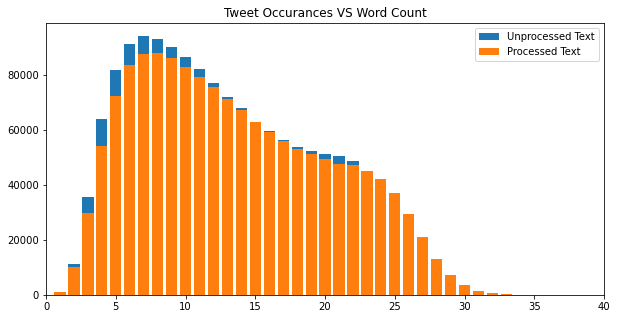

In [359]:
dataSubset["len"]=dataSubset["processed"].apply(lambda x:len(x.split()))
dataSubset["len2"]=dataSubset["tweetText"].apply(lambda x:len(x.split()))
ppp,pp=dataSubset["len"].value_counts(),dataSubset["len2"].value_counts()
plt.figure(figsize=(10,5))
plt.title("Tweet Occurances VS Word Count"  )
plt.bar(ppp.index,ppp,label="Unprocessed Text")
plt.bar(pp.index,pp,label="Processed Text")
plt.xlim([0, 40])
plt.legend()

In [31]:
# dataSubset=dataSubset[(dataSubset[["positive","negative"]].max(axis=1)>0.5)]
# dataSubset["label"]=dataSubset[["positive","negative"]].idxmax(axis=1)

267266    negative
220331    negative
366301    negative
112815    negative
183969    positive
            ...   
122498    positive
77652     negative
41312     negative
48251     negative
179547    negative
Name: label, Length: 485741, dtype: object

## Testing Various Models 

In [27]:
params = [(1,1),(1,2),(1,3)]
result=pd.DataFrame(columns=["model","ngram","POS","Chunking","Emoji","Precision","Recall", "Accuracy","MCC","AUC"])

### Multinomial Naive Bayes

In [16]:
for param in params:
    print("MNB_NGRAM: "+str(param))
    model = Pipeline([('bow', CountVectorizer(max_features=None,preprocessor=None,ngram_range=param,lowercase=False)),
                      ('tfidf', TfidfTransformer()), 
                      ('classifier', MultinomialNB()),])
    model.fit(trainX.values, trainY[original3].values.flatten())
    pred=model.predict(testX.values)
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[result.index.max()+1]=["MNB",str(param),pos,chnk,EMOJI,matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]

MNB_NGRAM: (1, 1)
MNB_NGRAM: (1, 2)
MNB_NGRAM: (1, 3)


### Logisitic Regression

In [20]:
for param in params:
    print("LR_NGRAM: "+str(param))
    model = Pipeline([('bow', CountVectorizer(max_features=None,preprocessor=None,ngram_range=param,lowercase=False)),
                      ('tfidf', TfidfTransformer()),
                      ('classifier',LogisticRegression()),])    
    model.fit(trainX.values, trainY[original3].values.flatten())
    pred=model.predict(testX.values)
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[result.index.max()+1]=["LR",str(param),pos,chnk,EMOJI,matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]

### DNN

In [ ]:
vec_layer = TextVectorization(ngrams=2,max_tokens=None,output_sequence_length=50)
vec_layer.adapt(trainX.tolist())

In [ ]:
tf.keras.backend.clear_session()
def DNN(sequence_length = 60, embedding_dim=16,optimizer='adam'):
    M = Sequential([vec_layer, 
                    Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True),
                    Dense(16, activation="elu"),G
                    Flatten(),
                    Dense(16, activation="elu"),
                    Dense(2,activation='softmax')])
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"]) 
    return M

In [ ]:
tf.get_logger().setLevel('ERROR')
for param in params:
    tf.keras.backend.clear_session()
    vec_layer = TextVectorization(ngrams=param,max_tokens=None,output_sequence_length=50)
    vec_layer.adapt(trainX.tolist())
    model =DNN( sequence_length = 50, embedding_dim=16,optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.6, beta_2=0.999, epsilon=1e-06))
    model.fit(trainX, trainY[cat2],epochs=1, batch_size=10000, validation_data=(testX,testY[cat2]), callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=0)])
    pred=pd.DataFrame( model.predict(testX),columns=[0,1]).idxmax(axis=1) 
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[result.index.max()+1]=["DNN",str(param),pos,chnk,EMOJI,matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
    result.to_csv("sentimentResults.csv")

### LSTM

In [ ]:
tf.keras.backend.clear_session()
callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=3)]
def LSTM_model(sequence_length = 140, embedding_dim=16, optimizer='adam',hidden=16):
    M = Sequential([vec_layer,
                    Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True),
                    LSTM(hidden, 'elu', return_sequences =True),
                    LSTM(hidden,'elu', return_sequences =False),
                    Dense(10,activation='elu'),
                    Dense(2,activation='softmax')])
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"]) 
    return M

In [ ]:
tf.get_logger().setLevel('ERROR')
for param in params:
    tf.keras.backend.clear_session()
    vec_layer = TextVectorization(ngrams=param,max_tokens=None,output_sequence_length=50)
    vec_layer.adapt(trainX.tolist())
    model =LSTM_model(sequence_length = 50, embedding_dim=16,hidden=30,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
    model.fit(trainX, trainY[cat2],epochs=2, batch_size=10000, validation_data=(testX,testY[cat2]), callbacks=callbacks)
    pred=pd.DataFrame( model.predict(testX),columns=[0,1]).idxmax(axis=1) 
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[result.index.max()+1]=["LSTM",str(param),pos,chnk,EMOJI,matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
    result.to_csv("sentimentResults.csv")

### Transformer Encoder

In [2]:
tf.keras.backend.clear_session()
def Transformer_Encoder_Model(optimizer=tf.keras.optimizers.Adam(lr=0.001), hidden=16,embedding_dim=16,encoders=3,key_dim=16,dropout=0.2):
    x =Input(shape=(1,), dtype=tf.string)
    V =vec_layer(x)    
    E=Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True)(V)#try with or without masking
    E=ScalerMult(embedding_dim)(E)
    P=PositionalEncoding(len(vec_layer.get_vocabulary()),embedding_dim)(E)
    p=Masking()(P)#with and without
    out=Encoder(embedding_dim,encoders,hidden,P,key_dim,dropout=dropout,axis=1)
    out=Flatten()(out)
    out=Dense(2,'linear')(out)
    out=Dense(2,'softmax')(out)
    M=tf.keras.models.Model(inputs=x,outputs=out) 
    M.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])  
    return M

In [ ]:
tf.get_logger().setLevel('ERROR')
for param in params:
    tf.keras.backend.clear_session()
    vec_layer = TextVectorization(ngrams=param,max_tokens=None,output_sequence_length=50)
    vec_layer.adapt(trainX.tolist())
    model =Transformer_Encoder_Model(tf.keras.optimizers.Adam(lr=0.001),50,16,3,16,0.4)
    model.fit(trainX, trainY[cat2],epochs=1, batch_size=1000, validation_data=(testX,testY[cat2]))
    pred=pd.DataFrame( model.predict(testX),columns=[0,1]).idxmax(axis=1) 
    per,rec,f1=metrics.precision_recall_fscore_support(testY[original3].values,pred, average='micro')[:3]
    result.loc[result.index.max()+1]=["TFENC",str(param),pos,chnk,EMOJI,matthews_corrcoef(testY[original3].values,pred),per,rec,f1,metrics.roc_auc_score(testY[original3].values,pred)]
    result.to_csv("sentimentResults.csv")

In [ ]:
result=result.sort_values(["model","ngram","POS","Chunking","Emoji"])
result=result.reset_index(drop=True)

In [28]:
# result.result_("sentimentResults.csv")
# pd.read_csv("res.csv",index_col=0).sort_values(by="AUC")

Training the best model with all the data

In [33]:
vec_layer = TextVectorization(ngrams=2,max_tokens=None,output_sequence_length=60)
vec_layer.adapt(dataSubset["processed"].tolist())
# model =Transformer_Encoder_Model(tf.keras.optimizers.Adam(lr=0.001),50,16,3,16,0.4)
# model.fit(dataSubset["processed"], dataSubset[cat2],epochs=1, batch_size=1000)

1519/1519 [==============================] - 656s 430ms/step - loss: 0.5374 - accuracy: 0.7318


In [34]:
model.evaluate(dataSubset["processed"], dataSubset[cat2], batch_size=1000)

1519/1519 [==============================] - 114s 75ms/step - loss: 0.2693 - accuracy: 0.8905


[0.26926058530807495, 0.8905245065689087]

In [43]:
model.save_weights("/modelweights/transformerNLP")

In [11]:
vec_layer = TextVectorization(ngrams=2,max_tokens=None,output_sequence_length=60)
vec_layer.adapt(dataSubset["processed"].tolist())
model=Transformer_Encoder_Model(tf.keras.optimizers.Adam(lr=0.001),50,16,3,16,0.4)
model.load_weights("/modelweights/transformerNLP")
model.evaluate(dataSubset["processed"], dataSubset[cat2], batch_size=1000)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [47]:
dataSubset=getQueryFromMongoDB("Unprocessed").sort_values('_id')
dataSubset["processed"]=dataSubset["tweetText"].apply(lambda t: preprocess(t,pos,chnk,EMOJI))
dataSubset=dataSubset.drop_duplicates(subset=['processed'], keep='last')
dataSubset=dataSubset.sample(frac=1)

In [49]:
dataSubset[["positive","negative"]]=model.predict(dataSubset["processed"])

In [59]:
insertDFToDB("ProcessedTweets",dataSubset.sort_values(by=['_id']))

## Training & evaluating a model

In [ ]:
# sentiment140Value=(getQueryFromMongoDB("processedSentiment140"))[["_id",'SentimentScore','processed']]
# sentiment140Value=sentiment140Value.sample(frac=1)
# sentiment140Value=sentiment140Value.drop_duplicates(subset=['processed'])
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['processed'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# trainX, testX, trainY, testY =train_test_split(sentiment140Value['tweetText'], sentiment140Value['SentimentScore'],shuffle=True, test_size=0.2)

In [ ]:
# model= getSentimentModel(ngram=(1,3))
# model.fit(trainX, trainY) 
# pred=model.predict(testX)
# print(confusion_matrix(testY,pred))
# print(classification_report(testY,pred))

In [ ]:
# def BiLSTM_model(dataset,vocab_size = 5000, sequence_length = 140, embedding_dim=16,mode='int',ngram=1,activation='relu',optimizer='adam',hidden=16):
#     vec_layer = TextVectorization(
#         standardize=None, 
#         output_mode=mode,    #"int", "binary", "count" or "tf-idf"
#         ngrams=ngram,
# #         max_tokens=vocab_size,
#         pad_to_max_tokens=True,
#         output_sequence_length=sequence_length
#                         )
#     vec_layer.adapt(dataset)
#     M = Sequential()
#     M.add(vec_layer),
#     M.add(Embedding(input_dim=len(vec_layer.get_vocabulary()),output_dim=embedding_dim,mask_zero=True))
#     M.add(Bidirectional(LSTM(embedding_dim)))
#     M.add(Dense(hidden, activation='relu'))
#     M.add(Dense(2, activation='softmax'))    
#     M.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=["CategoricalAccuracy"])  
#     return M

## Experiment Results

# Stock Forecasting

## Load Data

Define Which Stock to Use and Prediction Length

In [6]:
stock="BTC-USD"
MSFT=loadStockData(stock)#Load to from YFinance to mongoDB (Comment to use archieved version)
data=getQueryFromMongoDB(stock).sort_values('Date')#Retrieve stock from mongoDB
data=data.set_index(data["Date"])
period=60 #lookback Period
lookAhead=60 #How many days ahead to predict 
data.drop(columns=["Dividends","_id","Date","Stock Splits"],inplace=True)

In [7]:
data

Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2021-04-21  56471.128906  56757.972656  53695.468750  53906.089844   
2021-04-22  53857.105469  55410.230469  50583.812500  51762.273438   
2021-04-23  51739.808594  52120.792969  47714.664062  51093.652344   
2021-04-24  51143.226562  51167.562500  48805.285156  50050.867188   
2021-04-25  50063.343750  50482.335938  49276.582031  50301.328125   

                 Volume  
Date                     
2014-09-17     21056800  
2014-09-18     34483200  
2014-09-19     37919700  
2014-09-20     36863600  
2014-09-21     26580100  
...                 ...  
2021-04-21  54926612466  
2021-04-22  74798630778  
2021-04-23  86668667320  
2021-04-24  49014494781  
2021-04-25  41299632128  

[2409 rows x 5 columns]

In [2266]:
def plotMultVariate(Din,Dout,DinSteps):
    for i in range(len(Din)):
        plt.plot(range(i,i+DinSteps),Din[i],'g')
        plt.plot(range(i,i+DinSteps),Dout[i],alpha=0.5)
    plt.show()
def plotVisual(vs,ps,period=lookAhead,t=0.5):
    for i in range(len(vs)):
        plotMultVariate(vs[:i],ps,period)
        plt.show()
        time.sleep(0.5)
        clear_output(wait=True) 
def reverseOutputTransform(outputs,dataf):
    return np.exp((outputs.iloc[:,:lookAhead]+dataf[["(L-LR)D"]].values)+dataf[["LR"]].values)
def reverseOutputTransform(outputs,dataf):
    return np.exp((outputs.reshape(outputs.shape[0],-1)+dataf[:,-2])+dataf[:,-1])
def calculateMovingLog(r):
    t0=r.iloc[-1]
    for i in range(len(r)-1):
        r[i]=r[i]+t0
        t0=r[i]
    return r
def reverseOutputTransform(outputs,k0):
    d=pd.DataFrame(scaler.inverse_transform(outputs.reshape(outputs.shape[0],-1)))
    d.loc[:,lookAhead]=k0.flatten()
    d=d.apply(calculateMovingLog,axis=1)
    return np.exp(d)
def reverseOutputTransform(outputs,k=None,logged=False,scaled=False):
    outputs=outputs.copy()
    if scaled: 
        for d in range(lookAhead):outputs[:,d]= scaler.inverse_transform(outputs[:,d])
    if k is not None: outputs=outputs*k
    if logged: outputs=np.exp(outputs)
    return outputs
def evaluatePredictions(true,pred,lookAhead=lookAhead):
    results=[None]*lookAhead
    for i in range(lookAhead):
        m = tf.keras.metrics.MeanSquaredError()
        m.update_state(true[:,i],pred[:,i])
        results[i]=m.result().numpy()
        m.reset_states
    return results
def plotAndEvaluate(vy,predictions):
    rs=evaluatePredictions(vy,predictions)
    for i in range(lookAhead):
        plt.title("MSE:"+str(rs[i]))
        plotCompare(vy[:,i],predictions[:,i],["Y","P"])
    print("Shape  :",predictions.shape[0:])
    print("loss   :",model.evaluate(vx,vy,verbose=0))
    printResults(vy,predictions)


Inspect Data for nulls

In [2267]:
data=data.sort_values('Date')
print("NULLs\n")
print(data.isnull().sum())
datarange=[data.index.min().date(), data.index.max().date()]
print("Data Range: ",datarange)

NULLs

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Data Range:  [datetime.date(2010, 6, 29), datetime.date(2021, 4, 21)]


Expand Data To Contain All Days Including The Missing Days 

In [2268]:
data=data.resample('D').first()
data["wasNa"]=data['Close'].isna()#mark filled in spots for future reference
print(data["wasNa"].value_counts())

False    2722
True     1228
Name: wasNa, dtype: int64


Fill Gaps

In [2269]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
# limit_direction{{‘forward’, ‘backward’, ‘both’}}
data=data.interpolate(method='polynomial', order=2, limit_direction='both')
# data.fillna(0)

Transform

In [2270]:
TTI=30
data=data[['Close']]

In [2271]:
# data["InOut"]=np.log(data[['Close']].ewm(span=TTI).mean())
# data["InOut"]=np.log(data[['Close']].ewm(halflife=TTI).mean())
# data["InOut"]=np.log(data[['Close']].rolling(TTI).mean())
# data["InOut"]=(data[['Close']].ewm(span=TTI).mean())
data["InOut"]=(data[['Close']].ewm(halflife=TTI).mean())
# data["InOut"]=(data[['Close']].rolling(TTI).mean())

In [2272]:
dataIn,dataOut=createTimeSeriesData(data.dropna(),["InOut"],outputColumns=["InOut"],outputlengthTimeSteps=lookAhead,shifts=period)
dataOut["WinMean"]=dataIn.mean(axis=1).values
dataIn=dataIn.div(dataOut["WinMean"].values, axis=0)
dataOut.iloc[:,:lookAhead]=dataOut.iloc[:,:lookAhead].div(dataOut["WinMean"].values, axis=0)

In [2273]:
scaler = MinMaxScaler()
buffer=0.1
scaler.fit(np.array([[(dataIn.min().min()-(dataIn.min().min()*np.float64(buffer)))], [dataIn.max().max()*np.float64(1.0+buffer)]]))
# scaler = StandardScaler()
# scaler.fit(dataIn.values[:,0:1])
for d in range(period):dataIn.iloc[:,d]=scaler.transform(dataIn.iloc[:,d].values.reshape(-1,1)).reshape(-1)
for d in range(lookAhead): dataOut.iloc[:,d]= scaler.transform(dataOut.iloc[:,d].values.reshape(-1,1)).reshape(-1)
print("Na Values(Must be zero unless error occurs):\t",(dataOut.isna().sum()).values,(dataIn.isna().sum().values))
print("Positive Vals Check:")
print(np.sign(dataIn.min(axis=1)).value_counts())
print(np.sign(dataOut.min(axis=1)).value_counts())
print("All must be 1/0 unless error occurs in this case increase buffer")

Na Values(Must be zero unless error occurs):	 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Positive Vals Check:
1.0    3831
dtype: int64
1.0    3831
dtype: int64
All must be 1/0 unless error occurs in this case increase buffer


In [2274]:
dataIn=(dataIn.to_numpy().reshape(dataIn.shape[0],dataIn.shape[1],-1))
dataOut=(dataOut.to_numpy().reshape(dataOut.shape[0],dataOut.shape[1],-1))

			 Trend               Seasonal                  Residual
Mean: 5.424739979372178 [5.436078533251797, -5.475072450206251e-18, -0.011338553879619276]
STD: 1.5034724190339555 [0.5740475890256519, 0.4968260592308978, 0.43259877077740577]


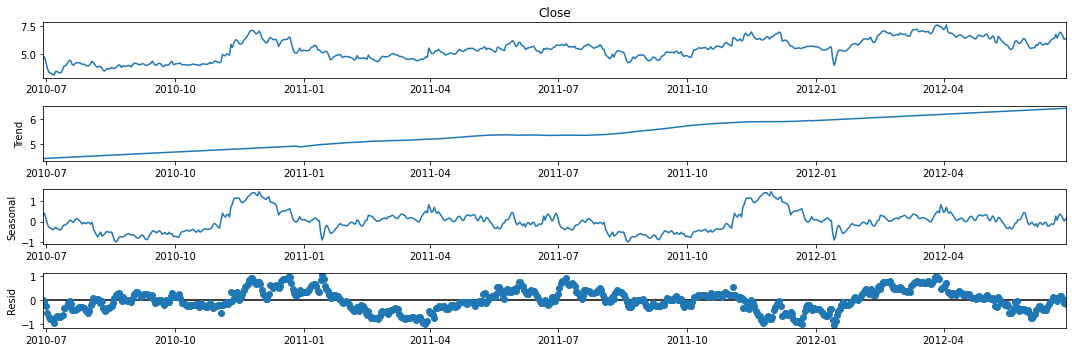

In [2275]:
result_add = seasonal_decompose(data["Close"][:730], model='a', extrapolate_trend='freq', period=365)
result_add.plot() 
print("\t\t\t Trend               Seasonal                  Residual")
r=[result_add.trend.mean(),result_add.seasonal.mean(),result_add.resid.mean()]
print("Mean:",sum(r),r)
r=[result_add.trend.std(),result_add.seasonal.std(),result_add.resid.std()]
print("STD:", sum(r),r)

			 Trend               Seasonal                  Residual
Mean: 0.40021831406477354 [0.4021535324816761, -3.041706916781251e-19, -0.0019352184169026008]
STD: 0.08365267674866465 [0.006125338526135657, 0.04120640469456647, 0.03632093352796253]


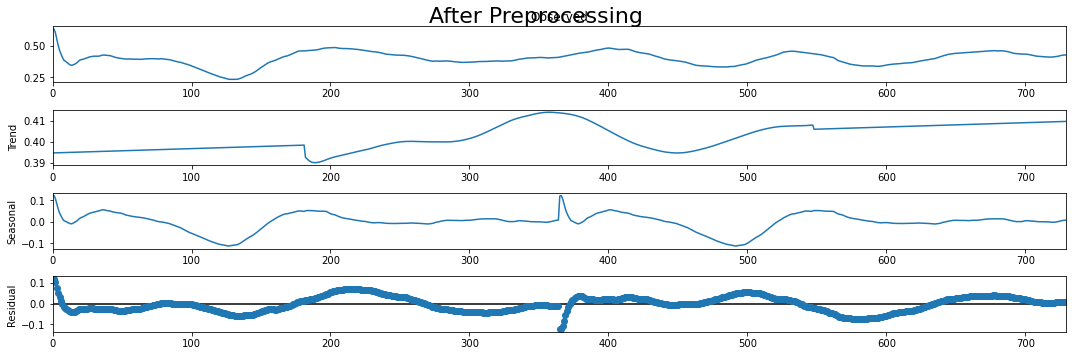

In [2276]:
result_add = seasonal_decompose(dataIn[:730,0], model='a', extrapolate_trend='freq', period=365)
result_add.plot().suptitle('After Preprocessing', fontsize=22) 
print("\t\t\t Trend               Seasonal                  Residual")
r=[result_add.trend.mean(),result_add.seasonal.mean(),result_add.resid.mean()]
print("Mean:",sum(r),r)
r=[result_add.trend.std(),result_add.seasonal.std(),result_add.resid.std()]
print("STD:", sum(r),r)

Dickey-Fuller Tests

In [2277]:
fullerR = adfuller(data["Close"])
print("___Unprocessed___")
print('ADF Statistic:', fullerR[0])
print('p-value:', fullerR[1])
for key, value in fullerR[4].items(): print('\t',key,':',value)
print("p>0.05 None Stationary")

___Unprocessed___
ADF Statistic: 2.1356184614885665
p-value: 0.9988252121967816
	 1% : -3.43202013514632
	 5% : -2.8622779742883466
	 10% : -2.5671628322989846
p>0.05 None Stationary


In [2278]:
fullerR = adfuller(dataIn[:,0])
print("___Processed___")
print('ADF Statistic:', fullerR[0])
print('p-value:', fullerR[1])
for key, value in fullerR[4].items(): print('\t',key,':',value)
print("p<=0.05 Stationary")

___Processed___
ADF Statistic: -5.220505340782731
p-value: 7.982986090270468e-06
	 1% : -3.4320679607261453
	 5% : -2.86229910063996
	 10% : -2.5671740791451567
p<=0.05 Stationary


## Data Splitting

In [2279]:
split=0.2
trainx,vx,trainy,vy=train_test_split(dataIn,dataOut,test_size=split,shuffle=False)
traink,vk=trainy[:,lookAhead:],vy[:,lookAhead:]
trainy,vy=trainy[:,:lookAhead],vy[:,:lookAhead]
print("Total Samples:",len(dataIn),"\tTraining Samples:",len(trainx),"  Total Validation Samples:",len(vy))
print("Input Shape:",trainx.shape[1:],"\tOutput Shape:",trainy.shape[1:])

Total Samples: 3831 	Training Samples: 3064   Total Validation Samples: 767
Input Shape: (60, 1) 	Output Shape: (60, 1)


In [2280]:
trainx.shape,trainy.shape,vy.shape,vx.shape,vk.shape

((3064, 60, 1), (3064, 60, 1), (767, 60, 1), (767, 60, 1), (767, 1, 1))

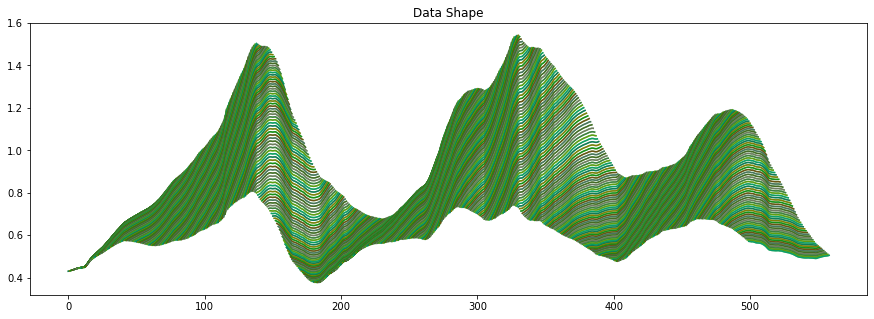

In [2281]:
rrr=len(vy)-500# From which step
shiftff=500# How many points to plot
plt.title("Data Shape")
plotMultVariate(vy[rrr:rrr+shiftff],vy[rrr:rrr+shiftff],lookAhead)

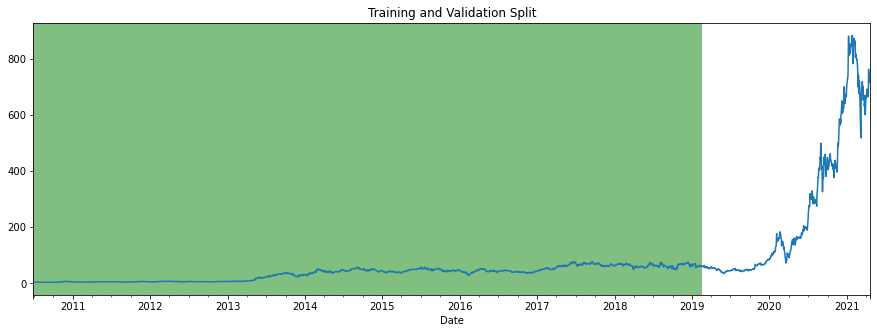

In [2282]:
ax = data['Close'].plot()
plt.title("Training and Validation Split")
f,f[len(trainx):],f[len(trainx)+len(vx):]=np.full((len(dataIn)), 1),2,3
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),f[np.newaxis],cmap='ocean', alpha=0.5)
plt.show()#Green is the training data white is the validation data 

## Data Exploration

## Creating Performance Baselines 

In [2283]:
byDay=False
counter=0

In [2284]:
def calculateAccuracy(model,stock,modelName,singleshot,byDay,benchmarker,period,lookAhead,trainx,trainy,vx,vy):
    if singleshot: 
        predictionsT=StepForwardPredictions(trainx,model,lookAhead)
        predictions=StepForwardPredictions(vx,model,lookAhead)
    else: 
        predictionsT=model.predict(trainx)
        predictions=model.predict(vx)
    benchmarker.loc[benchmarker.index.max()+1]=0
    benchmarker.loc[benchmarker.index.max()]["Model"]=modelName
    benchmarker.loc[benchmarker.index.max()]["Stock"]=stock
    benchmarker.loc[benchmarker.index.max()]["1-Shot"]=singleshot
    if byDay: benchmarker.loc[benchmarker.index.max(),3:]=np.array([evaluatePredictions(trainy,predictionsT),evaluatePredictions(vy,predictions)]).reshape(-1,order='C')
    else: 
        benchmarker.loc[benchmarker.index.max(),3:5]=[period,lookAhead]
        benchmarker.loc[benchmarker.index.max(),5:]=np.array([getResults(trainy,predictionsT, False)[:-1],getResults(vy,predictions, False)[:-1]]).flatten()
    return benchmarker

In [2285]:
if byDay:
    columns=[s+"_t"+str(i) for s in ["Train","Val"] for i in range(lookAhead)]
    columns.insert(0, "1-Shot")
    columns.insert(0, "Model")
    benchmarker=pd.DataFrame(columns=columns)
else:
    columns=["Model","Stock","1-Shot","InWindow","OutWindow","T_MSE","T_RMSE","T_NMSE","T_Symmetry","T_Normed Symmetry","MSE","RMSE","NMSE","Symmetry","Normed Symmetry"]
    benchmarker=pd.DataFrame(columns=columns)

repeat last input baseline

In [2133]:
repeatLastTrain=np.array([np.full((lookAhead,1), v[-1]) for v in trainx])
repeatLastVal=np.array([np.full((lookAhead,1), v[-1]) for v in vx])

In [2134]:
print(evaluatePredictions(trainy,repeatLastTrain))
print(evaluatePredictions(vy,repeatLastVal))

[1.151552e-05, 4.5650646e-05, 0.00010180847, 0.00017954444, 0.00027849525, 0.00039832608, 0.00053872564, 0.0006993844, 0.00088000484, 0.0010802961, 0.0012999665, 0.0015387407, 0.0017963637, 0.0020725979, 0.0023672003, 0.0026799364, 0.0030106113, 0.003359016, 0.0037249438, 0.0041081943, 0.004508576, 0.0049259006, 0.005359959, 0.005810531, 0.0062774043, 0.006760378, 0.0072592595, 0.007773852, 0.008303953, 0.008849343, 0.009409809, 0.009985179, 0.010575302, 0.011180059, 0.011799346, 0.0124330465, 0.013081038, 0.0137432255, 0.014419478, 0.015109679, 0.015813714, 0.016531454, 0.017262777, 0.018007565, 0.018765718, 0.019537132, 0.020321699, 0.02111932, 0.02192991, 0.022753382, 0.023589656, 0.024438616, 0.025300218, 0.026174357, 0.027060937, 0.027959872, 0.028871093, 0.029794553, 0.030730218, 0.031678032]
[4.086267e-06, 1.620941e-05, 3.618389e-05, 6.388556e-05, 9.920161e-05, 0.00014200961, 0.0001921985, 0.00024966494, 0.00031430437, 0.000386034, 0.00046475956, 0.0005503747, 0.0006427872, 0.00

In [2135]:
trainx.shape,trainy.shape,vx.shape,vy.shape

((11698, 60, 1), (11698, 60, 1), (2925, 60, 1), (2925, 60, 1))

In [2136]:
benchmarker.loc[0]=0
benchmarker.loc[0]["Model"]="RepeatBL"
benchmarker.loc[0]["Stock"]=stock
benchmarker.loc[0]["1-Shot"]=np.nan
if byDay: benchmarker.iloc[0,2:]=np.array([evaluatePredictions(trainy,repeatLastTrain),evaluatePredictions(vy,repeatLastVal)]).reshape(-1,order='C')
else: 
    benchmarker.iloc[0,3:5]=[period,lookAhead]
    benchmarker.iloc[0,5:]=np.array([getResults(trainy,repeatLastTrain, False)[:-1],getResults(vy,repeatLastVal, False)[:-1]]).flatten()

In [2137]:
shiftbyone=np.array([v[-lookAhead+1:] for v in trainx])
shiftbyoneTrain=np.append(shiftbyone,trainy[:,:1],axis=1)
shiftbyone=np.array([v[-lookAhead+1:] for v in vx])
shiftbyonVal=np.append(shiftbyone,vy[:,:1],axis=1)

In [2138]:
print(evaluatePredictions(trainy,shiftbyoneTrain))
print(evaluatePredictions(vy,shiftbyonVal))

[0.027378958, 0.027382525, 0.027388647, 0.027397178, 0.027407957, 0.027421134, 0.027436813, 0.027455099, 0.027475988, 0.027499437, 0.027525447, 0.027554024, 0.02758511, 0.027618578, 0.02765429, 0.027692124, 0.027731992, 0.027773835, 0.027817624, 0.027863368, 0.02791103, 0.02796055, 0.028011868, 0.02806492, 0.028119663, 0.02817614, 0.028234348, 0.028294254, 0.02835571, 0.028418595, 0.02848286, 0.02854853, 0.028615607, 0.028683964, 0.028753541, 0.028824326, 0.028896302, 0.028969435, 0.029043697, 0.029119099, 0.029195588, 0.029273124, 0.029351672, 0.029431194, 0.02951165, 0.029593019, 0.029675253, 0.029758362, 0.029842367, 0.029927313, 0.0300132, 0.030099995, 0.03018771, 0.030276276, 0.030365624, 0.030455714, 0.0305465, 0.030637987, 0.030730218, 0.030823186]
[0.009556811, 0.009577763, 0.009598667, 0.009619531, 0.0096404, 0.009661279, 0.009682242, 0.009703329, 0.009724465, 0.009745563, 0.009766492, 0.009787183, 0.009807669, 0.00982799, 0.00984825, 0.009868453, 0.009888612, 0.009908745, 0.0

In [2139]:
benchmarker.loc[1]=0
benchmarker.loc[1]["Model"]="ShiftBL"
benchmarker.loc[1]["Stock"]=stock
benchmarker.loc[1]["1-Shot"]=np.nan
if byDay: benchmarker.iloc[1,2:]=np.array([evaluatePredictions(trainy,shiftbyoneTrain),evaluatePredictions(vy,shiftbyonVal)]).reshape(-1,order='C')
else: 
    benchmarker.iloc[1,3:5]=[period,lookAhead]
    benchmarker.iloc[1,5:]=np.array([getResults(trainy,shiftbyoneTrain, False)[:-1],getResults(vy,shiftbyonVal, False)[:-1]]).flatten()

## Testing Different Models Performance

In [2140]:
def compileFit(model, TrainingX=trainx, TrainingY=trainy,ValX=vx,ValY=vy,optimizer="adam",loss="mean_squared_error", patience=3,epochs=400,shuffle=True,batch_size=75,singleshot=False):
    model.compile(loss=loss,optimizer=optimizer)
    if singleshot: return model.fit(TrainingX, TrainingY[:, 0],shuffle=shuffle, batch_size=batch_size,validation_data=(vx,vy[:, 0]),epochs=epochs,callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=patience))  
    return model.fit(TrainingX, TrainingY,shuffle=shuffle, batch_size=batch_size,validation_data=(vx,vy),epochs=epochs,callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=patience))

In [2141]:
trainx.shape,trainy.shape

((11698, 60, 1), (11698, 60, 1))

In [2142]:
tf.keras.backend.clear_session()
singleshot=False
# callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=5)]
# lr_shedule=tf.keras.callbacks.LearningRateScheduler( lambda x: 1e-8*10**(x/20))

### Transformer

In [2143]:
tf.keras.backend.clear_session()
def Transformer_Encoder_Model(inputShape=(period,1),model_dim=2, hidden=20,encoders=2,key_dim=2,axis=1,dropout=0.2,singleshot=False):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    x = Input(shape=inputShape)
    Ms= Masking()(x)
    E = ScalerMult(inputShape)(Ms)
    P = PositionalEncoding(inputShape[0], inputShape[1])(E)
    out=Encoder(model_dim,encoders,hidden,P,key_dim,dropout=dropout,axis=axis,epsilon=1e-7)
    out=Flatten()(out)
    out=Dense(outputSize,'elu')(out)
    out=Reshape([outputSize, 1])(out)
    return tf.keras.models.Model(inputs=x,outputs=out) 
model=Transformer_Encoder_Model(inputShape=trainx.shape[1:],model_dim=trainx.ndim-1, hidden=30,encoders=2,key_dim=2,axis=1,dropout=0.2,singleshot=singleshot)
history =compileFit(model,loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),epochs=10000,batch_size=500,patience=50,singleshot=singleshot)

Epoch 1/10000
24/24 [==============================] - 3s 33ms/step - loss: 0.5856 - val_loss: 0.0526
Epoch 2/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.0757 - val_loss: 0.0103
Epoch 3/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0376 - val_loss: 0.0053
Epoch 4/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.0281 - val_loss: 0.0046
Epoch 5/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0238 - val_loss: 0.0041
Epoch 6/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0202 - val_loss: 0.0038
Epoch 7/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0181 - val_loss: 0.0035
Epoch 8/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0163 - val_loss: 0.0034
Epoch 9/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.0149 - val_loss: 0.0032
Epoch 10/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.013

24/24 [==============================] - 0s 16ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 160/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 161/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 162/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 163/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 164/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 165/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 166/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 167/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 168/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.

Epoch 238/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 239/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 240/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 241/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 242/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 243/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 244/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 245/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 246/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 247/10000
24/24 [==============================] - 0s 16ms

Epoch 317/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 318/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 319/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 320/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0020
Epoch 321/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 322/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 323/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 324/10000
24/24 [==============================] - 0s 16ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 325/10000
24/24 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 326/10000
24/24 [==============================] - 0s 15ms

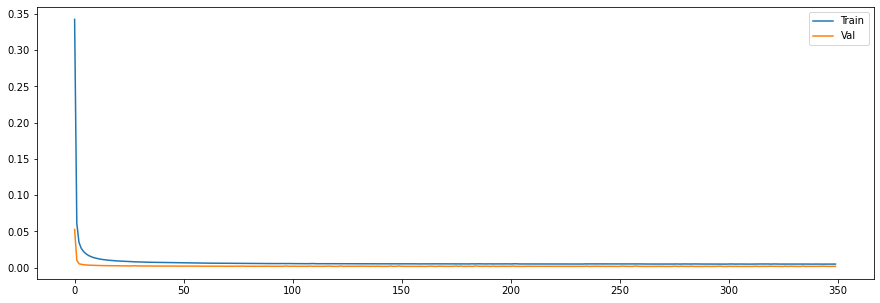

In [2144]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [2145]:
# if singleshot: 
#     predictionsT=StepForwardPredictions(trainx,model,lookAhead)
#     predictions=StepForwardPredictions(vx,model,lookAhead)
# else: 
#     predictionsT=model.predict(trainx)
#     predictions=model.predict(vx)
# benchmarker.loc[benchmarker.index.max()+1]=0
# benchmarker.loc[benchmarker.index.max()]["Model"]="TFENC"
# benchmarker.loc[benchmarker.index.max()]["1-Shot"]=singleshot
# if byDay: benchmarker.loc[benchmarker.index.max(),2:]=np.array([evaluatePredictions(trainy,predictionsT),evaluatePredictions(vy,predictions)]).reshape(-1,order='C')
# else: 
#     benchmarker.loc[benchmarker.index.max(),2:4]=[period,lookAhead]
#     benchmarker.loc[benchmarker.index.max(),4:]=np.array([getResults(trainy,predictionsT, False)[:-1],getResults(vy,predictions, False)[:-1]]).flatten()

In [2146]:
if singleshot: 
    predictionsT=StepForwardPredictions(trainx,model,lookAhead)
    predictions=StepForwardPredictions(vx,model,lookAhead)
else: 
    predictionsT=model.predict(trainx)
    predictions=model.predict(vx)

In [2147]:
calculateAccuracy(model,stock,"TFENC",singleshot,byDay,benchmarker,period,lookAhead,trainx,trainy,vx,vy)

<ipython-input-2131-f95d9c143d5c>:14: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),3:5]=[period,lookAhead]
<ipython-input-2131-f95d9c143d5c>:15: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),5:]=np.array([getResults(trainy,predictionsT, False)[:-1],getResults(vy,predictions, False)[:-1]]).flatten()


Model Stock 1-Shot InWindow OutWindow     T_MSE    T_RMSE    T_NMSE  \
0  RepeatBL  AAPL    NaN       60        60  0.011423  0.106878  0.070915   
1   ShiftBL  AAPL    NaN       60        60  0.028671  0.169324  0.112349   
2     TFENC  AAPL  False       60        60  0.004932  0.070231  0.046599   

  T_Symmetry T_Normed Symmetry       MSE      RMSE      NMSE  Symmetry  \
0  -0.196233         -0.130203  0.004062  0.063737  0.090929 -0.494872   
1  -0.213934         -0.141948  0.010188  0.100935  0.143995 -0.537949   
2   0.035855           0.02379  0.001708  0.041327  0.058957 -0.041447   

  Normed Symmetry  
0       -0.705992  
1       -0.767446  
2       -0.059129

In [2148]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [2149]:
fromN,toN=60,70

<AxesSubplot:>

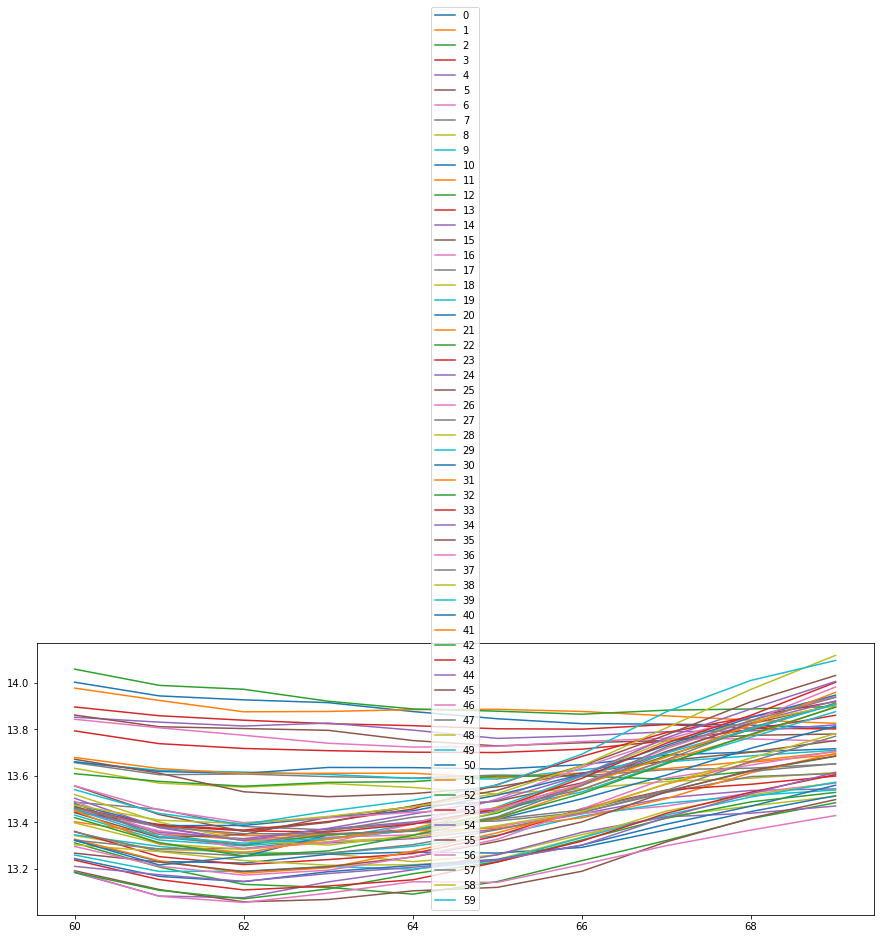

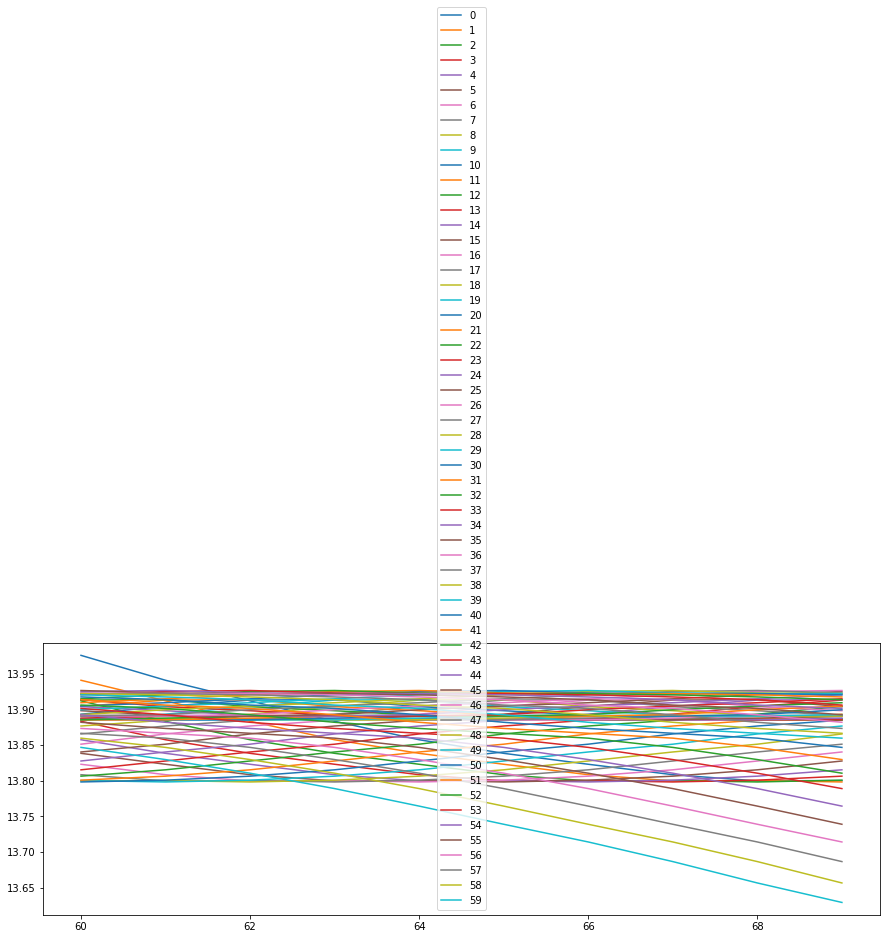

In [2150]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()

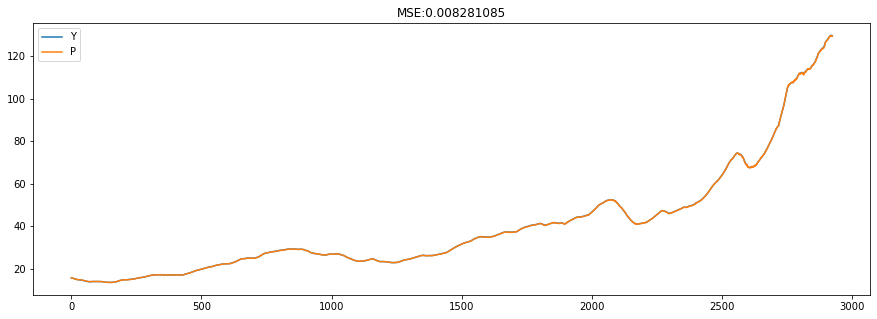

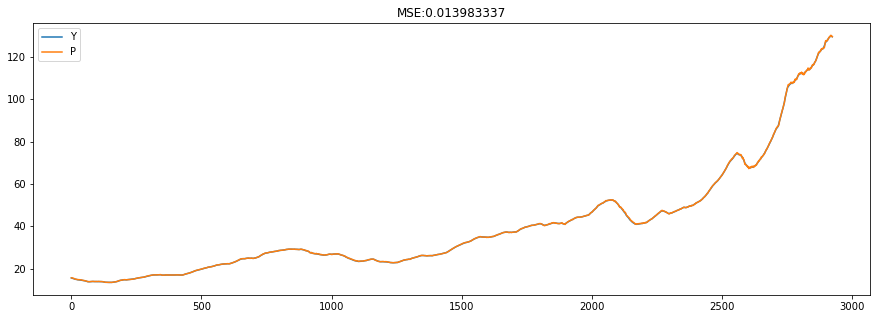

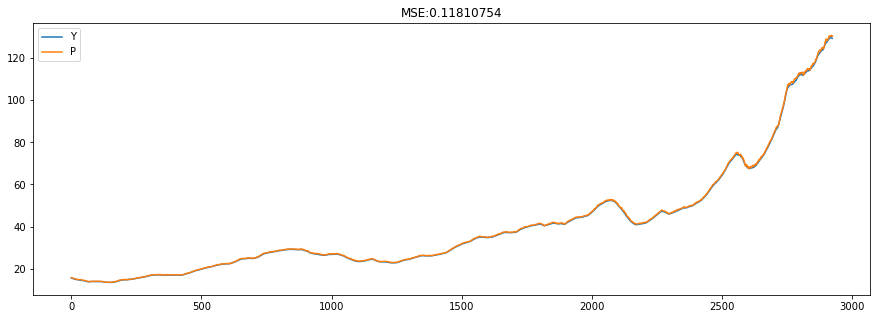

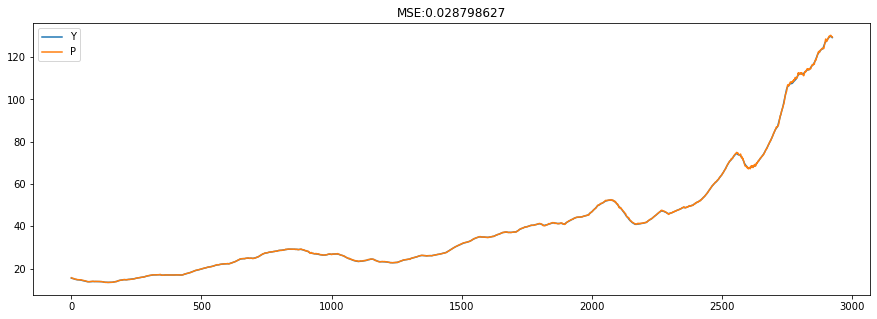

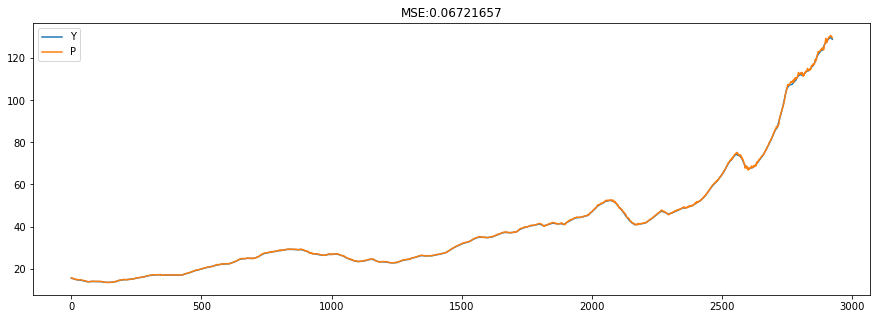

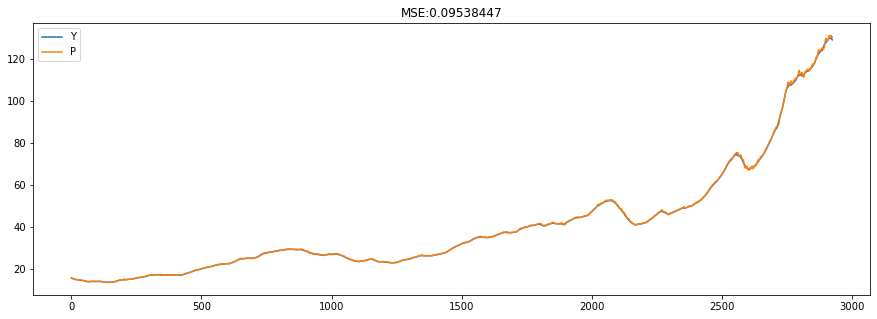

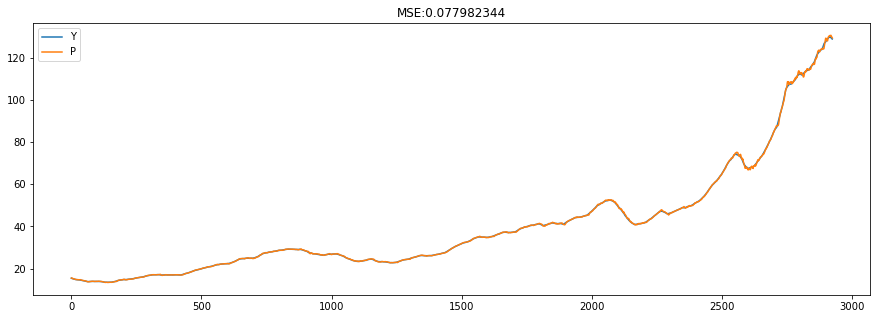

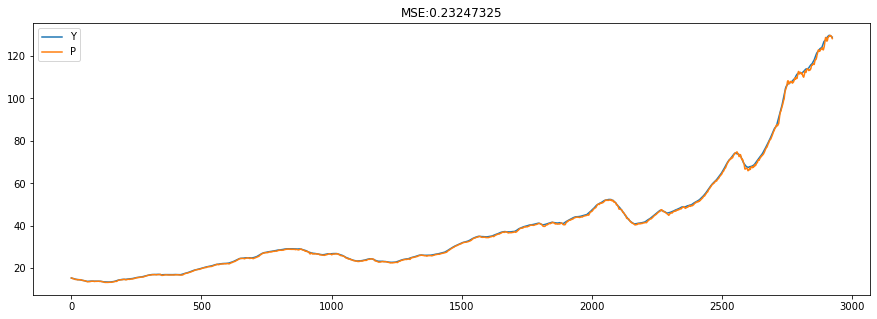

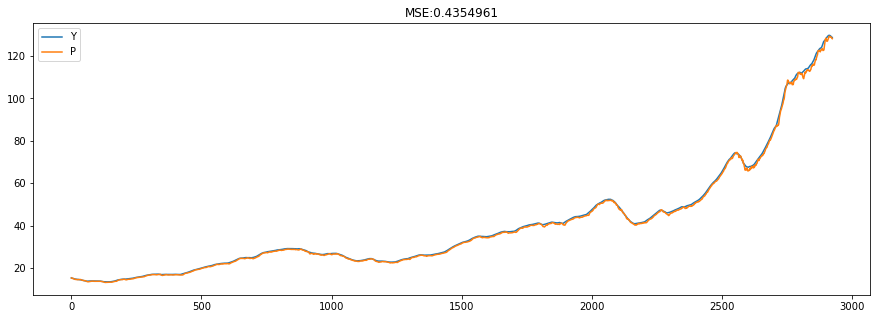

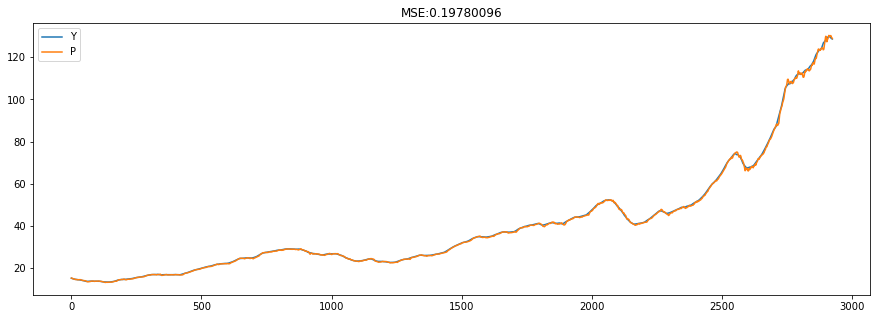

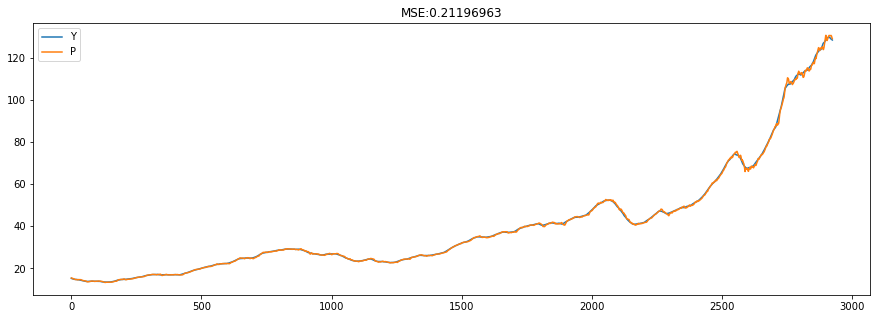

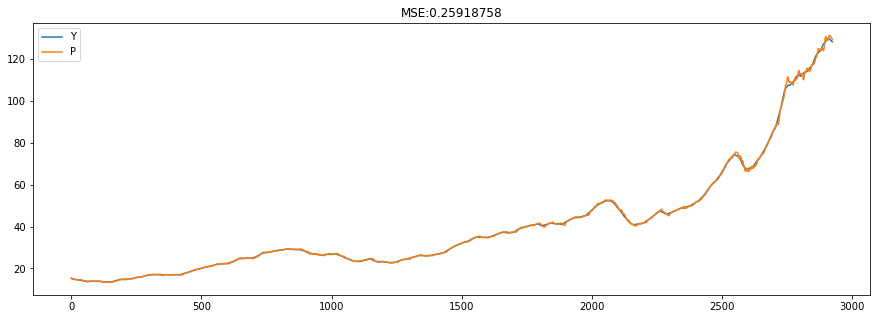

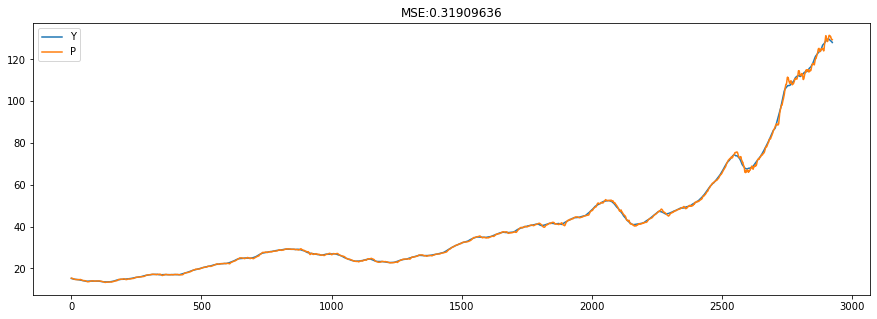

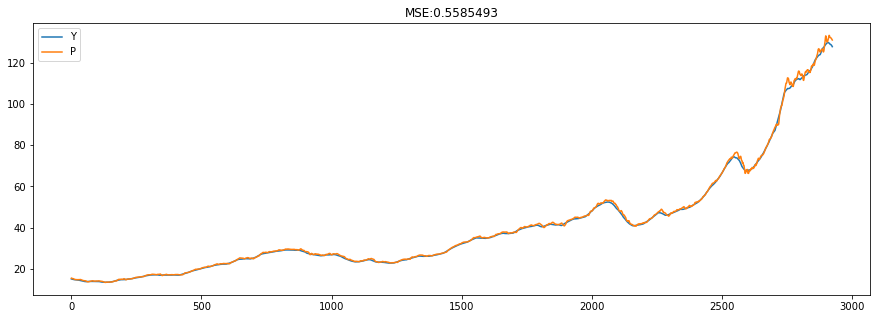

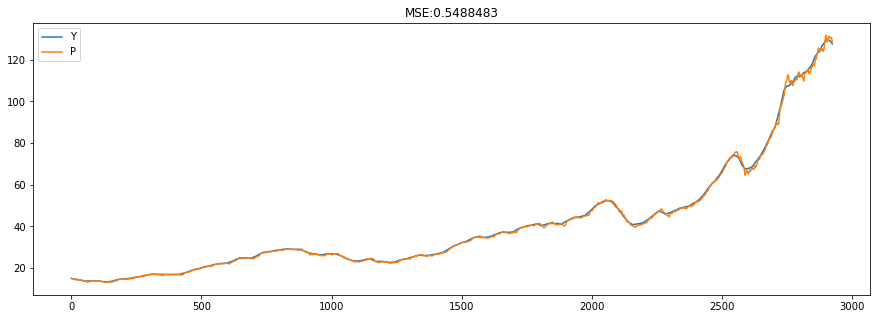

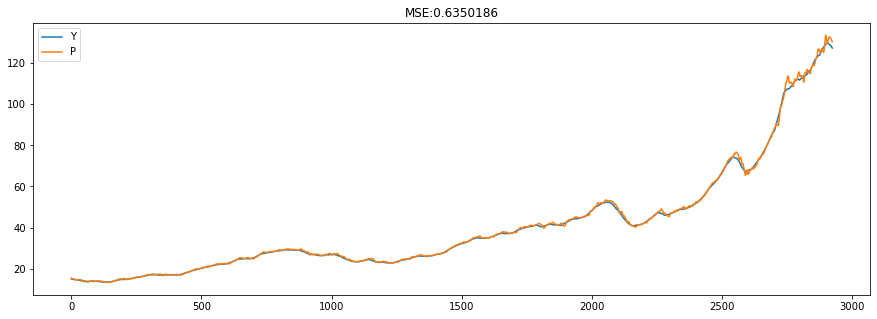

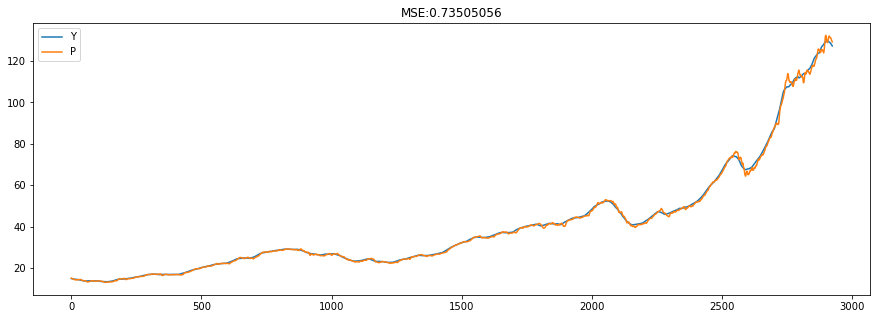

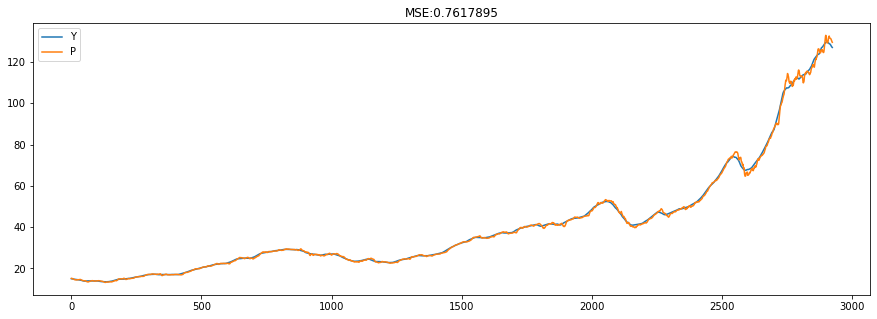

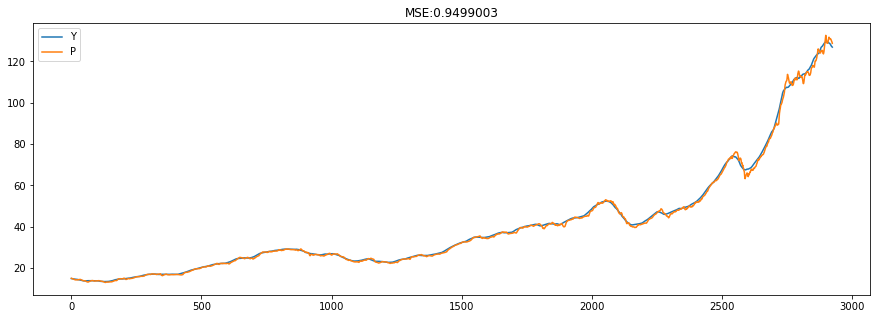

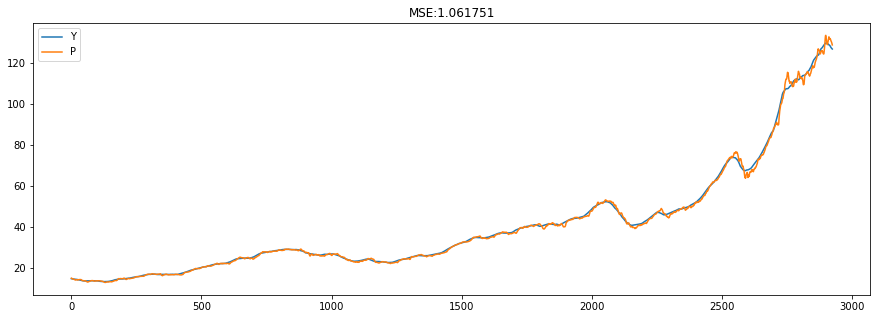

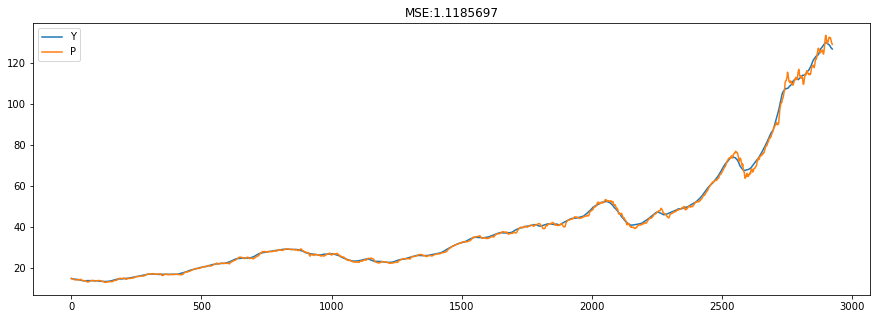

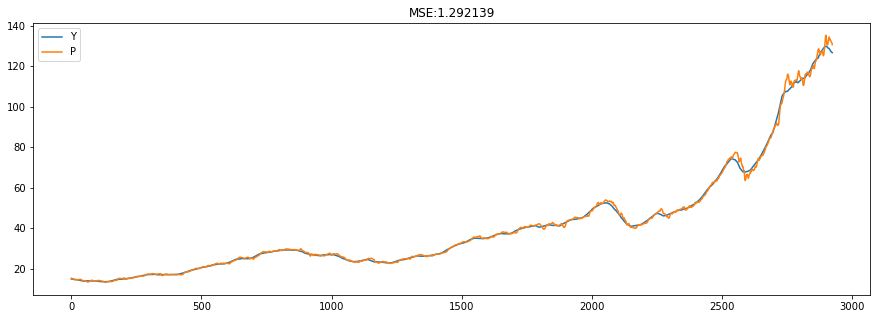

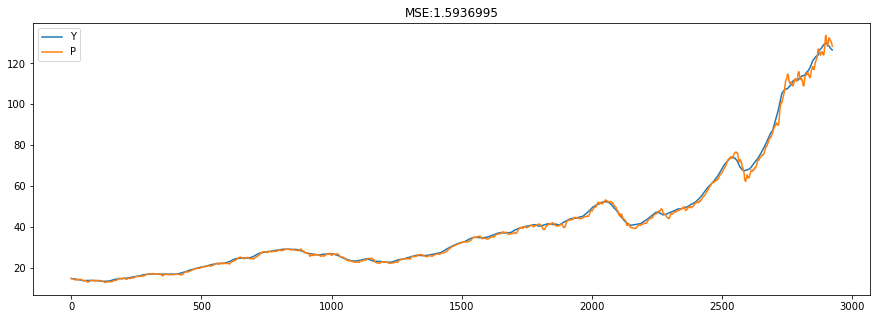

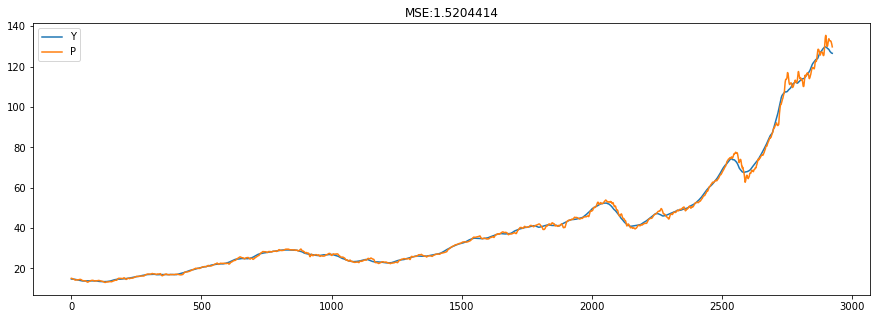

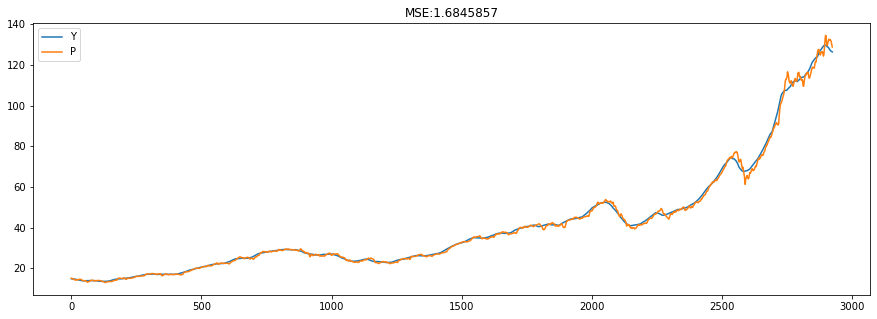

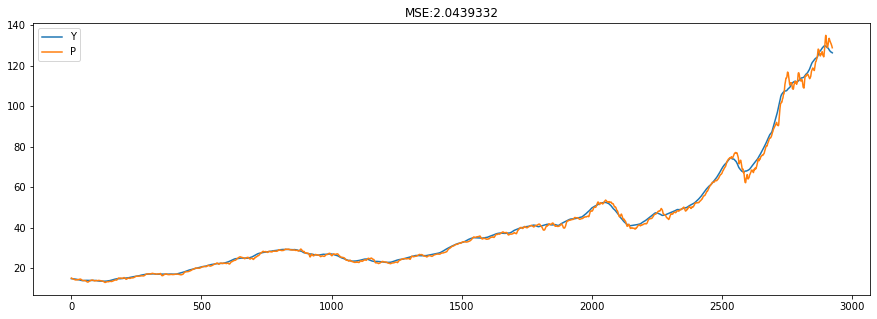

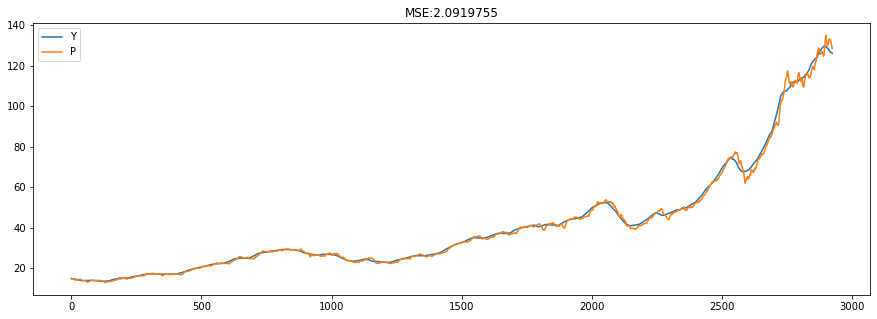

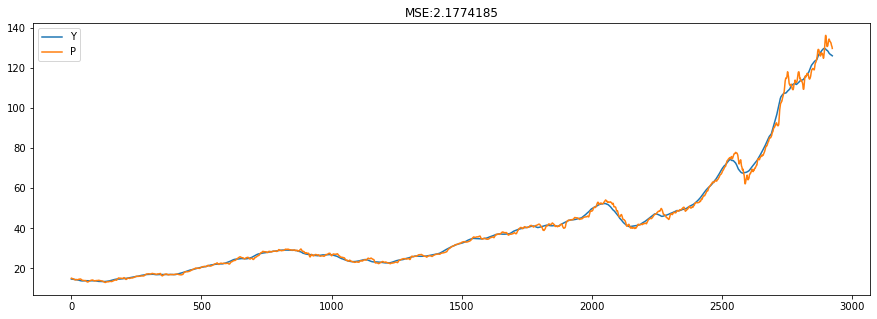

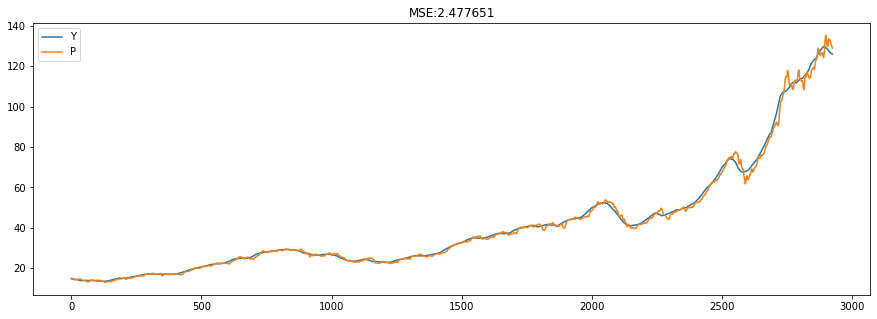

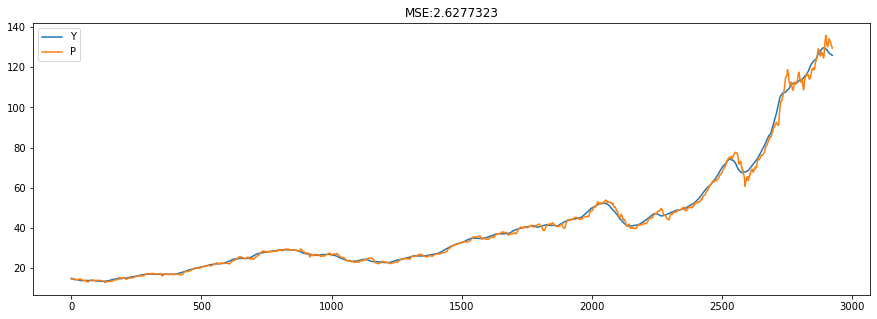

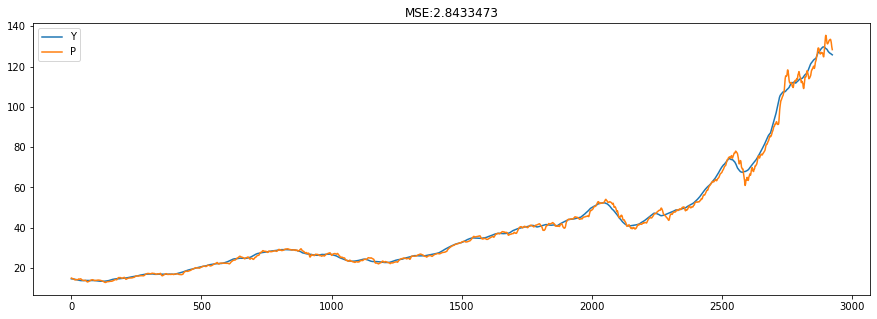

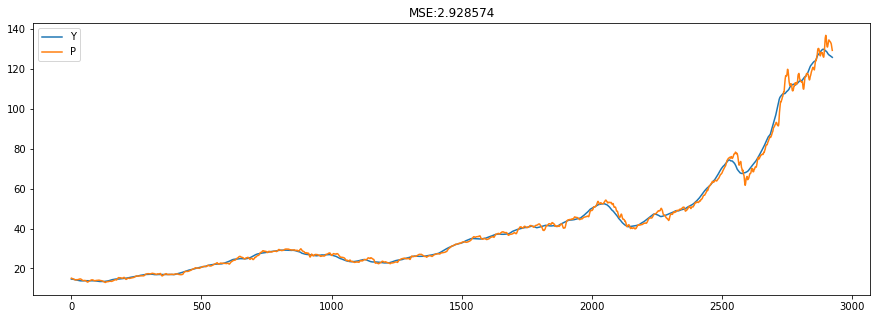

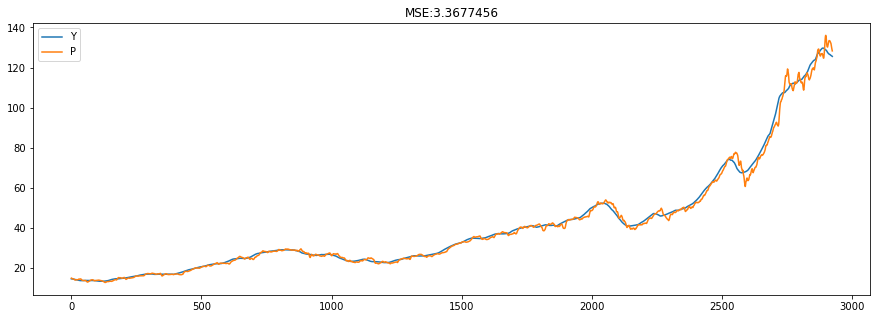

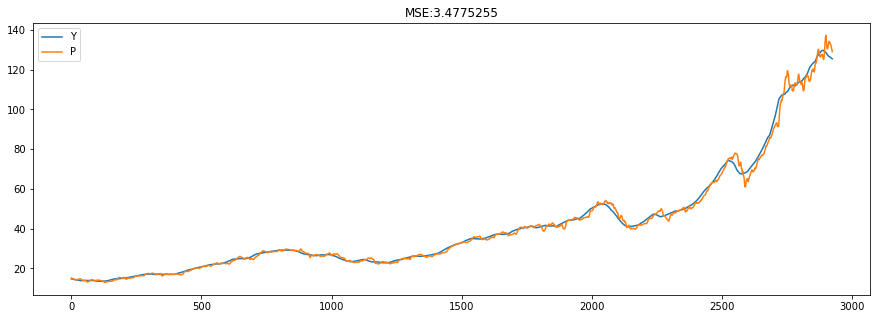

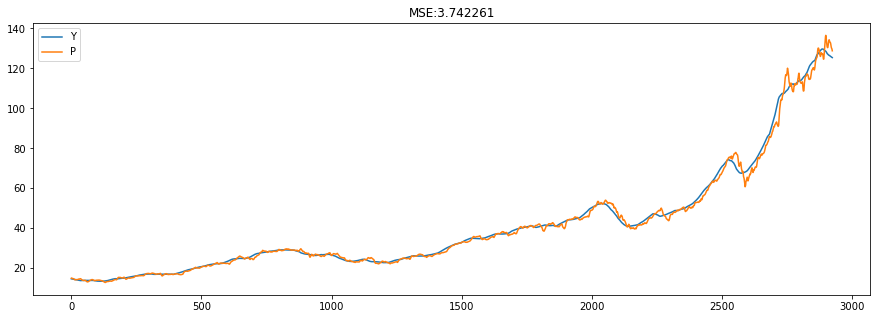

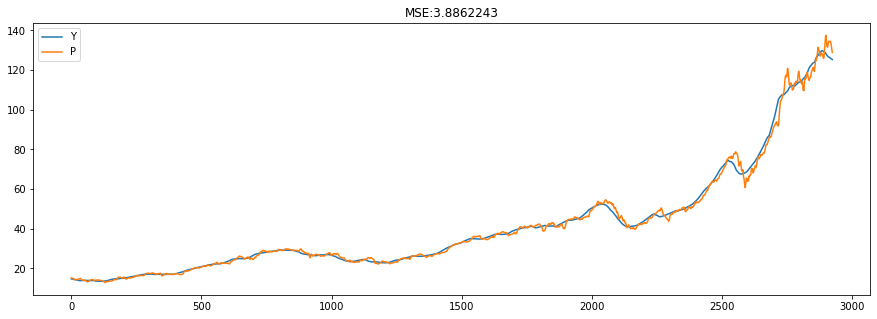

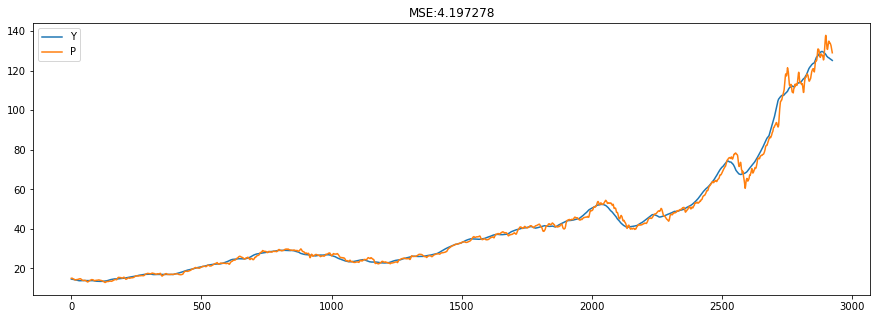

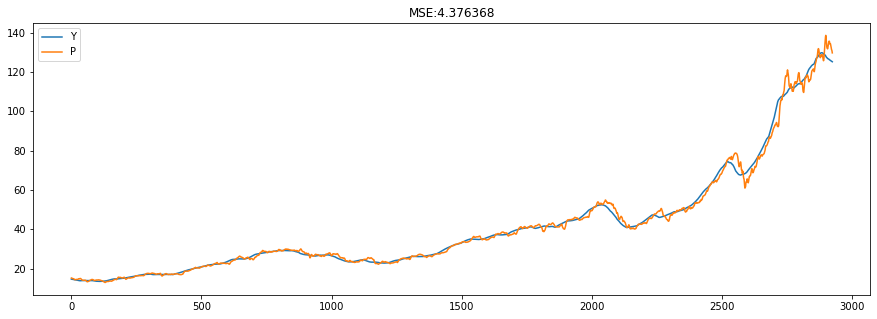

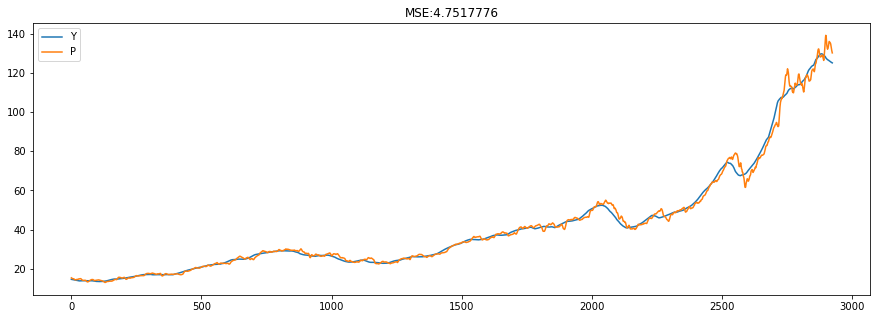

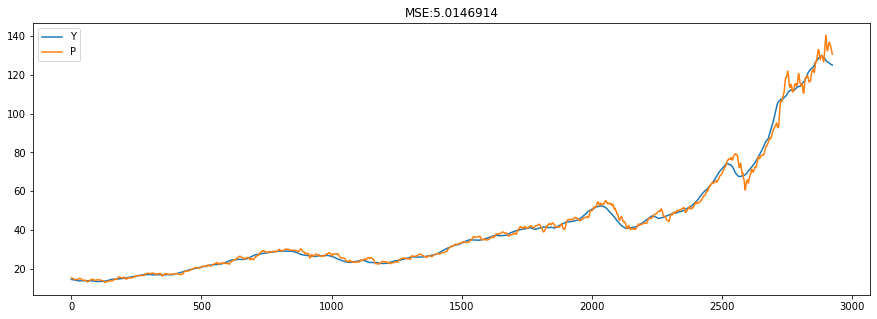

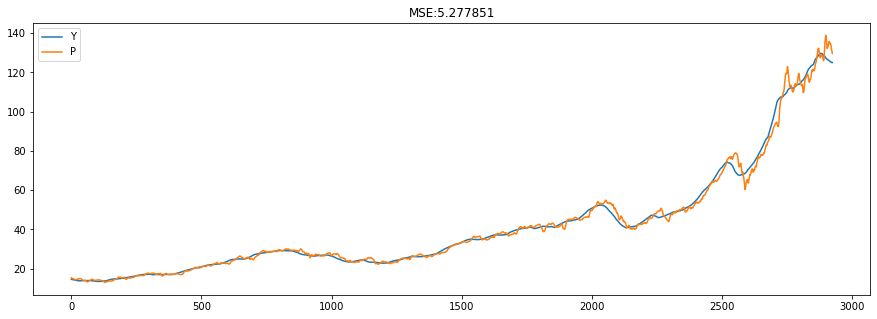

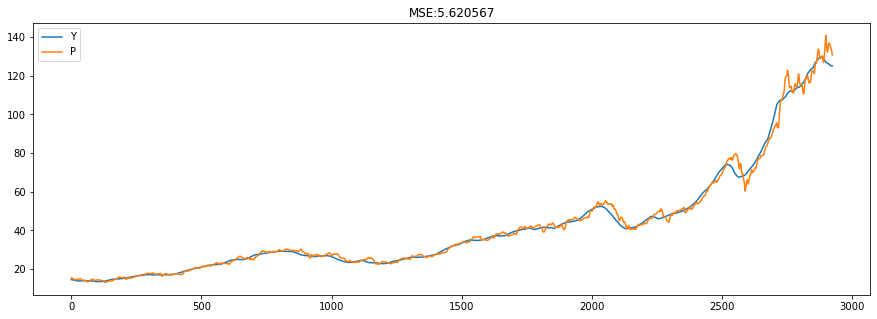

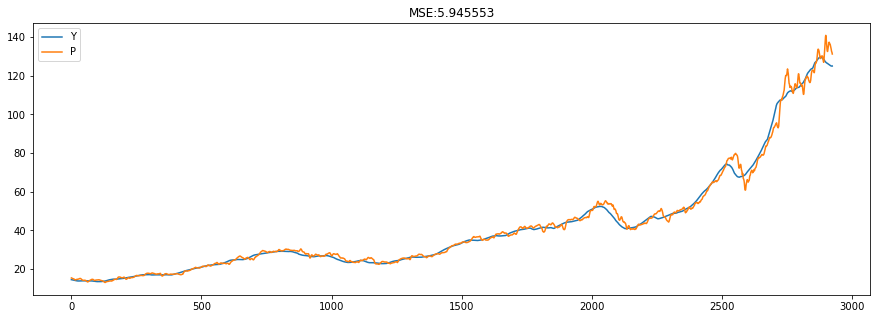

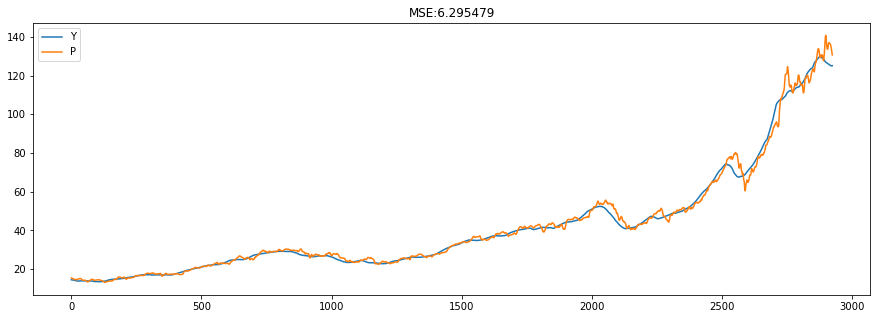

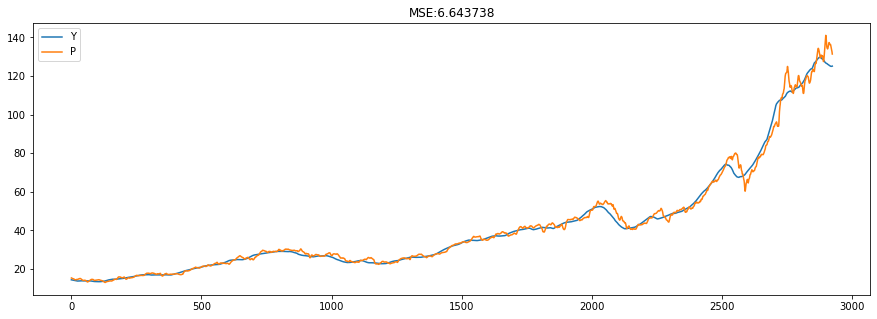

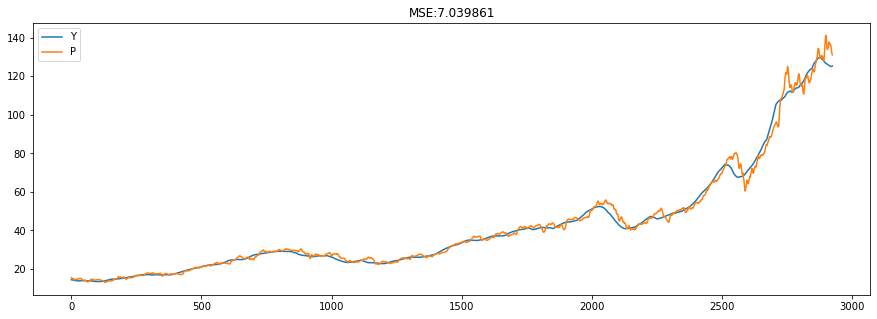

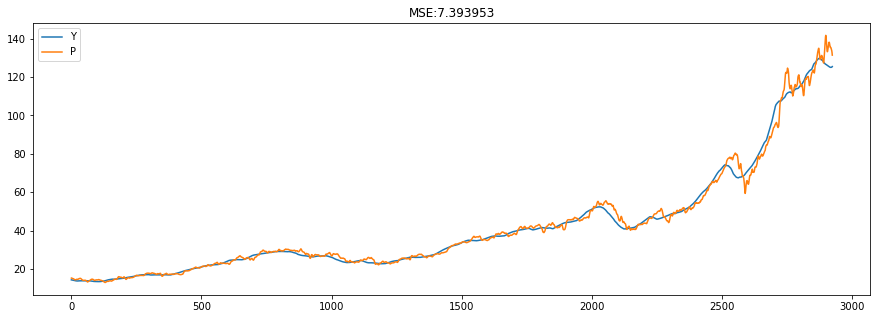

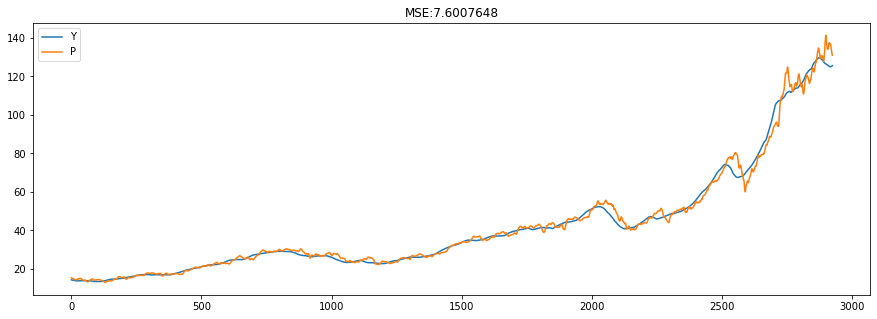

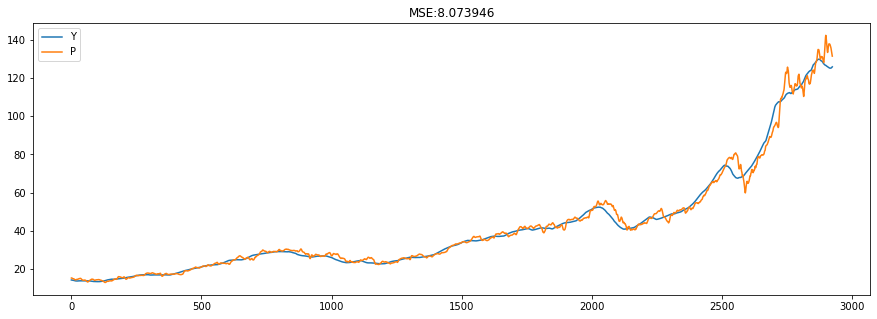

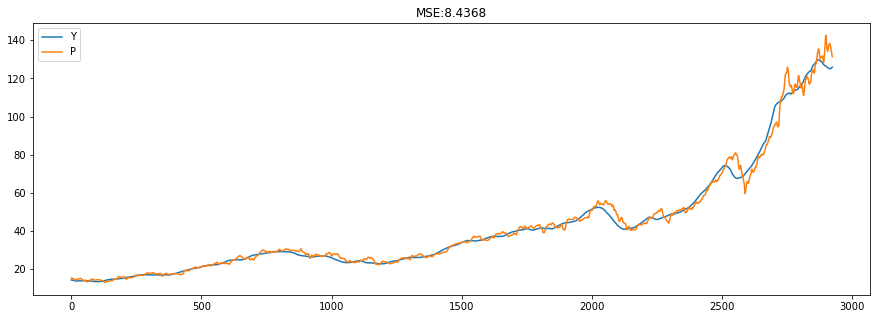

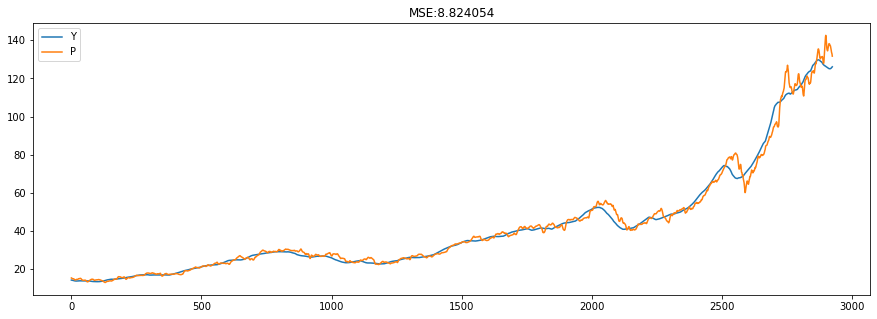

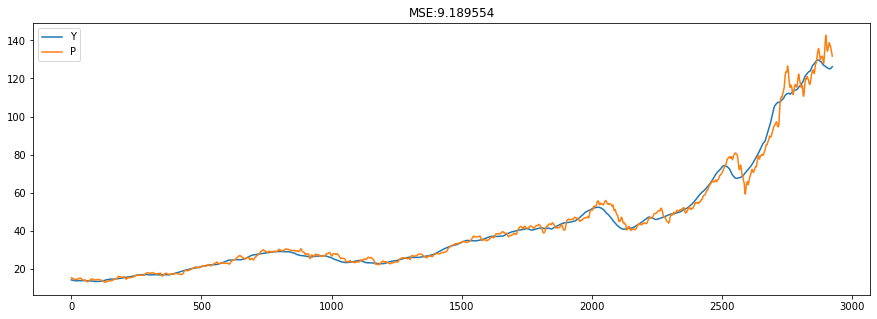

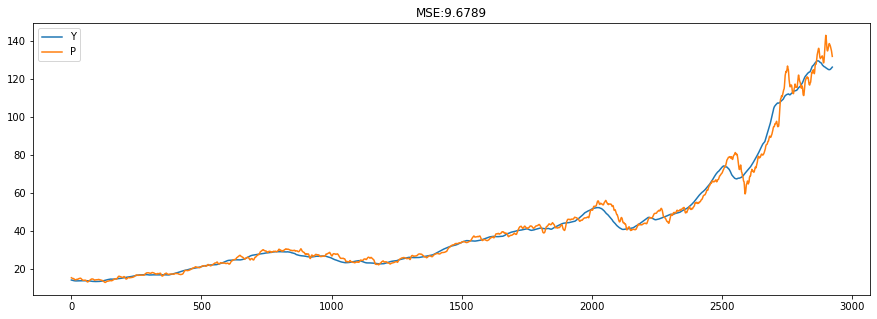

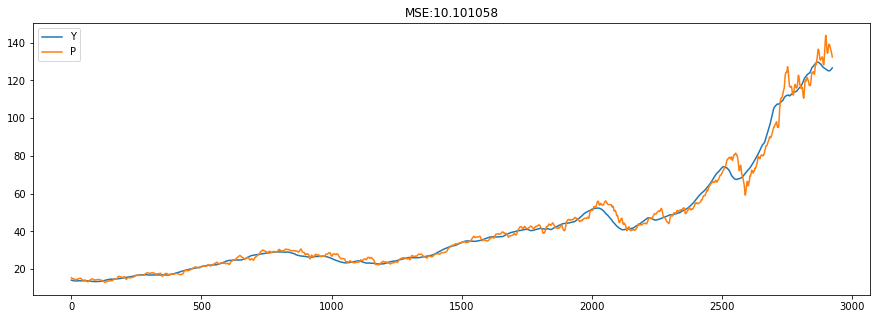

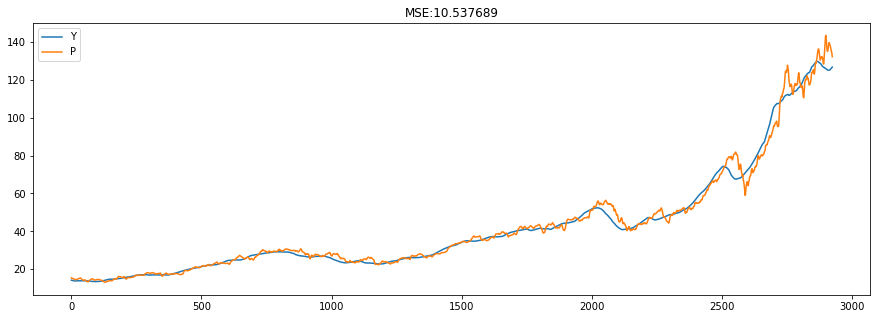

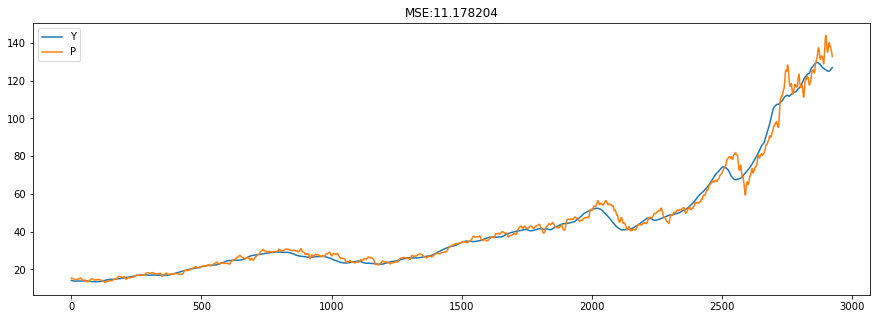

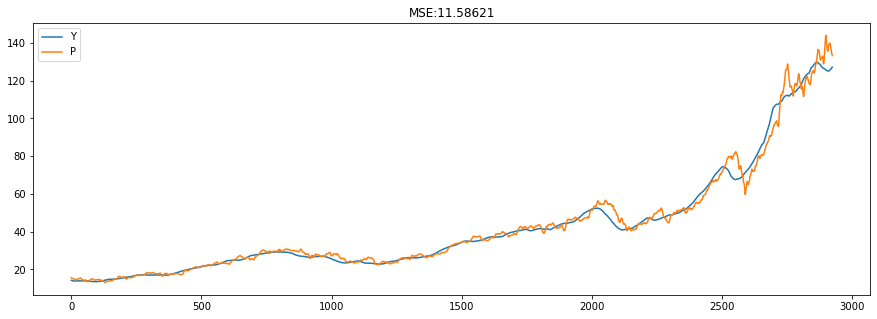

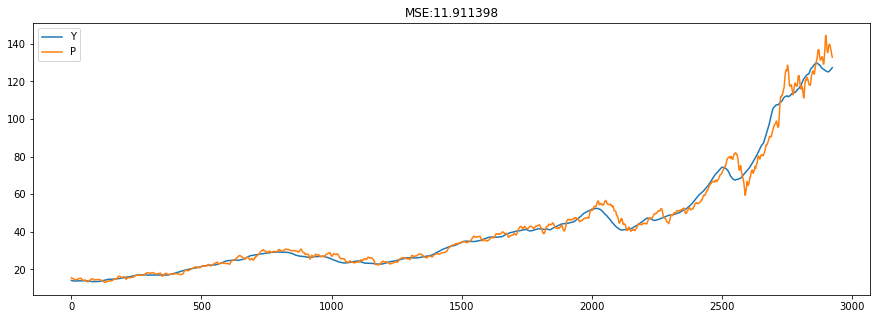

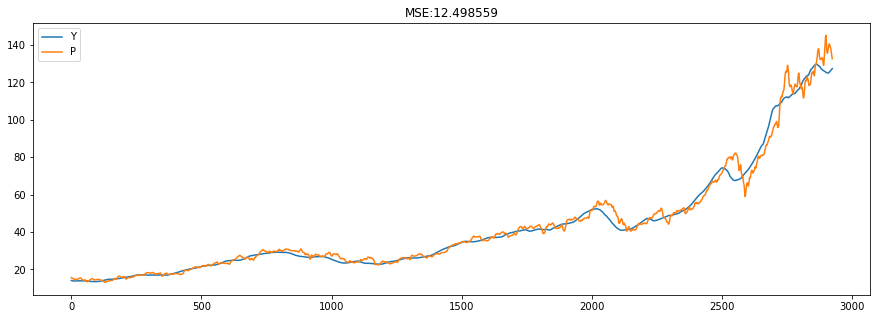

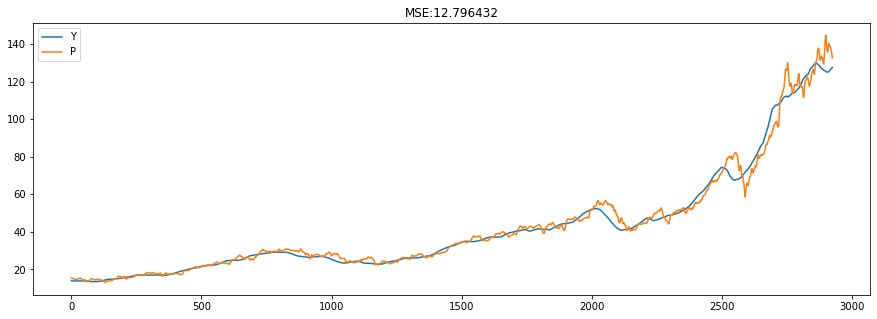

Shape  : (2925, 60, 1)
loss   : 2373.567138671875
MSE    : 4.01935310657177 
RMSE   : 2.004832438527412 
NMSE   : 0.017246027018067364 
DS     : 0.04144729344729345 
WDS    : 0.0003565390946800643 
Samples: 2925


In [2151]:
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

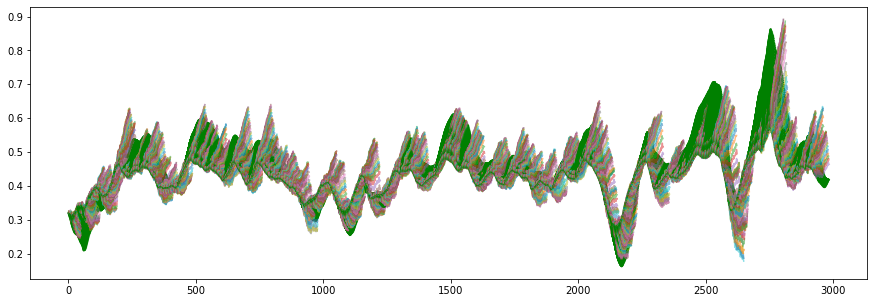

In [2152]:
rrr=0
shiftff=100
# plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],lookAhead)
plotMultVariate(vy,predictions,lookAhead)
# plotVisual(vy,predictions,lookAhead,0.001)

In [2153]:
benchmarker.to_csv("R"+str(counter)+".csv")
counter+=1
counter
benchmarker.sort_values(["MSE","Symmetry"])

Model Stock 1-Shot InWindow OutWindow     T_MSE    T_RMSE    T_NMSE  \
2     TFENC  AAPL  False       60        60  0.004932  0.070231  0.046599   
0  RepeatBL  AAPL    NaN       60        60  0.011423  0.106878  0.070915   
1   ShiftBL  AAPL    NaN       60        60  0.028671  0.169324  0.112349   

  T_Symmetry T_Normed Symmetry       MSE      RMSE      NMSE  Symmetry  \
2   0.035855           0.02379  0.001708  0.041327  0.058957 -0.041447   
0  -0.196233         -0.130203  0.004062  0.063737  0.090929 -0.494872   
1  -0.213934         -0.141948  0.010188  0.100935  0.143995 -0.537949   

  Normed Symmetry  
2       -0.059129  
0       -0.705992  
1       -0.767446

### Simple-RNN

Finding Params

In [993]:
# tf.keras.backend.clear_session()
# def RNN_model(hp=None):
#     M = Sequential()
# #     hp_units = hp.Int('units', min_value=400, max_value=512, step=32)
#     hp_units=400  
#     M.add(Input(shape=trainx.shape[1:]))
#     M.add(LayerNormalization(axis=1))
#     M.add(SimpleRNN(hp_units, return_sequences=True))
#     M.add(LeakyReLU())
#     M.add(SimpleRNN(hp_units))
#     M.add(LeakyReLU())
#     M.add(Dense(1))
#     hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001,0.0001,0.00001,0.000001])
# #     hp_learning_rate=0.000001
#     M.compile(loss="huber",optimizer=SGD(lr=hp_learning_rate, momentum=0.9),metrics=["mae"])
#     return M
# # model=RNN_model()
# # history=model.fit(trainx, trainy,shuffle=True, batch_size=75,validation_data=(vx,vy),epochs=1000,callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=3))  
# tuner = kt.RandomSearch (RNN_model, objective='val_loss',
#                         executions_per_trial=1,
#                          overwrite=True,
#                       max_trials=100,directory='my_dir',
#                      project_name='RNN_model')
# tuner.search(trainx, trainy, epochs=1000, validation_data=(vx,vy),batch_size=75 ,callbacks=callbacks)

In [994]:
# best_hps=tuner.get_best_hyperparameters(num_trials=1)
# best=best_hps[0]
# # best.get('units'), 
# best.get('learning_rate')

In [995]:
tf.keras.backend.clear_session()
def RNN_model(activation='elu',hidden=16,singleshot=False):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    return Sequential([SimpleRNN(hidden,activation, return_sequences=True),
                       Dropout(0.2),
                       SimpleRNN(hidden,activation),
                       Dropout(0.2),
                       Dense(outputSize,activation),
                       Reshape([outputSize, 1])])
model = RNN_model("elu",50,singleshot)
history = compileFit(model,loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),epochs=400,shuffle=True,batch_size=500,patience=50,singleshot=singleshot)
# model.summary()
# model.save("RNN_model")
# model=tf.keras.models.load_model('RNN_model')

Epoch 1/400
21/21 [==============================] - 3s 89ms/step - loss: 0.2089 - val_loss: 0.0026
Epoch 2/400
21/21 [==============================] - 2s 81ms/step - loss: 0.0491 - val_loss: 0.0014
Epoch 3/400
 4/21 [====>.........................] - ETA: 1s - loss: 0.0319

KeyboardInterrupt: 

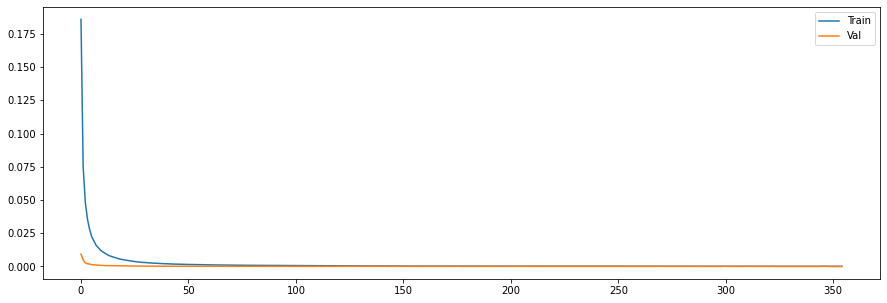

In [996]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [997]:
calculateAccuracy(model,"RNN",singleshot,byDay,benchmarker,period,lookAhead,trainx,trainy,vx,vy)

TypeError: calculateAccuracy() missing 1 required positional argument: 'vy'

In [998]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

ValueError: operands could not be broadcast together with shapes (2557,14,1) (2553,1,1) 

In [999]:
fromN,toN=60,70

<AxesSubplot:>

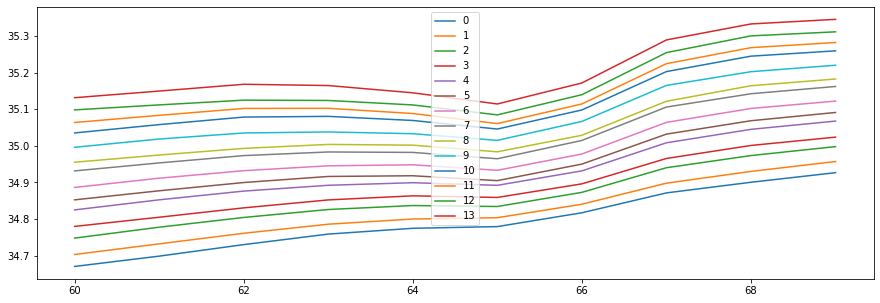

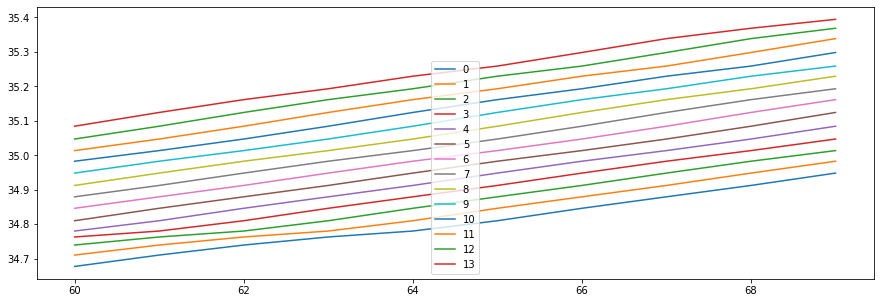

In [831]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()

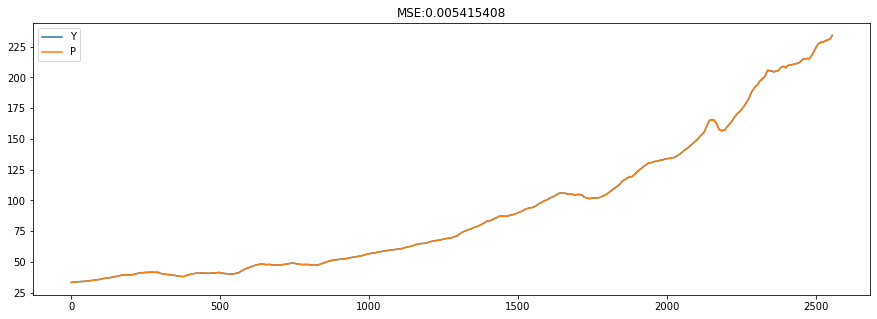

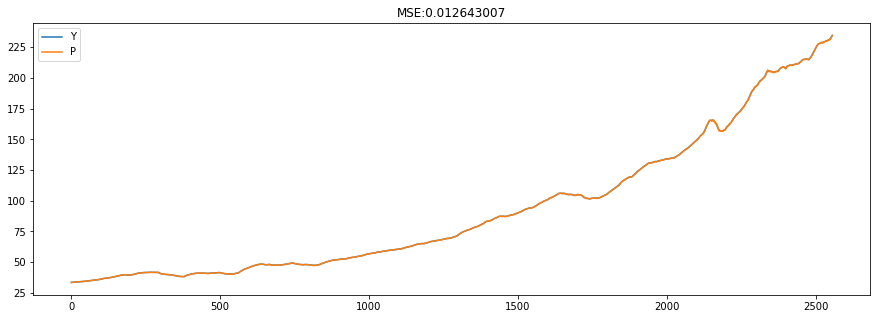

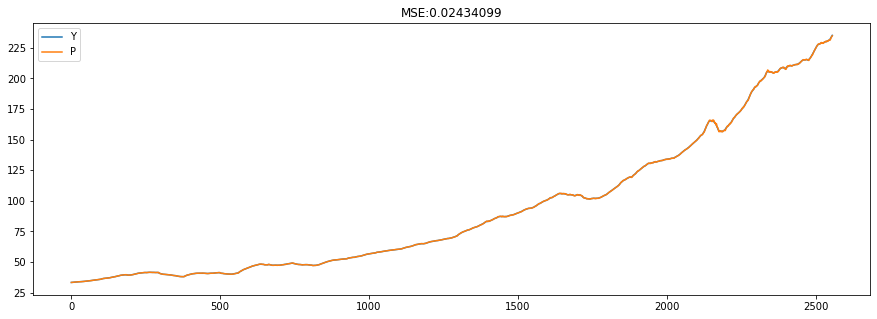

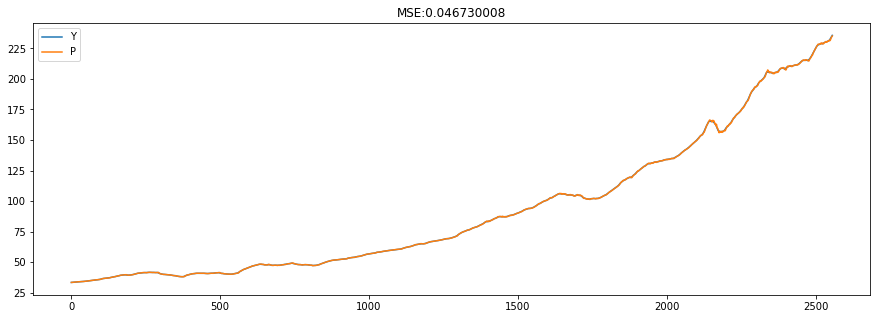

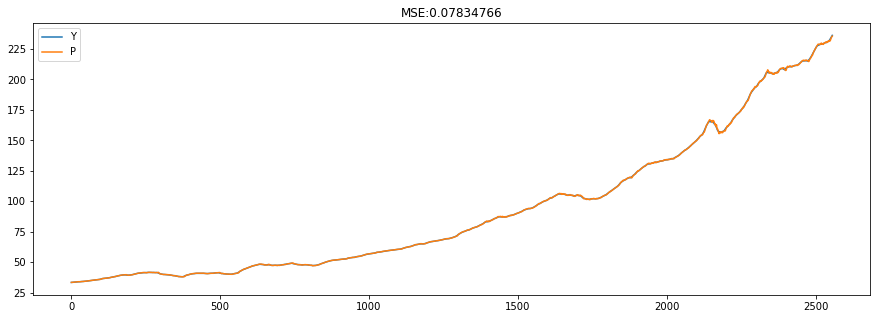

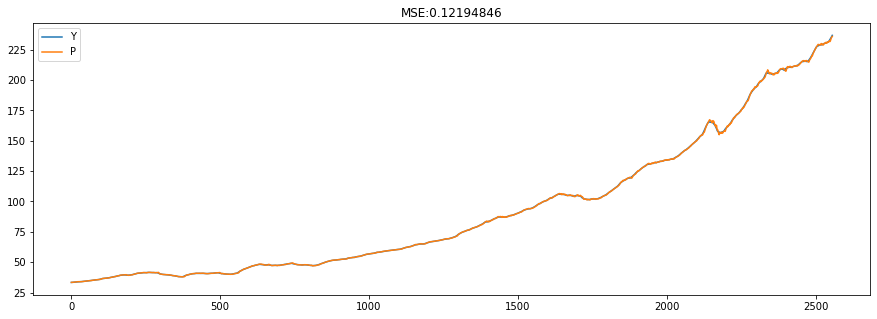

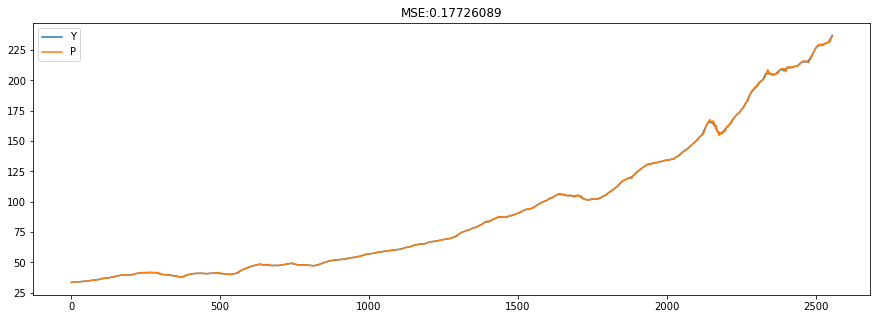

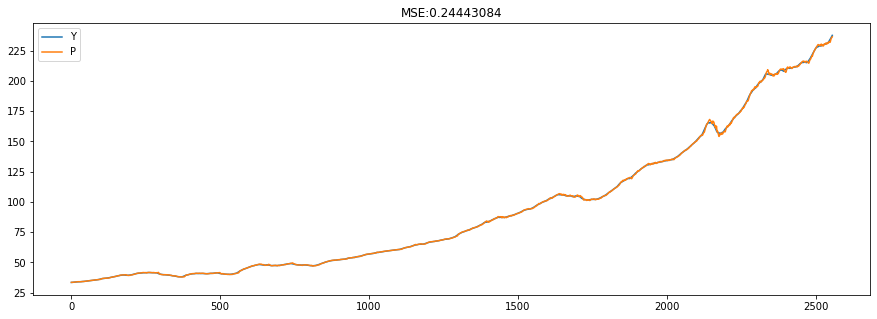

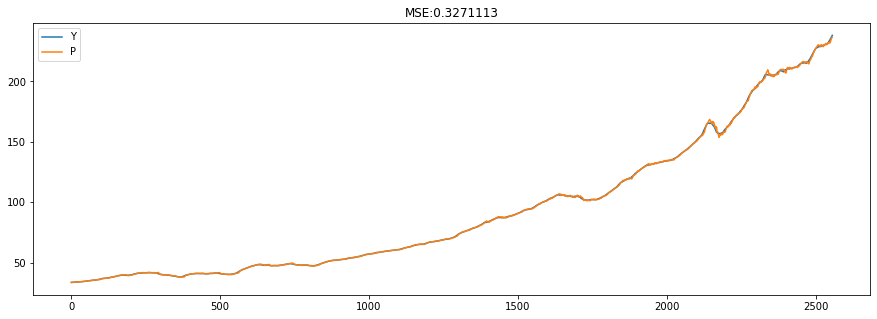

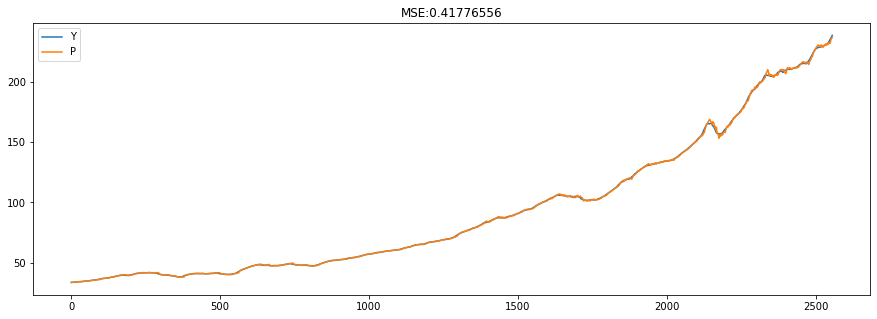

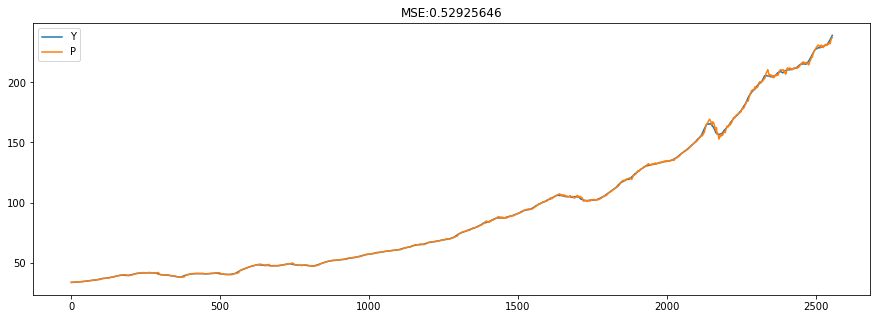

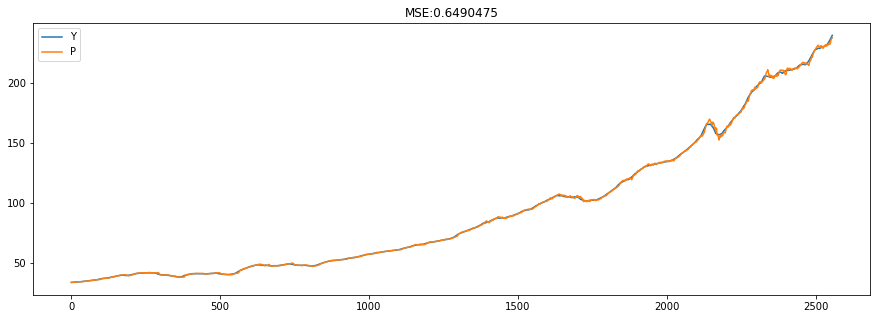

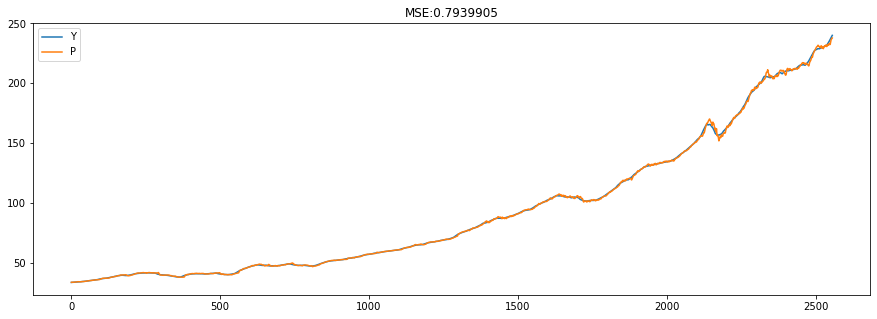

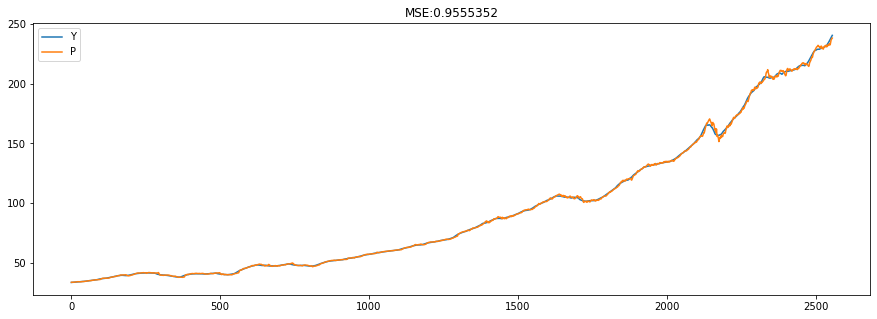

Shape  : (2557, 14, 1)
loss   : 11696.228515625
MSE    : 0.3131303224683878 
RMSE   : 0.559580487926793 
NMSE   : 0.002701878593826176 
DS     : 0.12676685848371416 
WDS    : 0.0006120811370902341 
Samples: 2557


In [832]:
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

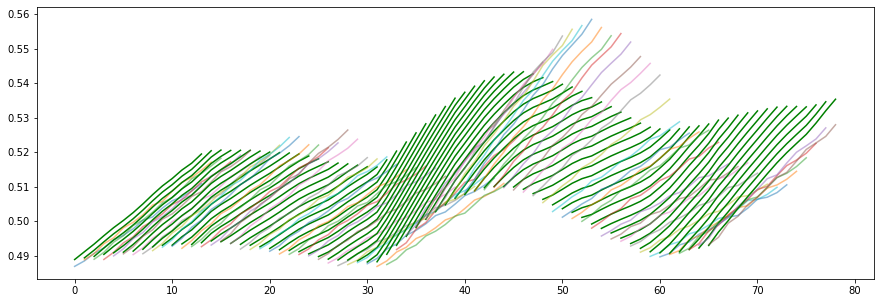

In [833]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],lookAhead)
# plotVisual(vy,predictions,lookAhead,0.001)

### LSTM

In [2231]:
tf.keras.backend.clear_session()
def LSTM_model(activation='elu',hidden=16,singleshot=False):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    return Sequential([LSTM(hidden,activation,return_sequences=True),
                       Dropout(0.5),
                       LSTM(hidden,activation,return_sequences=True),
                       Dropout(0.5),
                       LSTM(hidden,activation),
                       Dense(outputSize,"elu"),
                       Reshape([outputSize, 1])])
model=LSTM_model('elu',100,singleshot)
history=compileFit(model,loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),epochs=400,shuffle=True,batch_size=500,patience=50,singleshot=singleshot)
model.summary()
# model.save("BILSTM_model")
# model=tf.keras.models.load_model('BILSTM_model')

Epoch 1/400


KeyboardInterrupt: 

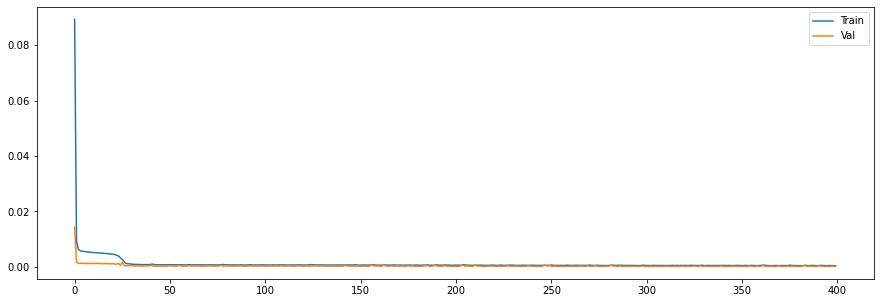

In [543]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [544]:
calculateAccuracy(model,stock,"LSTM",singleshot,byDay,benchmarker,period,lookAhead,trainx,trainy,vx,vy)

<ipython-input-544-c5e2f15b7fef>:12: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),2:4]=[period,lookAhead]
<ipython-input-544-c5e2f15b7fef>:13: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),4:]=np.array([getResults(trainy,predictionsT, False)[:-1],getResults(vy,predictions, False)[:-1]]).flatten()


In [545]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [546]:
fromN,toN=60,70

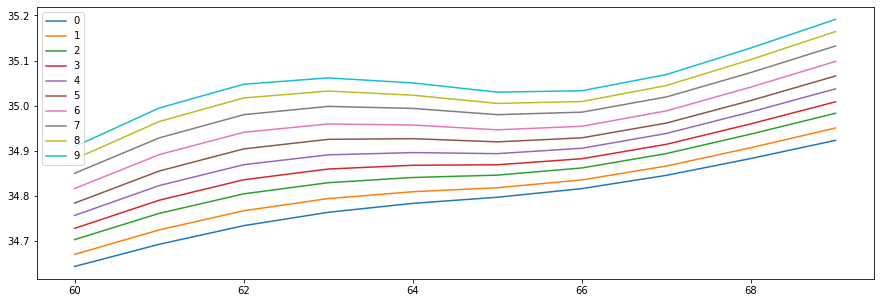

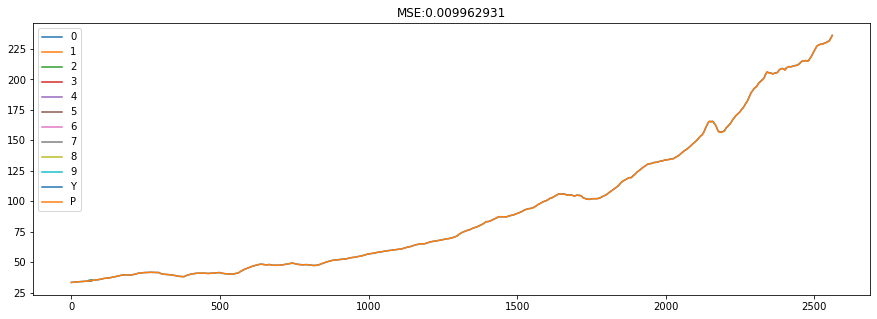

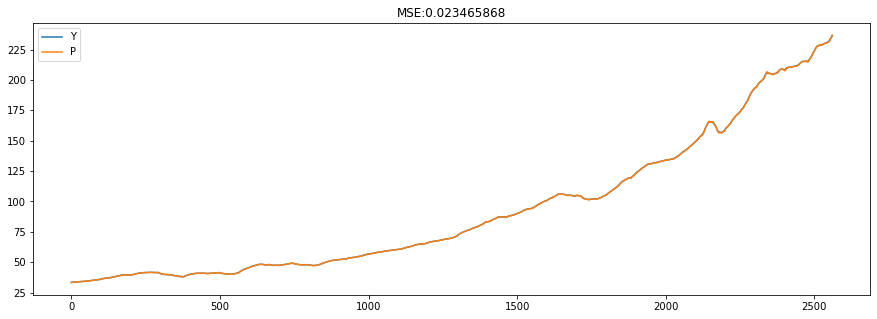

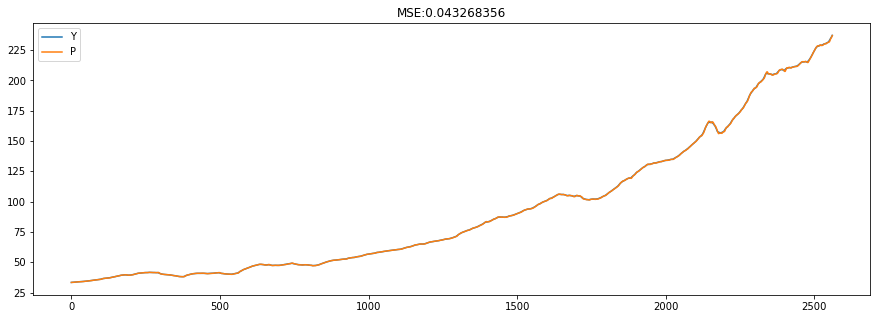

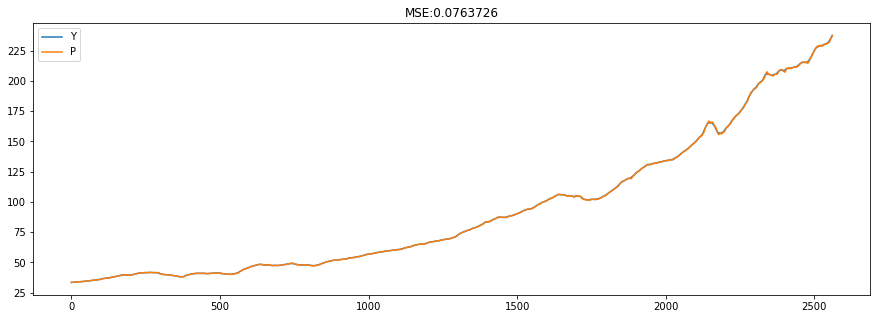

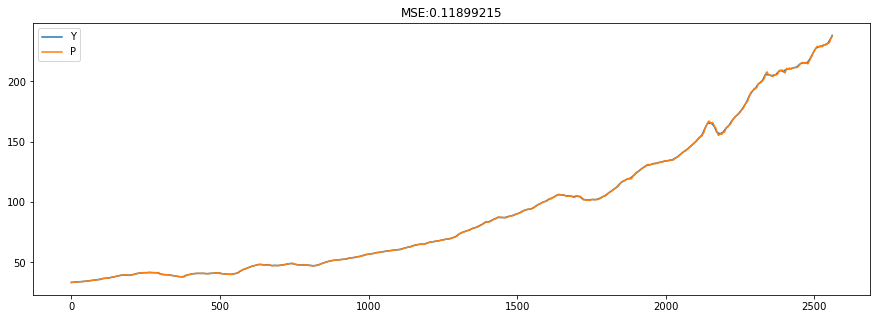

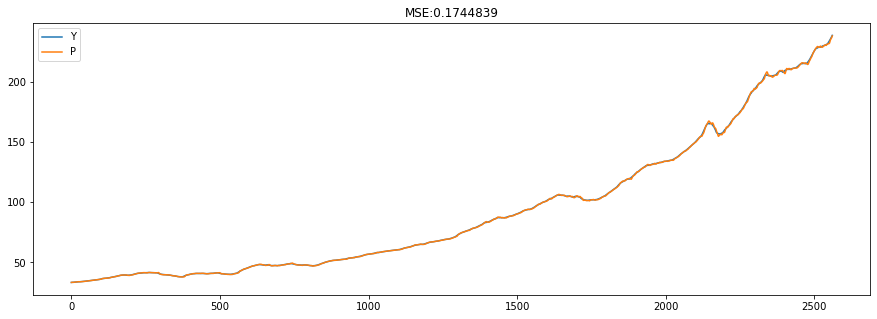

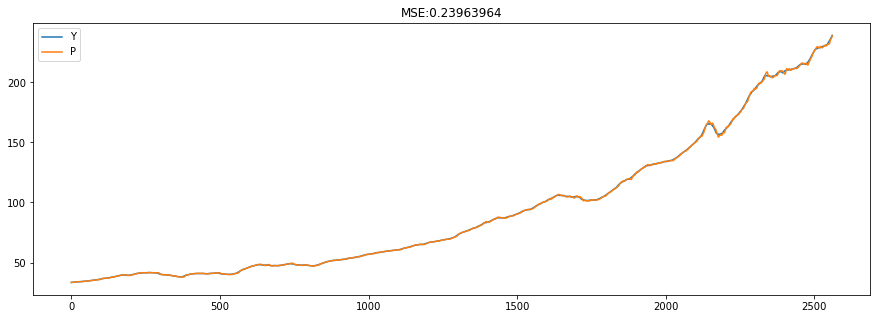

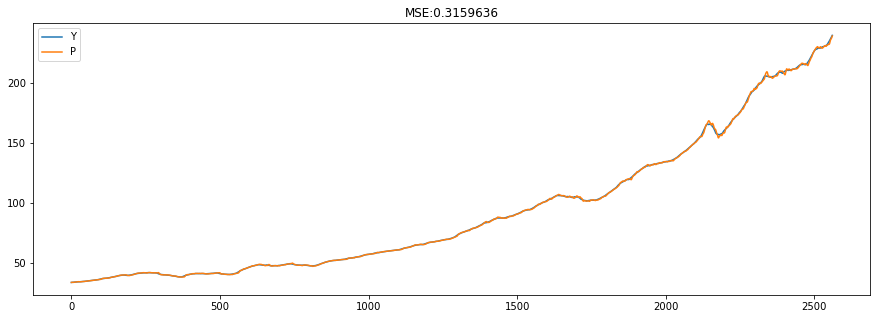

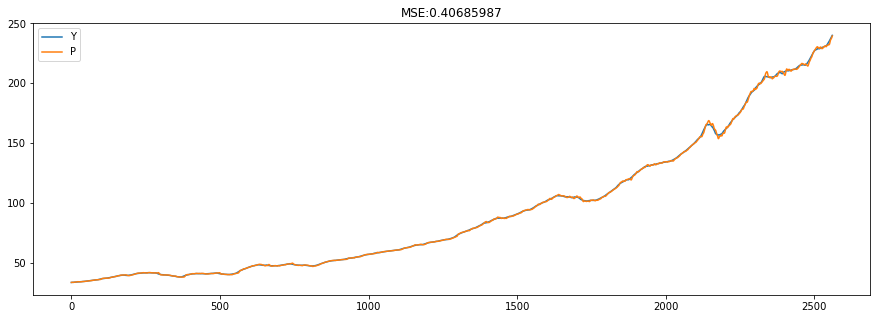

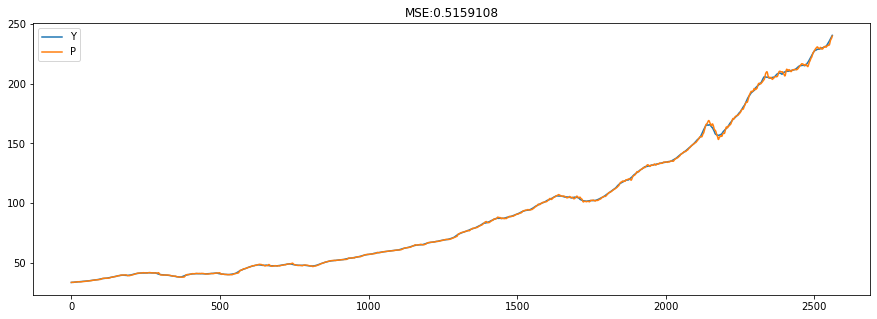

Shape  : (2561, 10, 1)
loss   : 11720.798828125
MSE    : 0.19249201070430585 
RMSE   : 0.43873911462770887 
NMSE   : 0.0021184080711583665 
DS     : 0.3442405310425615 
WDS    : 0.001662131082156195 
Samples: 2561


In [547]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

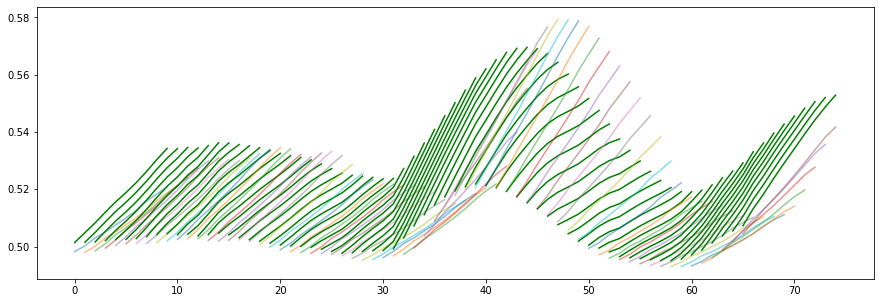

In [548]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],lookAhead)
# plotVisual(vy,predictions,lookAhead,0.001)

### RESLSTM

In [549]:
def RESLSTM(shape, activation='elu',hidden=32,singleshot=False):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    x = Input(shape=shape)
    y = LSTM(hidden,activation, return_sequences=True)(x)
    D = Dropout(0.5)(y)
    D = LSTM(hidden,activation, return_sequences=False)(D)
    D = Dropout(0.5)(y)
    D = Dense(period, activation)(y)
    D = Add()([x, D])
    D = Flatten()(D)
    D = Dense(outputSize)(D)
    out = Reshape([outputSize, 1])(D)
    return tf.keras.models.Model(inputs=x, outputs=out)
model = RESLSTM((period,1),'elu',100,singleshot)
history=compileFit(model,loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),epochs=400,shuffle=True,batch_size=500,patience=50,singleshot=singleshot)
model.summary()
# model.save("RESLSTM")
# model=tf.keras.models.load_model('RESLSTM')
# tf.keras.utils.plot_model(model)

Epoch 1/400
21/21 [==============================] - 2s 31ms/step - loss: 0.3044 - val_loss: 0.0038
Epoch 2/400
21/21 [==============================] - 0s 20ms/step - loss: 0.0052 - val_loss: 6.9217e-04
Epoch 3/400
21/21 [==============================] - 0s 20ms/step - loss: 0.0023 - val_loss: 6.1061e-04
Epoch 4/400
21/21 [==============================] - 0s 21ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 5/400
21/21 [==============================] - 0s 19ms/step - loss: 0.0020 - val_loss: 3.9391e-04
Epoch 6/400
21/21 [==============================] - 0s 20ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 7/400
21/21 [==============================] - 0s 19ms/step - loss: 0.0018 - val_loss: 7.1653e-04
Epoch 8/400
21/21 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 7.7043e-04
Epoch 9/400
21/21 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 3.9506e-04
Epoch 10/400
21/21 [==============================] - 0s 19ms/step - loss: 0

Epoch 148/400
21/21 [==============================] - 0s 21ms/step - loss: 3.8963e-04 - val_loss: 1.6740e-04
Epoch 149/400
21/21 [==============================] - 0s 19ms/step - loss: 3.6691e-04 - val_loss: 1.5176e-04
Epoch 150/400
21/21 [==============================] - 0s 20ms/step - loss: 3.7810e-04 - val_loss: 1.5111e-04
Epoch 151/400
21/21 [==============================] - 0s 21ms/step - loss: 3.5689e-04 - val_loss: 1.9852e-04
Epoch 152/400
21/21 [==============================] - 0s 21ms/step - loss: 4.1080e-04 - val_loss: 1.9429e-04
Epoch 153/400
21/21 [==============================] - 0s 20ms/step - loss: 3.9380e-04 - val_loss: 1.6688e-04
Epoch 154/400
21/21 [==============================] - 0s 21ms/step - loss: 3.8619e-04 - val_loss: 1.6108e-04
Epoch 155/400
21/21 [==============================] - 0s 20ms/step - loss: 3.7295e-04 - val_loss: 1.5006e-04
Epoch 156/400
21/21 [==============================] - 0s 20ms/step - loss: 3.6617e-04 - val_loss: 1.5029e-04
Epoch 157/

21/21 [==============================] - 0s 22ms/step - loss: 3.1249e-04 - val_loss: 1.7232e-04
Epoch 297/400
21/21 [==============================] - 0s 20ms/step - loss: 3.3756e-04 - val_loss: 1.5891e-04
Epoch 298/400
21/21 [==============================] - 0s 20ms/step - loss: 3.3531e-04 - val_loss: 1.4016e-04
Epoch 299/400
21/21 [==============================] - 0s 20ms/step - loss: 3.3649e-04 - val_loss: 1.3396e-04
Epoch 300/400
21/21 [==============================] - 0s 20ms/step - loss: 3.2903e-04 - val_loss: 1.7454e-04
Epoch 301/400
21/21 [==============================] - 0s 22ms/step - loss: 3.4850e-04 - val_loss: 1.7460e-04
Epoch 302/400
21/21 [==============================] - 0s 20ms/step - loss: 3.4141e-04 - val_loss: 1.3509e-04
Epoch 303/400
21/21 [==============================] - 0s 19ms/step - loss: 3.1467e-04 - val_loss: 1.4813e-04
Epoch 304/400
21/21 [==============================] - 0s 21ms/step - loss: 3.3225e-04 - val_loss: 1.6028e-04
Epoch 305/400
21/21 [===

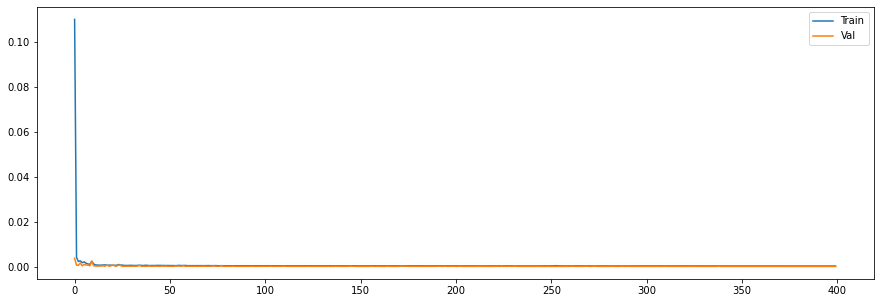

In [550]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [551]:
calculateAccuracy(model,stock,"RESLSTM",singleshot,byDay,benchmarker,period,lookAhead,trainx,trainy,vx,vy)

<ipython-input-551-c5e2f15b7fef>:12: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),2:4]=[period,lookAhead]
<ipython-input-551-c5e2f15b7fef>:13: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),4:]=np.array([getResults(trainy,predictionsT, False)[:-1],getResults(vy,predictions, False)[:-1]]).flatten()


In [552]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [553]:
fromN,toN=60,70

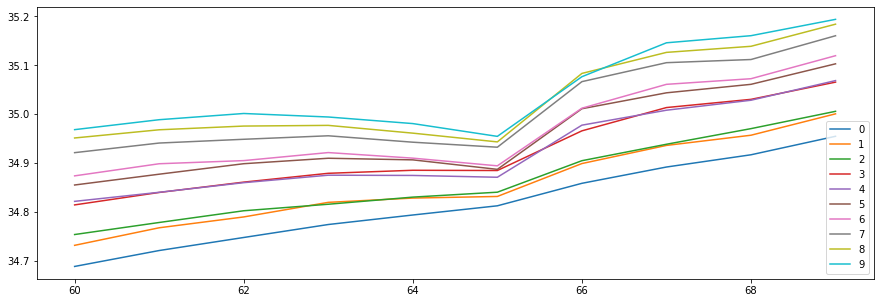

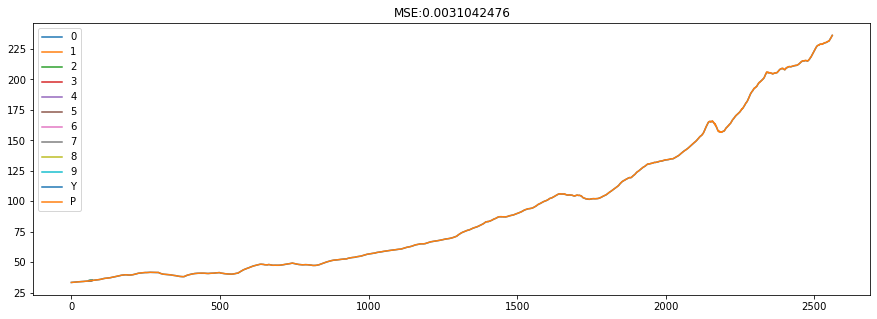

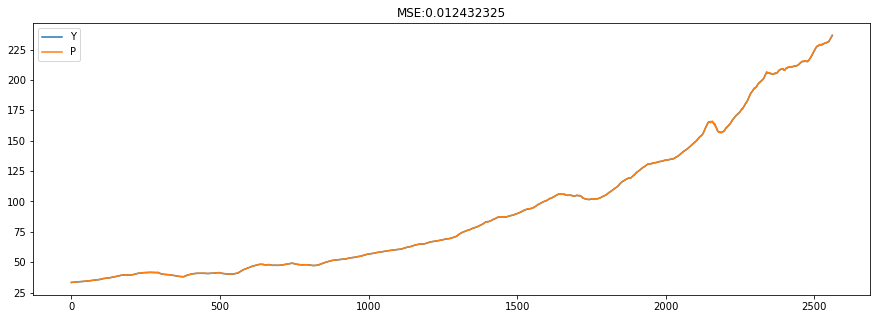

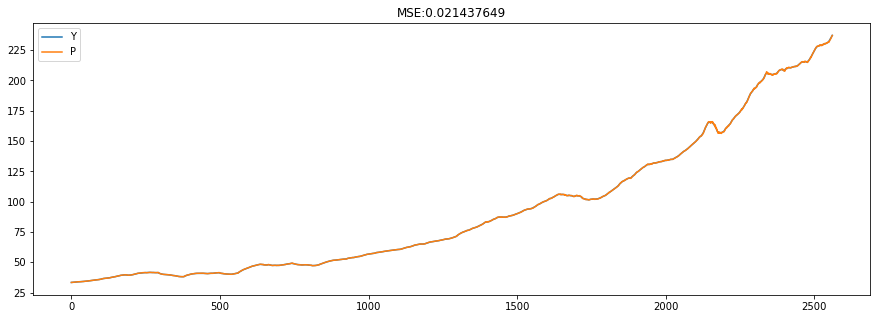

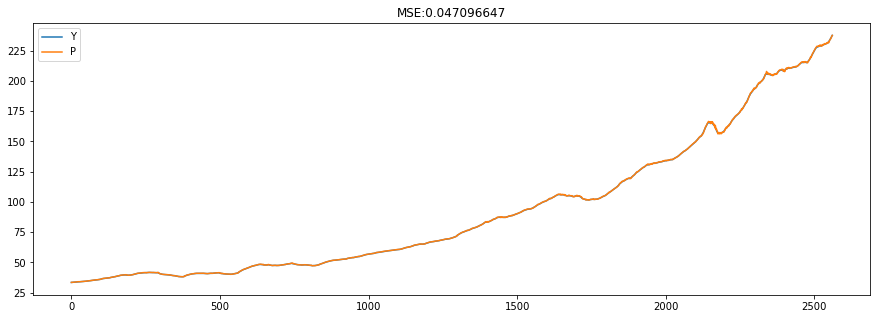

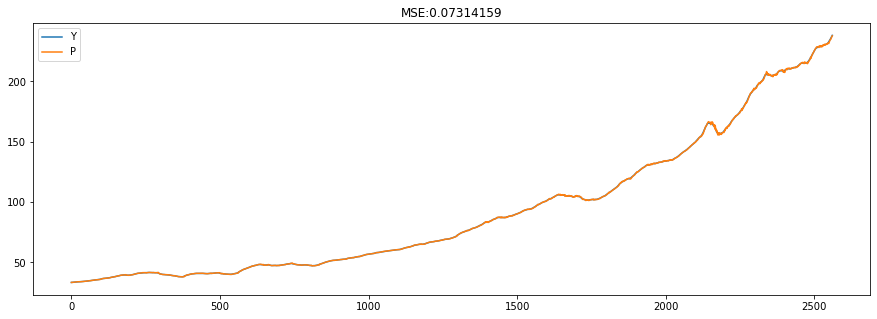

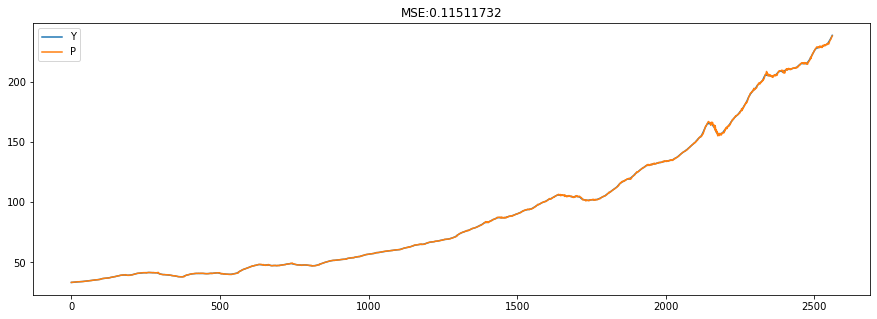

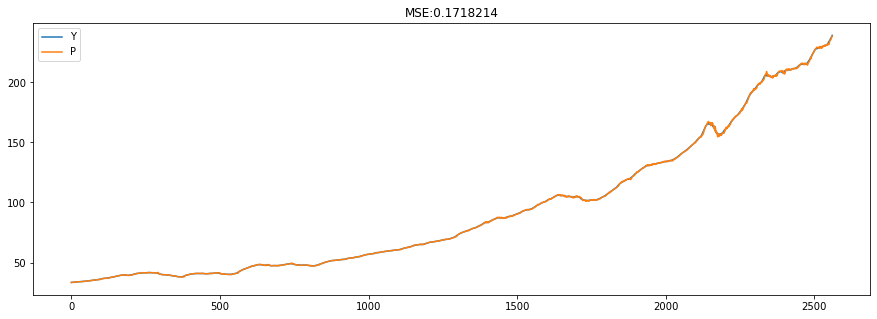

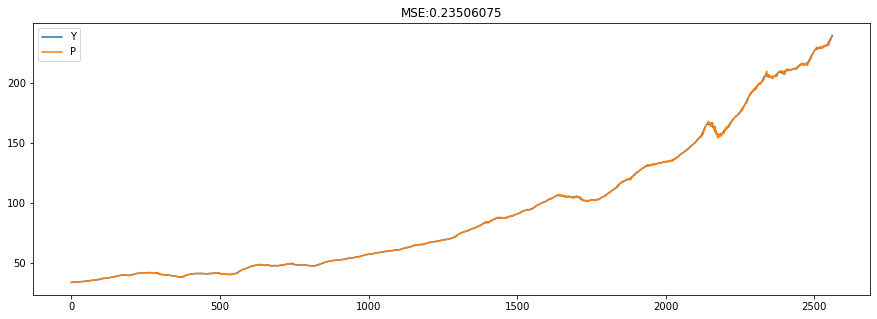

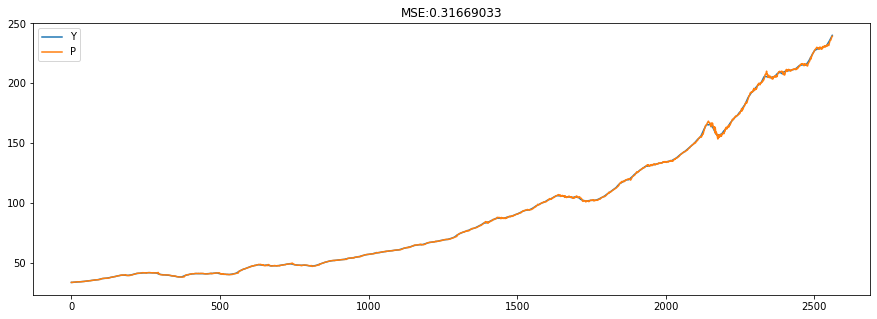

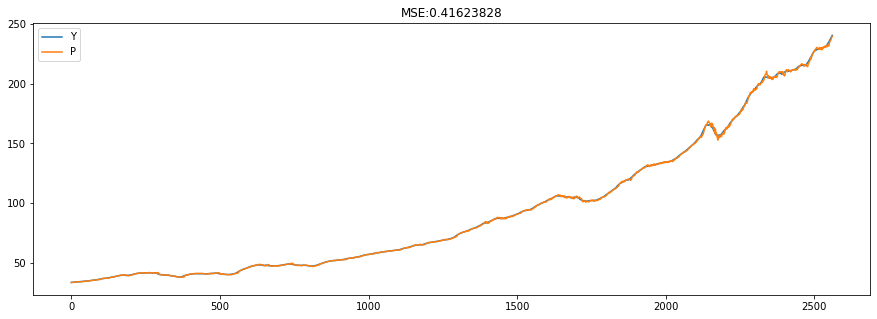

Shape  : (2561, 10, 1)
loss   : 11720.4150390625
MSE    : 0.14121409580012262 
RMSE   : 0.37578464018653374 
NMSE   : 0.0018144386681000512 
DS     : -0.0843420538852011 
WDS    : -0.00040723719798745246 
Samples: 2561


In [554]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

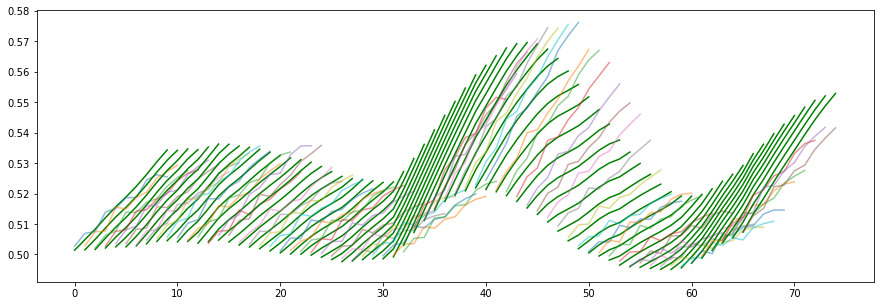

In [555]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],lookAhead)
# plotVisual(vy,predictions,lookAhead,0.001)

### BILSTM

In [556]:
tf.keras.backend.clear_session()
def BILSTM_model(activation='elu',hidden=32,singleshot=False):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    return Sequential([Bidirectional(LSTM(hidden,activation,return_sequences=True)),
                       Dropout(0.5),
                       Bidirectional(LSTM(hidden, activation)),
                       Dropout(0.5),
                       Dense(outputSize,"linear"),
                       Reshape([outputSize, 1])])
model=BILSTM_model('elu',100,singleshot)
history=compileFit(model,loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),shuffle=True,batch_size=500,patience=50,singleshot=singleshot)
model.summary()
# model.save("BILSTM_model")
# model=tf.keras.models.load_model('BILSTM_model')


Epoch 1/400
21/21 [==============================] - 6s 90ms/step - loss: 0.5518 - val_loss: 0.0032
Epoch 2/400
21/21 [==============================] - 1s 70ms/step - loss: 0.0207 - val_loss: 0.0034
Epoch 3/400
21/21 [==============================] - 1s 67ms/step - loss: 0.0119 - val_loss: 0.0014
Epoch 4/400
21/21 [==============================] - 1s 68ms/step - loss: 0.0102 - val_loss: 0.0012
Epoch 5/400
21/21 [==============================] - 1s 67ms/step - loss: 0.0091 - val_loss: 0.0014
Epoch 6/400
21/21 [==============================] - 1s 66ms/step - loss: 0.0085 - val_loss: 0.0012
Epoch 7/400
21/21 [==============================] - 1s 65ms/step - loss: 0.0078 - val_loss: 0.0015
Epoch 8/400
21/21 [==============================] - 1s 67ms/step - loss: 0.0074 - val_loss: 0.0013
Epoch 9/400
21/21 [==============================] - 1s 66ms/step - loss: 0.0070 - val_loss: 0.0012
Epoch 10/400
21/21 [==============================] - 1s 66ms/step - loss: 0.0066 - val_loss: 9.7991

Epoch 69/400
21/21 [==============================] - 1s 66ms/step - loss: 5.7113e-04 - val_loss: 1.8252e-04
Epoch 70/400
21/21 [==============================] - 1s 65ms/step - loss: 5.6338e-04 - val_loss: 1.7707e-04
Epoch 71/400
21/21 [==============================] - 1s 67ms/step - loss: 5.6210e-04 - val_loss: 2.0278e-04
Epoch 72/400
21/21 [==============================] - 1s 67ms/step - loss: 5.6581e-04 - val_loss: 1.7394e-04
Epoch 73/400
21/21 [==============================] - 1s 66ms/step - loss: 5.4770e-04 - val_loss: 1.7856e-04
Epoch 74/400
21/21 [==============================] - 1s 72ms/step - loss: 5.4970e-04 - val_loss: 1.9194e-04
Epoch 75/400
21/21 [==============================] - 1s 64ms/step - loss: 5.3746e-04 - val_loss: 2.0066e-04
Epoch 76/400
21/21 [==============================] - 1s 69ms/step - loss: 5.6991e-04 - val_loss: 1.8949e-04
Epoch 77/400
21/21 [==============================] - 1s 65ms/step - loss: 5.5783e-04 - val_loss: 1.9426e-04
Epoch 78/400
21/21 

Epoch 144/400
21/21 [==============================] - 1s 69ms/step - loss: 4.8482e-04 - val_loss: 1.8691e-04
Epoch 145/400
21/21 [==============================] - 1s 64ms/step - loss: 4.9415e-04 - val_loss: 2.1950e-04
Epoch 146/400
21/21 [==============================] - 1s 64ms/step - loss: 5.1228e-04 - val_loss: 1.6293e-04
Epoch 147/400
21/21 [==============================] - 1s 69ms/step - loss: 4.6662e-04 - val_loss: 1.6197e-04
Epoch 148/400
21/21 [==============================] - 1s 63ms/step - loss: 4.9336e-04 - val_loss: 1.7303e-04
Epoch 149/400
21/21 [==============================] - 1s 64ms/step - loss: 4.9014e-04 - val_loss: 1.6415e-04
Epoch 150/400
21/21 [==============================] - 1s 65ms/step - loss: 4.8265e-04 - val_loss: 1.6132e-04
Epoch 151/400
21/21 [==============================] - 1s 67ms/step - loss: 4.6687e-04 - val_loss: 1.7245e-04
Epoch 152/400
21/21 [==============================] - 1s 67ms/step - loss: 4.8041e-04 - val_loss: 1.6553e-04
Epoch 153/

21/21 [==============================] - 1s 60ms/step - loss: 4.1835e-04 - val_loss: 1.4989e-04
Epoch 293/400
21/21 [==============================] - 1s 69ms/step - loss: 4.2781e-04 - val_loss: 1.3572e-04
Epoch 294/400
21/21 [==============================] - 1s 61ms/step - loss: 4.2158e-04 - val_loss: 1.4013e-04
Epoch 295/400
21/21 [==============================] - 1s 63ms/step - loss: 3.9633e-04 - val_loss: 1.7792e-04
Epoch 296/400
21/21 [==============================] - 1s 66ms/step - loss: 4.3748e-04 - val_loss: 1.3475e-04
Epoch 297/400
21/21 [==============================] - 1s 66ms/step - loss: 4.0739e-04 - val_loss: 1.3982e-04
Epoch 298/400
21/21 [==============================] - 1s 63ms/step - loss: 4.1689e-04 - val_loss: 1.5116e-04
Epoch 299/400
21/21 [==============================] - 1s 60ms/step - loss: 4.0154e-04 - val_loss: 1.3550e-04
Epoch 300/400
21/21 [==============================] - 1s 66ms/step - loss: 4.1126e-04 - val_loss: 1.4796e-04
Epoch 301/400
21/21 [===

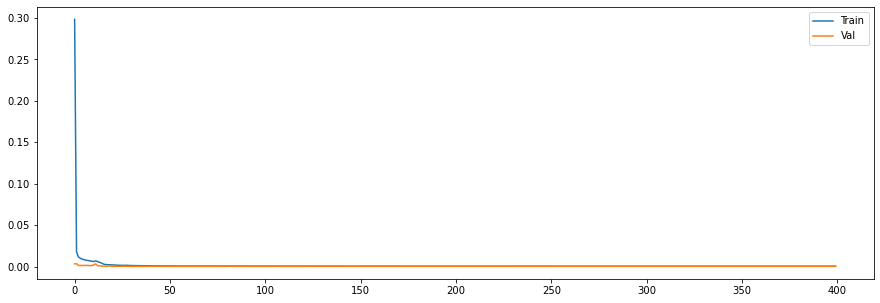

In [557]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [558]:
calculateAccuracy(model,stock,"BILSTM",singleshot,byDay,benchmarker,period,lookAhead,trainx,trainy,vx,vy)

<ipython-input-558-2a7742cb59d1>:12: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),2:4]=[period,lookAhead]
<ipython-input-558-2a7742cb59d1>:13: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),4:]=np.array([getResults(trainy,predictionsT, False)[:-1],getResults(vy,predictions, False)[:-1]]).flatten()


In [559]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [560]:
fromN,toN=60,70

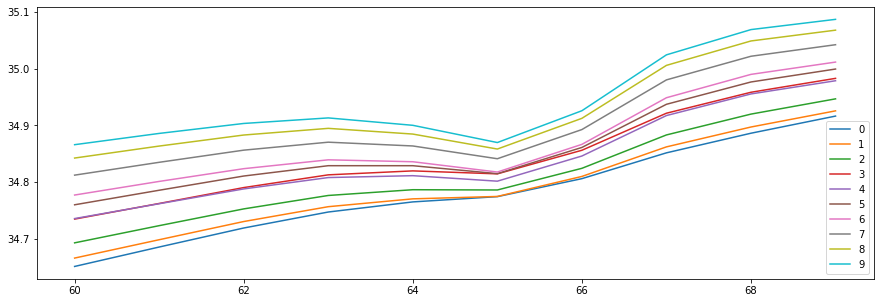

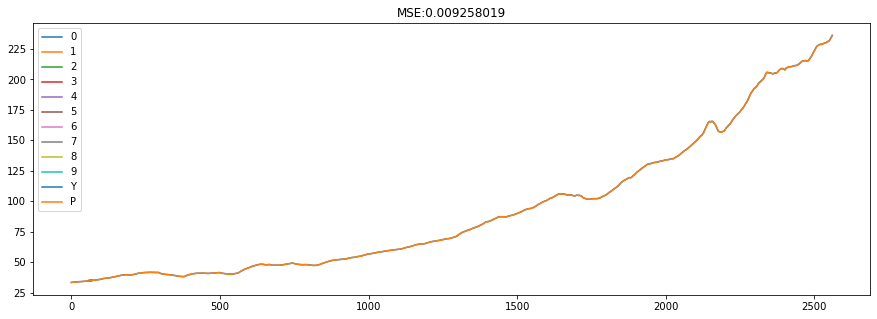

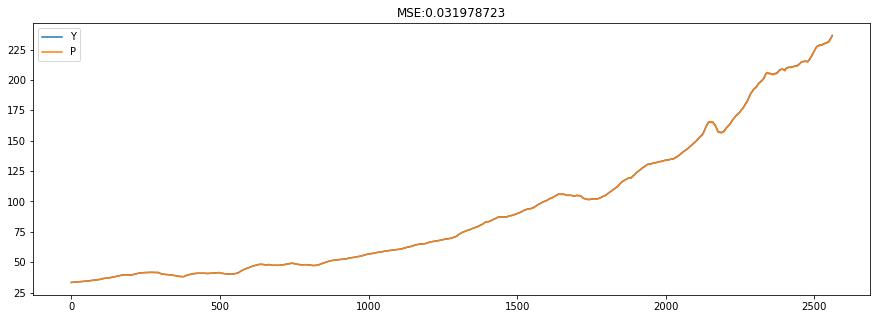

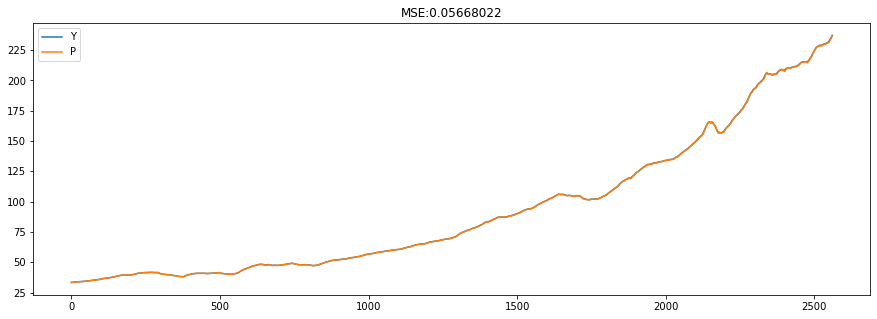

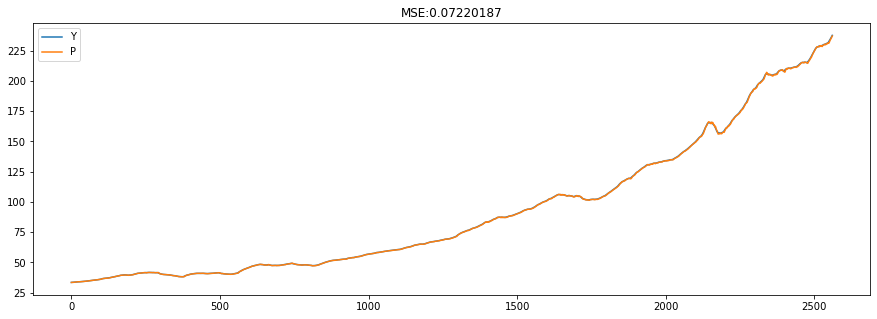

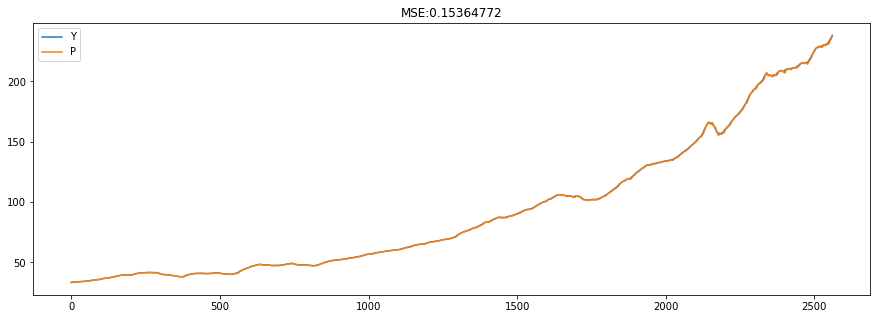

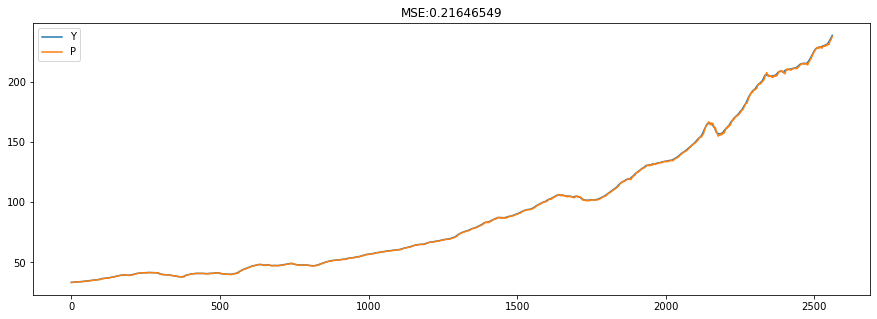

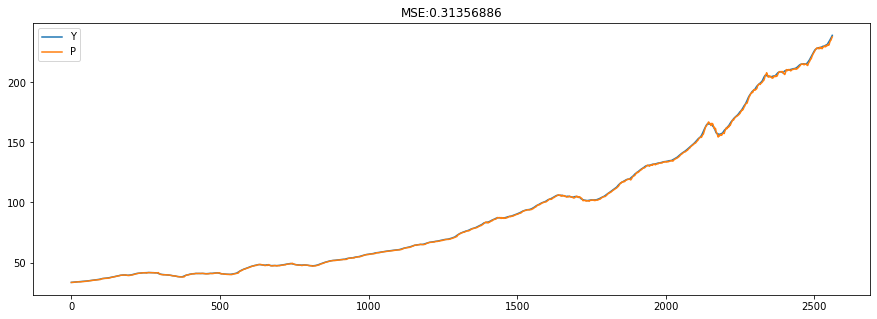

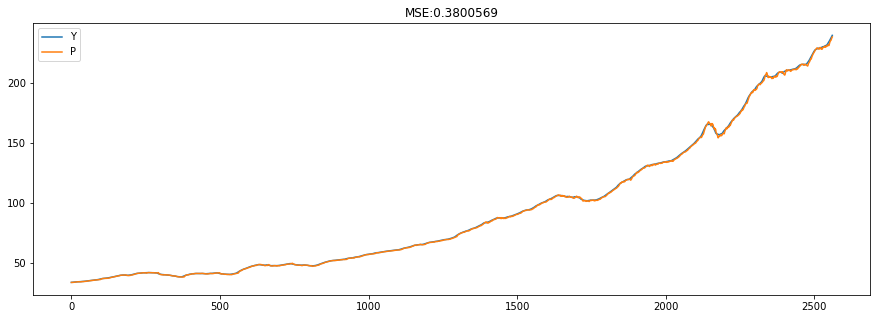

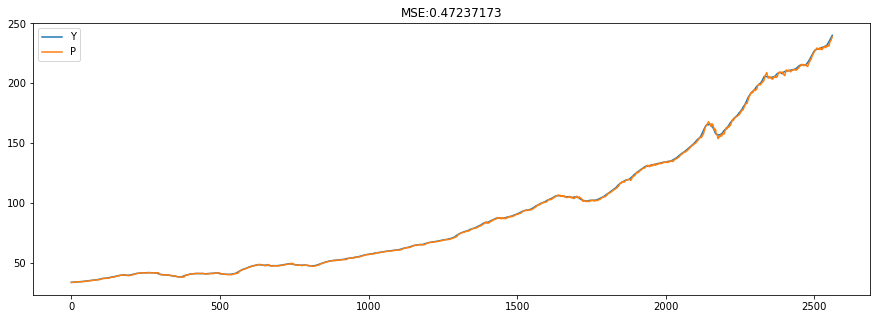

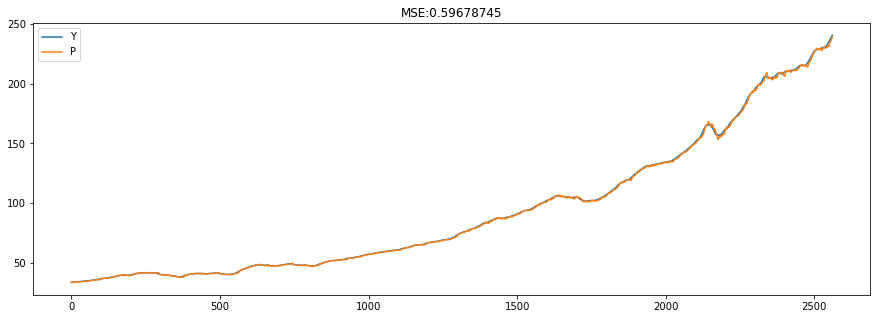

Shape  : (2561, 10, 1)
loss   : 11721.974609375
MSE    : 0.23030184877768292 
RMSE   : 0.4798977482523573 
NMSE   : 0.0023171384299555094 
DS     : 0.7644670050761422 
WDS    : 0.003691152713980715 
Samples: 2561


In [561]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

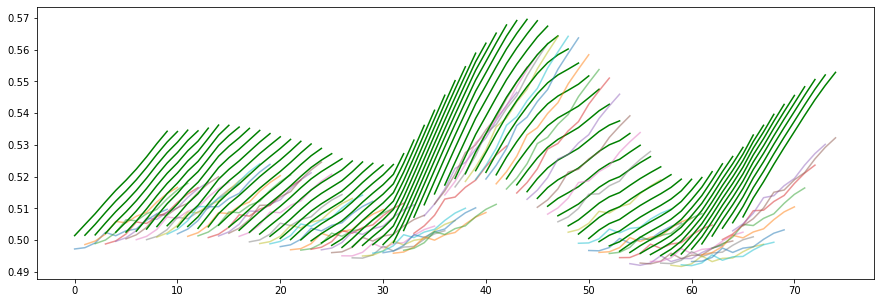

In [562]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],lookAhead)
# plotVisual(vy,predictions,lookAhead,0.001)

### ConvLSTM

In [1059]:
tf.keras.backend.clear_session()
def CovLSTM_model(activation='elu', hidden=32, singleshot=False):
    if singleshot: outputSize = 1
    else: outputSize = lookAhead
    return Sequential([Conv1D(filters=64,kernel_size=lookAhead,strides=1,padding="causal",activation=activation),
                       LSTM(hidden, activation, return_sequences=False),
                       Dropout(0.5),
                       Dense(outputSize, activation),
                       Reshape([outputSize, 1])])
model = CovLSTM_model('elu', 100, singleshot)
history = compileFit(model, loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), shuffle=True, batch_size=500,patience=30, singleshot=singleshot)
# model.save("CovLSTM_model")
# model=tf.keras.models.load_model('CovLSTM_model')

Epoch 1/400
21/21 [==============================] - 4s 113ms/step - loss: 0.0820 - val_loss: 0.0022
Epoch 2/400
21/21 [==============================] - 2s 99ms/step - loss: 0.0115 - val_loss: 7.7014e-04
Epoch 3/400
21/21 [==============================] - 2s 96ms/step - loss: 0.0089 - val_loss: 5.3222e-04
Epoch 4/400
21/21 [==============================] - 2s 99ms/step - loss: 0.0078 - val_loss: 3.0759e-04
Epoch 5/400
21/21 [==============================] - 2s 95ms/step - loss: 0.0068 - val_loss: 3.7458e-04
Epoch 6/400
21/21 [==============================] - 2s 96ms/step - loss: 0.0063 - val_loss: 2.5890e-04
Epoch 7/400
21/21 [==============================] - 2s 100ms/step - loss: 0.0057 - val_loss: 1.3931e-04
Epoch 8/400
21/21 [==============================] - 2s 98ms/step - loss: 0.0053 - val_loss: 9.9491e-05
Epoch 9/400
21/21 [==============================] - 2s 98ms/step - loss: 0.0050 - val_loss: 1.7131e-04
Epoch 10/400
21/21 [==============================] - 2s 97ms/step

KeyboardInterrupt: 

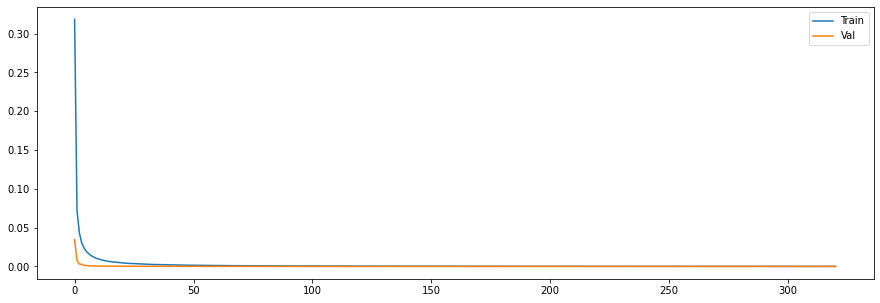

In [1060]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [1061]:
# if singleshot: 
#     predictionsT=StepForwardPredictions(trainx,model,lookAhead)
#     predictions=StepForwardPredictions(vx,model,lookAhead)
# else: 
#     predictionsT=model.predict(trainx)
#     predictions=model.predict(vx)
# benchmarker.loc[benchmarker.index.max()+1]=0
# benchmarker.loc[benchmarker.index.max()]["Model"]="CONVLSTM"
# benchmarker.loc[benchmarker.index.max()]["1-Shot"]=singleshot
# if byDay: benchmarker.loc[benchmarker.index.max(),2:]=np.array([evaluatePredictions(trainy,predictionsT),evaluatePredictions(vy,predictions)]).reshape(-1,order='C')
# else: 
#     benchmarker.loc[benchmarker.index.max(),2:4]=[period,lookAhead]
#     benchmarker.loc[benchmarker.index.max(),4:]=np.array([getResults(trainy,predictionsT, False)[:-1],getResults(vy,predictions, False)[:-1]]).flatten()
calculateAccuracy(model,stock,"CONVLSTM",singleshot,byDay,benchmarker,period,lookAhead,trainx,trainy,vx,vy)

<ipython-input-1032-f95d9c143d5c>:14: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),3:5]=[period,lookAhead]
<ipython-input-1032-f95d9c143d5c>:15: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),5:]=np.array([getResults(trainy,predictionsT, False)[:-1],getResults(vy,predictions, False)[:-1]]).flatten()


Model Stock 1-Shot InWindow OutWindow     T_MSE    T_RMSE    T_NMSE  \
0  RepeatBL  MSFT    NaN       60         3  0.000056  0.007463  0.012081   
1   ShiftBL  MSFT    NaN       60         3  0.000048  0.006927  0.011214   
2     TFENC  MSFT  False       60         3  0.000075  0.008656  0.014013   
3  CONVLSTM  MSFT  False       60         3  0.000046  0.006807  0.011019   

  T_Symmetry T_Normed Symmetry       MSE      RMSE      NMSE  Symmetry  \
0  -0.248637         -0.402508  0.000021  0.004574  0.024755 -0.633895   
1   -0.24498         -0.396588  0.000018  0.004251  0.023005 -0.638856   
2   0.784439          1.269896   0.00006  0.007733  0.041848  0.876224   
3   0.025043          0.040542  0.000019  0.004329  0.023427 -0.099099   

  Normed Symmetry  
0       -3.430505  
1       -3.457355  
2         4.74194  
3       -0.536303

In [1062]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [1063]:
fromN,toN=60,70

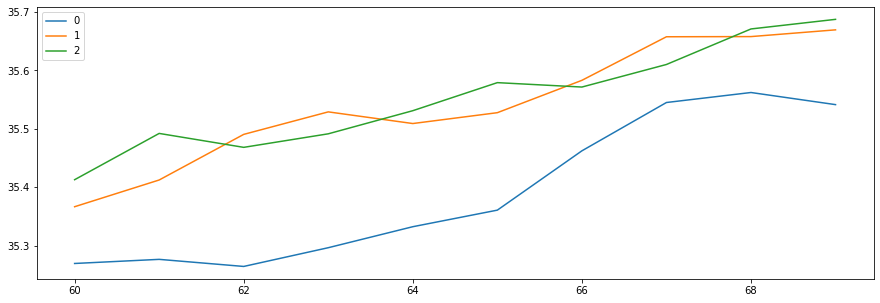

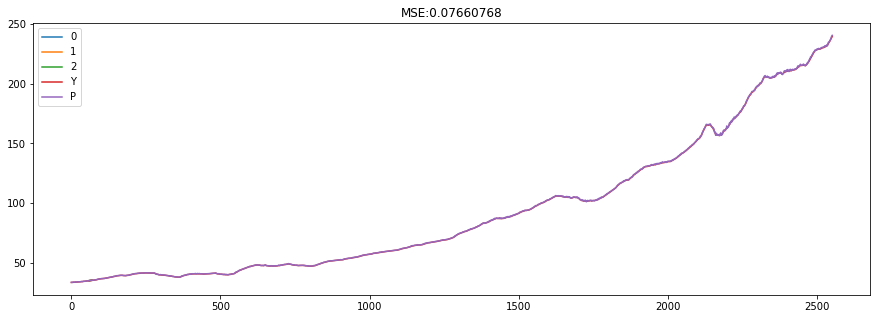

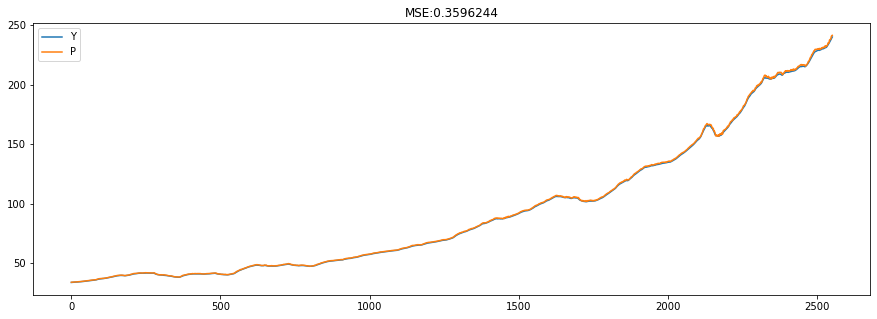

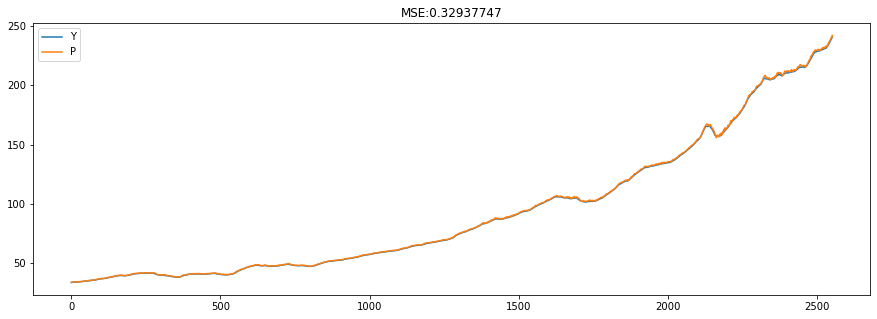

Shape  : (2553, 3, 1)
loss   : 11833.5546875
MSE    : 0.25520313682096785 
RMSE   : 0.5051763423013471 
NMSE   : 0.002443109015717007 
DS     : -0.8762240501370936 
WDS    : -0.004237551716942893 
Samples: 2553


In [1064]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

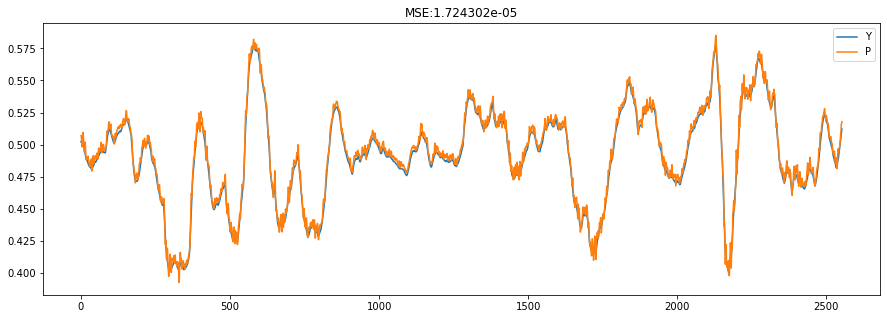

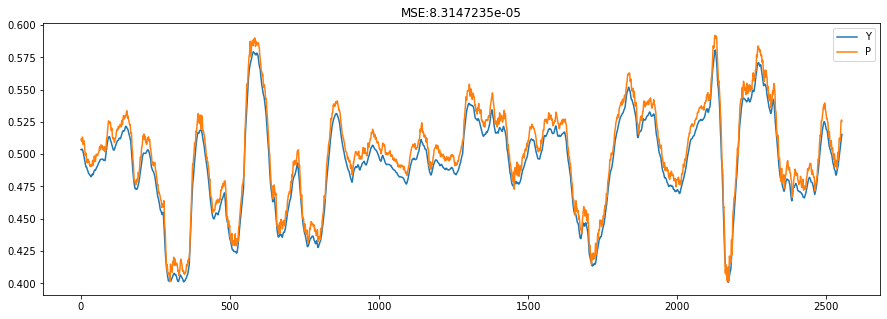

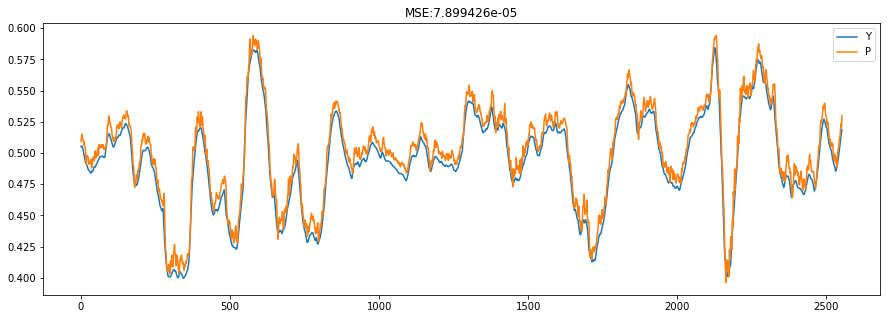

Shape  : (2553, 3, 1)
loss   : 1.873865221568849e-05
MSE    : 5.979483917084292e-05 
RMSE   : 0.007732712277774398 
NMSE   : 0.041847808343918776 
DS     : -0.8762240501370936 
WDS    : -4.741939800587413 
Samples: 2553


In [1065]:
plotAndEvaluate((vy),(predictions))

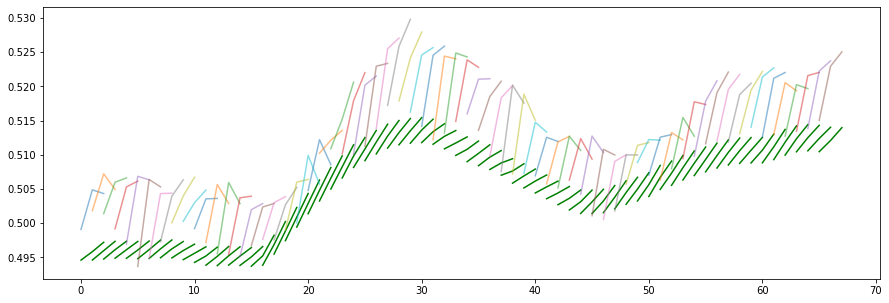

In [1066]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],lookAhead)
# plotVisual(vy,predictions,lookAhead,0.001)

### DNN

In [571]:
tf.keras.backend.clear_session()
def DNN_model(activation='elu',hidden=512,singleshot=False,dropout=0.5):
    if singleshot: outputSize=1
    else: outputSize=lookAhead
    return Sequential([Dense(hidden, activation),
                        Dropout(dropout),
                        Dense(hidden, activation),
                        Dropout(dropout),
                        Dense(1, activation),
                        Flatten(),
                        Dense(outputSize),
                        Reshape([outputSize,1])])
model=DNN_model("elu",512,singleshot,0.5)
history=compileFit(model,loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),epochs=10000,batch_size=500,patience=50,singleshot=singleshot)
# model.save("DNN_model")
# model=tf.keras.models.load_model('DNN_model')
# model.summary()

Epoch 1/10000
21/21 [==============================] - 1s 18ms/step - loss: 0.2926 - val_loss: 0.2491
Epoch 2/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.2396 - val_loss: 0.2215
Epoch 3/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.2157 - val_loss: 0.1959
Epoch 4/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.1885 - val_loss: 0.1581
Epoch 5/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.1475 - val_loss: 0.1076
Epoch 6/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0974 - val_loss: 0.0602
Epoch 7/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0545 - val_loss: 0.0281
Epoch 8/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0271 - val_loss: 0.0117
Epoch 9/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0139 - val_loss: 0.0050
Epoch 10/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0087 - val_l

21/21 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 5.0915e-04
Epoch 81/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 5.2030e-04
Epoch 82/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 3.3541e-04
Epoch 83/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 3.1321e-04
Epoch 84/10000
21/21 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 3.0740e-04
Epoch 85/10000
21/21 [==============================] - 0s 9ms/step - loss: 9.5760e-04 - val_loss: 3.0341e-04
Epoch 86/10000
21/21 [==============================] - 0s 9ms/step - loss: 9.6616e-04 - val_loss: 3.0703e-04
Epoch 87/10000
21/21 [==============================] - 0s 9ms/step - loss: 9.3856e-04 - val_loss: 2.9747e-04
Epoch 88/10000
21/21 [==============================] - 0s 9ms/step - loss: 9.1300e-04 - val_loss: 3.5564e-04
Epoch 89/10000
21/21 [=======================

Epoch 228/10000
21/21 [==============================] - 0s 9ms/step - loss: 6.0836e-04 - val_loss: 2.4193e-04
Epoch 229/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.9878e-04 - val_loss: 2.7694e-04
Epoch 230/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.9941e-04 - val_loss: 2.3605e-04
Epoch 231/10000
21/21 [==============================] - 0s 9ms/step - loss: 6.0044e-04 - val_loss: 2.3610e-04
Epoch 232/10000
21/21 [==============================] - 0s 9ms/step - loss: 6.0323e-04 - val_loss: 3.2855e-04
Epoch 233/10000
21/21 [==============================] - 0s 9ms/step - loss: 6.6223e-04 - val_loss: 3.1823e-04
Epoch 234/10000
21/21 [==============================] - 0s 9ms/step - loss: 6.1255e-04 - val_loss: 2.2222e-04
Epoch 235/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.6274e-04 - val_loss: 2.2754e-04
Epoch 236/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.8911e-04 - val_loss: 2.3450e-04
E

Epoch 302/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.2089e-04 - val_loss: 2.5373e-04
Epoch 303/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.3442e-04 - val_loss: 2.7286e-04
Epoch 304/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.2763e-04 - val_loss: 2.0729e-04
Epoch 305/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.0130e-04 - val_loss: 2.0168e-04
Epoch 306/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.0671e-04 - val_loss: 1.9802e-04
Epoch 307/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.2623e-04 - val_loss: 2.1274e-04
Epoch 308/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.9472e-04 - val_loss: 2.5858e-04
Epoch 309/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.1005e-04 - val_loss: 2.8713e-04
Epoch 310/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.3859e-04 - val_loss: 2.1209e-04
E

Epoch 376/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.6047e-04 - val_loss: 1.9013e-04
Epoch 377/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.7080e-04 - val_loss: 1.8428e-04
Epoch 378/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.4882e-04 - val_loss: 1.8291e-04
Epoch 379/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.4279e-04 - val_loss: 2.1733e-04
Epoch 380/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.8819e-04 - val_loss: 2.2291e-04
Epoch 381/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.7511e-04 - val_loss: 1.9450e-04
Epoch 382/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.6784e-04 - val_loss: 2.1211e-04
Epoch 383/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.5728e-04 - val_loss: 2.5283e-04
Epoch 384/10000
21/21 [==============================] - 0s 9ms/step - loss: 5.3255e-04 - val_loss: 1.9525e-04
E

Epoch 450/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.3945e-04 - val_loss: 1.7253e-04
Epoch 451/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.4810e-04 - val_loss: 1.9762e-04
Epoch 452/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.4213e-04 - val_loss: 1.9487e-04
Epoch 453/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.5185e-04 - val_loss: 2.0333e-04
Epoch 454/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.6926e-04 - val_loss: 1.7690e-04
Epoch 455/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.5659e-04 - val_loss: 2.2472e-04
Epoch 456/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.5737e-04 - val_loss: 2.1927e-04
Epoch 457/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.6213e-04 - val_loss: 2.6928e-04
Epoch 458/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.6970e-04 - val_loss: 1.6432e-04
E

Epoch 524/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9466e-04 - val_loss: 1.6036e-04
Epoch 525/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.1276e-04 - val_loss: 1.6830e-04
Epoch 526/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.2161e-04 - val_loss: 1.7583e-04
Epoch 527/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0612e-04 - val_loss: 1.6641e-04
Epoch 528/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.2622e-04 - val_loss: 1.5883e-04
Epoch 529/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0331e-04 - val_loss: 1.7338e-04
Epoch 530/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0889e-04 - val_loss: 1.5736e-04
Epoch 531/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0749e-04 - val_loss: 1.7385e-04
Epoch 532/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0141e-04 - val_loss: 1.6688e-04
E

Epoch 598/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.1584e-04 - val_loss: 1.5635e-04
Epoch 599/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0530e-04 - val_loss: 1.6968e-04
Epoch 600/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.1710e-04 - val_loss: 1.5756e-04
Epoch 601/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.1416e-04 - val_loss: 1.8372e-04
Epoch 602/10000
21/21 [==============================] - 0s 10ms/step - loss: 4.2470e-04 - val_loss: 1.5779e-04
Epoch 603/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9108e-04 - val_loss: 1.5611e-04
Epoch 604/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0679e-04 - val_loss: 1.7998e-04
Epoch 605/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0801e-04 - val_loss: 1.6167e-04
Epoch 606/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0331e-04 - val_loss: 1.5656e-04


Epoch 672/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9654e-04 - val_loss: 1.5215e-04
Epoch 673/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.8796e-04 - val_loss: 1.8784e-04
Epoch 674/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.3331e-04 - val_loss: 1.6215e-04
Epoch 675/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0696e-04 - val_loss: 1.5668e-04
Epoch 676/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9254e-04 - val_loss: 1.5449e-04
Epoch 677/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9654e-04 - val_loss: 1.5658e-04
Epoch 678/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.7760e-04 - val_loss: 1.5171e-04
Epoch 679/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0799e-04 - val_loss: 1.8252e-04
Epoch 680/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9604e-04 - val_loss: 1.7170e-04
E

Epoch 746/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9526e-04 - val_loss: 1.6231e-04
Epoch 747/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9512e-04 - val_loss: 1.5167e-04
Epoch 748/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9074e-04 - val_loss: 1.6005e-04
Epoch 749/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0877e-04 - val_loss: 1.8882e-04
Epoch 750/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9074e-04 - val_loss: 1.6063e-04
Epoch 751/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9659e-04 - val_loss: 1.6572e-04
Epoch 752/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9835e-04 - val_loss: 1.4909e-04
Epoch 753/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0086e-04 - val_loss: 1.5197e-04
Epoch 754/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.7940e-04 - val_loss: 1.4967e-04
E

Epoch 820/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0665e-04 - val_loss: 2.2464e-04
Epoch 821/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9900e-04 - val_loss: 1.5578e-04
Epoch 822/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.7982e-04 - val_loss: 1.4952e-04
Epoch 823/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.8512e-04 - val_loss: 1.6132e-04
Epoch 824/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.7874e-04 - val_loss: 1.7612e-04
Epoch 825/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.8493e-04 - val_loss: 1.6856e-04
Epoch 826/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9181e-04 - val_loss: 1.4713e-04
Epoch 827/10000
21/21 [==============================] - 0s 9ms/step - loss: 3.9387e-04 - val_loss: 1.5880e-04
Epoch 828/10000
21/21 [==============================] - 0s 9ms/step - loss: 4.0327e-04 - val_loss: 1.4784e-04


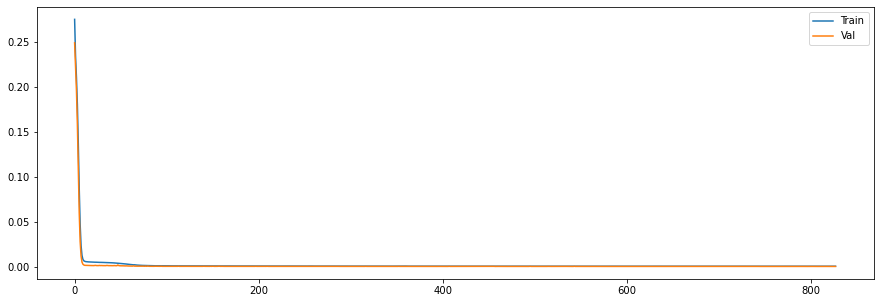

In [572]:
plotCompare(history.history['loss'],history.history['val_loss'],["Train","Val"])

In [573]:
calculateAccuracy(model,"DNN",singleshot,byDay,benchmarker,period,lookAhead,trainx,trainy,vx,vy)

<ipython-input-573-d98da62f4fa0>:12: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),2:4]=[period,lookAhead]
<ipython-input-573-d98da62f4fa0>:13: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  benchmarker.loc[benchmarker.index.max(),4:]=np.array([getResults(trainy,predictionsT, False)[:-1],getResults(vy,predictions, False)[:-1]]).flatten()


In [574]:
df1=pd.DataFrame(reverseOutputTransform(predictions,vk,logged=False,scaled=True).reshape(-1,lookAhead))
df2=pd.DataFrame(reverseOutputTransform(vy,vk,logged=False,scaled=True).reshape(-1,lookAhead))

In [575]:
fromN,toN=60,70

<AxesSubplot:>

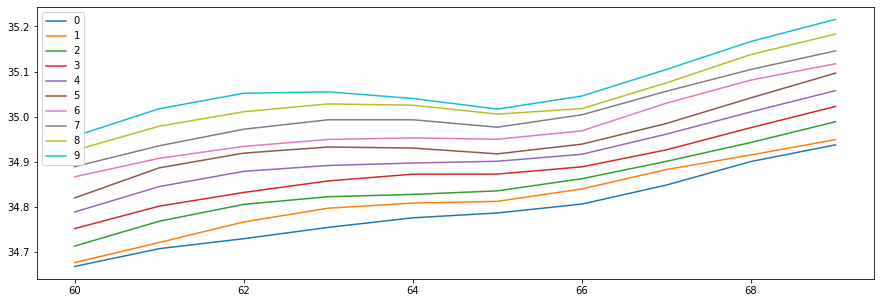

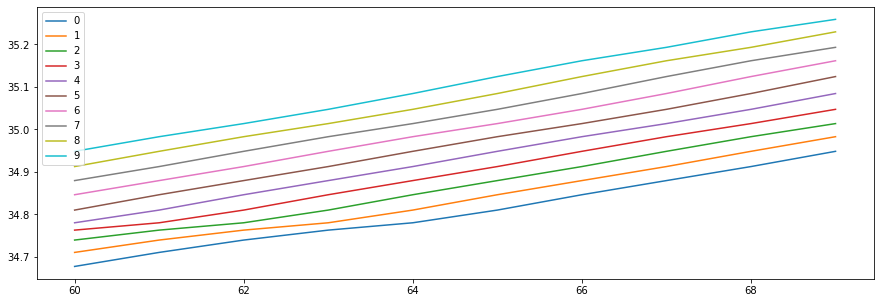

In [576]:
df1.iloc[fromN:toN].plot()
df2.iloc[fromN:toN].plot()

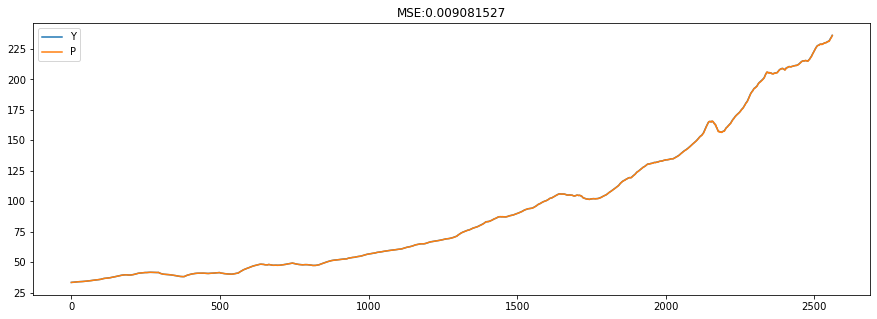

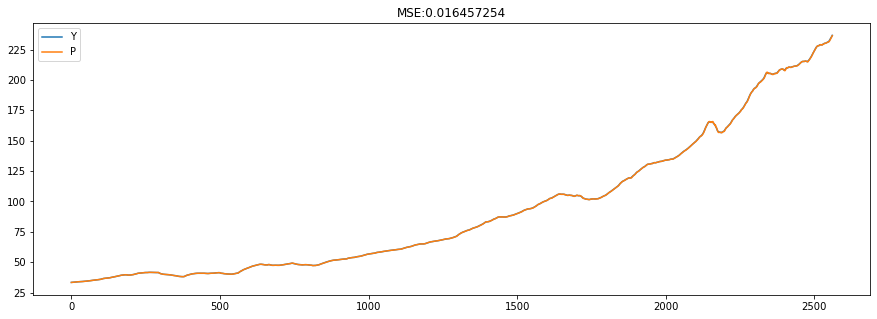

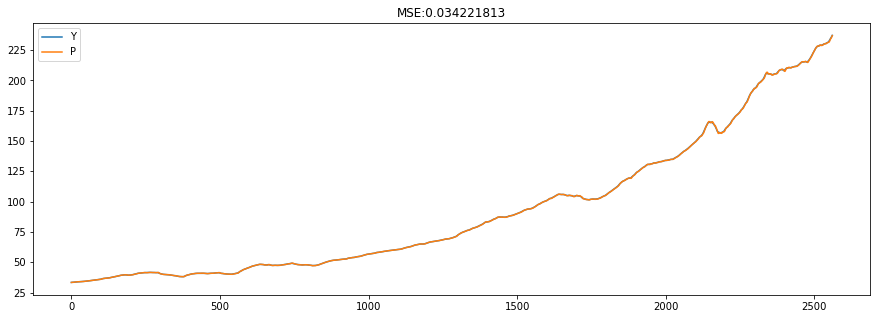

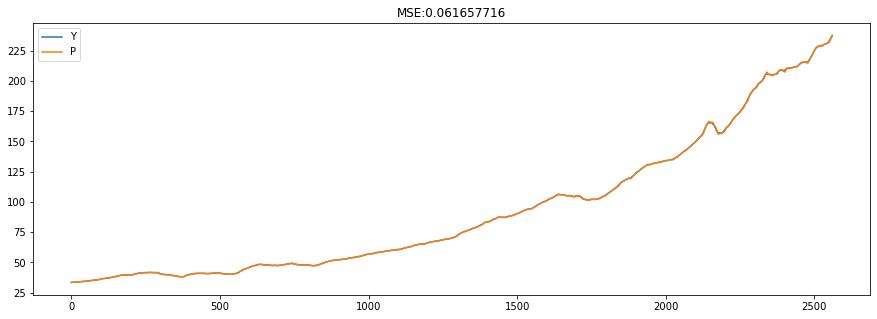

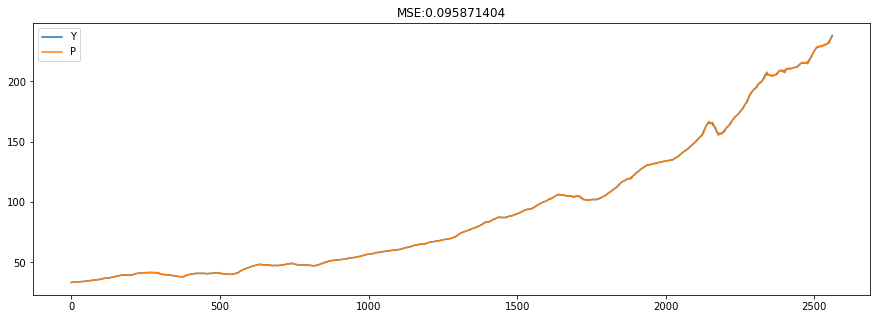

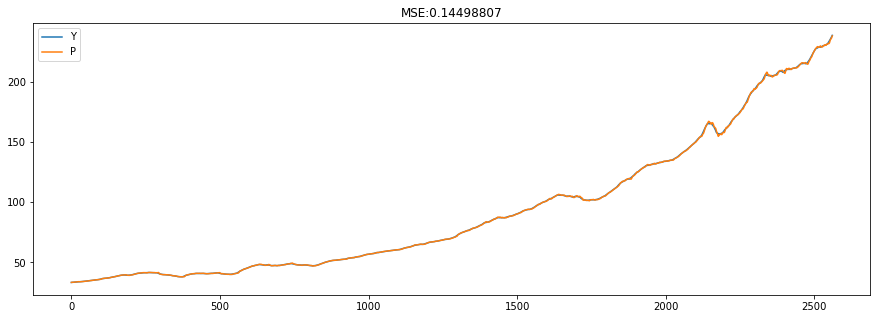

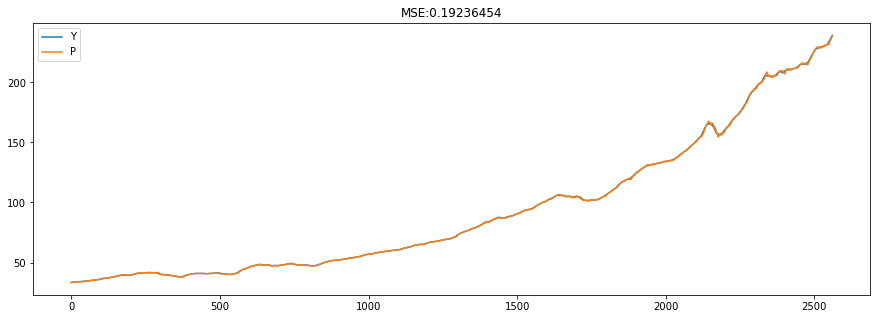

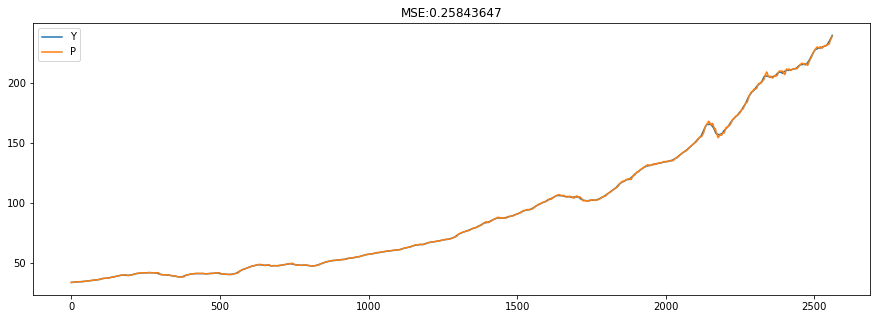

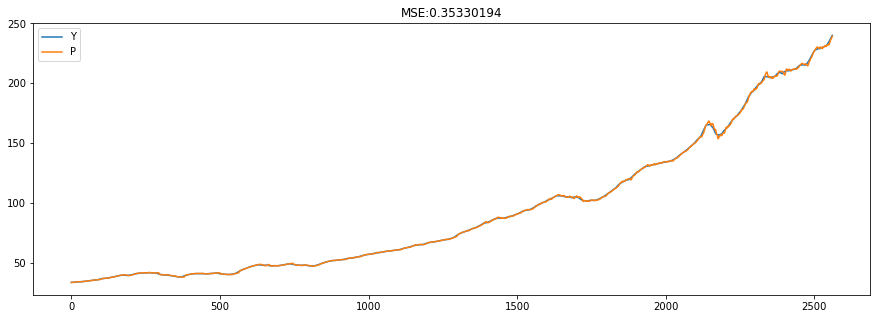

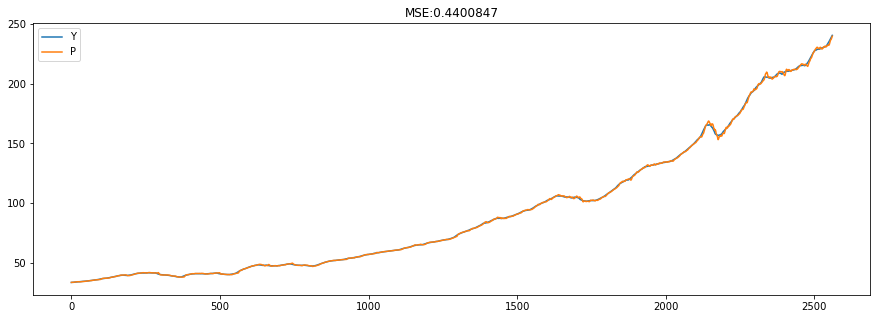

Shape  : (2561, 10, 1)
loss   : 11720.6689453125
MSE    : 0.16064664399494907 
RMSE   : 0.40080748994367493 
NMSE   : 0.0019352590032869228 
DS     : 0.2893401015228426 
WDS    : 0.0013970498319847327 
Samples: 2561


In [577]:
plotAndEvaluate(reverseOutputTransform(vy,vk,logged=False,scaled=True),reverseOutputTransform(predictions,vk,logged=False,scaled=True))

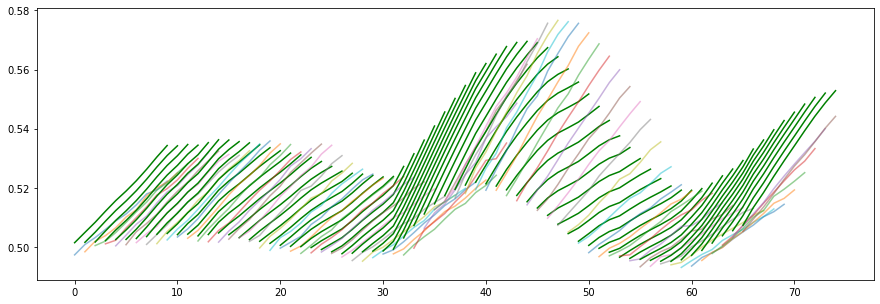

In [578]:
rrr=66
shiftff=66
plotMultVariate(vy[rrr:rrr+shiftff],predictions[rrr:rrr+shiftff],lookAhead)
# plotVisual(vy,predictions,lookAhead,0.001)

# Applying Sentiment to our models 

In [2264]:
dataSubset=getQueryFromMongoDB("ProcessedTweets",query={"stockInfo":"TSLA"},fields=["processed","dateCreated","followers","retweets","likes","positive","negative"]).sort_values('dateCreated')
dataSubset=dataSubset.drop_duplicates(subset=['processed'], keep='last')
# dataSubset=dataSubset.drop(columns="processed")
# dataSubset["dateCreated"]=dataSubset["dateCreated"].apply(lambda x:x.date())
dataSubset["ratio"]=(dataSubset["followers"]*dataSubset["retweets"])/dataSubset["likes"]
dataSubset["PM"]=dataSubset["positive"]*dataSubset["ratio"]
dataSubset["NM"]=dataSubset["negative"]*dataSubset["ratio"]
dataSubset=dataSubset.set_index(pd.to_datetime(dataSubset["dateCreated"], unit='D',utc=True))

In [2286]:
dataSubset

_id             dateCreated  \
dateCreated                                                                     
2021-01-23 20:54:27+00:00         1352618602202066947 2021-01-23 20:54:27.000   
2021-01-23 21:09:09+00:00         1351289447841730563 2021-01-23 21:09:09.000   
2021-01-23 21:10:43+00:00         1350525639716085760 2021-01-23 21:10:43.000   
2021-01-23 21:11:07+00:00         1350333141983010817 2021-01-23 21:11:07.000   
2021-01-23 21:11:07+00:00         1350332065485504512 2021-01-23 21:11:07.000   
...                                               ...                     ...   
2021-04-16 17:33:00.479000+00:00  1381960451584589828 2021-04-16 17:33:00.479   
2021-04-16 17:33:00.480000+00:00  1381960210768596995 2021-04-16 17:33:00.480   
2021-04-16 17:33:00.480000+00:00  1381959509791281159 2021-04-16 17:33:00.480   
2021-04-16 17:33:00.481000+00:00  1381958987260780546 2021-04-16 17:33:00.481   
2021-04-16 17:33:00.481000+00:00  1381959120782254083 2021-04-16 17:33:00.481   

                                  followers  likes  retweets  \
dateCreated                                                    
2021-01-23 20:54:27+00:00               546      7         2   
2021-01-23 21:09:09+00:00              2166     31         1   
2021-01-23 21:10:43+00:00               882      2         2   
2021-01-23 21:11:07+00:00               554    244        93   
2021-01-23 21:11:07+00:00               832      4         3   
...                                     ...    ...       ...   
2021-04-16 17:33:00.479000+00:00     112106     47         4   
2021-04-16 17:33:00.480000+00:00      24377     11         4   
2021-04-16 17:33:00.480000+00:00      17103     41         3   
2021-04-16 17:33:00.481000+00:00       5975     94        29   
2021-04-16 17:33:00.481000+00:00        608     29         4   

                                                                          processed  \
dateCreated                                                                           
2021-01-23 20:54:27+00:00         awesom news for hashtag the chines hashtag is ...   
2021-01-23 21:09:09+00:00                    hey usernametag im human tesla linktag   
2021-01-23 21:10:43+00:00         omfg there tesla in front of me that so dirti ...   
2021-01-23 21:11:07+00:00                 when autopilot mode fail in tesla linktag   
2021-01-23 21:11:07+00:00         hashtag thankyou usernametag the largest democ...   
...                                                                             ...   
2021-04-16 17:33:00.479000+00:00  tesla is bring machin gun to knife fight use a...   
2021-04-16 17:33:00.480000+00:00  state of top most valuabl compani appl msft am...   
2021-04-16 17:33:00.480000+00:00  tesla begin replac hw for model in germani for...   
2021-04-16 17:33:00.481000+00:00  tesla model giveaway for more detail on our te...   
2021-04-16 17:33:00.481000+00:00  usernametag just launch it new zero commiss tr...   

                                  positive  negative        ratio  \
dateCreated                                                         
2021-01-23 20:54:27+00:00         0.262099  0.737902   156.000000   
2021-01-23 21:09:09+00:00         0.110964  0.889036    69.870968   
2021-01-23 21:10:43+00:00         0.872194  0.127807   882.000000   
2021-01-23 21:11:07+00:00         0.874884  0.125116   211.155738   
2021-01-23 21:11:07+00:00         0.272014  0.727986   624.000000   
...                                    ...       ...          ...   
2021-04-16 17:33:00.479000+00:00  0.330837  0.669163  9540.936170   
2021-04-16 17:33:00.480000+00:00  0.861923  0.138077  8864.363636   
2021-04-16 17:33:00.480000+00:00  0.457824  0.542176  1251.439024   
2021-04-16 17:33:00.481000+00:00  0.043457  0.956543  1843.351064   
2021-04-16 17:33:00.481000+00:00  0.021218  0.978782    83.862069   

                                           PM           NM  
dateCreated                                                 
2021-01-23 

In [2287]:
r=dataSubset.resample('d').first().ffill().resample('d').sum()
r.replace([np.inf, -np.inf],[r[["NM","PM"]].max().max(),r[["NM","PM"]].min().min()], inplace=True)

<AxesSubplot:xlabel='dateCreated'>

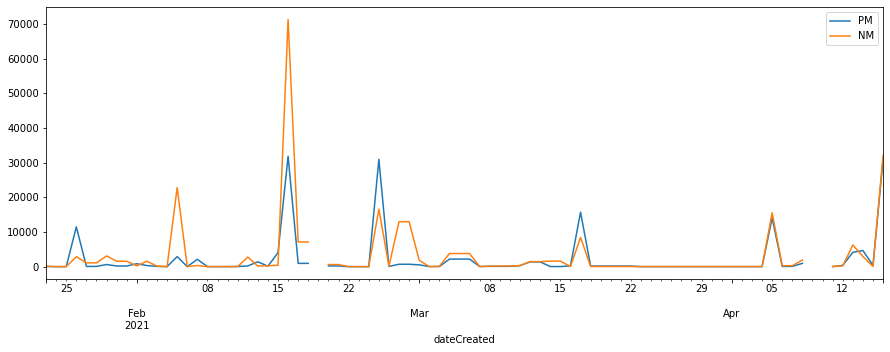

In [2288]:
r[["PM","NM"]].plot()

In [2289]:
pss.resample('D').first()
# data["wasNa"]=data['Close'].isna()#mark filled in spots for future reference
# print(data["wasNa"].value_counts())

NameError: name 'pss' is not defined

In [2290]:
pss["sentiment"]=model.predict(pss["body"].values)

NameError: name 'pss' is not defined

In [2291]:
pss["sentiment"]=pss["sentiment"].replace({0:-1,2:1})

NameError: name 'pss' is not defined

In [ ]:
# pss.set_index(pd.to_datetime(pss.index, unit='d',utc=True).dt.date)

In [ ]:
# TSLA=load("TSLA")
# TSLA=loadStockData(stock)
print(tweetdata.index.min(), tweetdata.index.max())
print(TSLA.index.min(), TSLA.index.max())
mini,maxi=None,None
if tweetdata.index.min()>TSLA.index.min(): mini=tweetdata.index.min()
else: mini= TSLA.index.min()
if tweetdata.index.max()>TSLA.index.max(): mini=TSLA.index.max()
else: maxi= tweetdata.index.max()
print(mini,"-",maxi)

In [ ]:
# check if stock has relationship with sentiment
# check if sentiment compenent works well
# check if sentiment compenent improves stock predictions 
# check if fill in and check missing data in time series problems
# check how roll calculates missing values 

In [ ]:
pss

In [ ]:
# tslaTweets=tweetdata[tweetdata["body"].str.contains("tsla|tesla", case=False, na=None, regex=True)]
# tslaTweets["sentiment"]=model.predict(tslaTweets["body"])
# tslaTweets["good"],tslaTweets["bad"]=tslaTweets["sentiment"].apply(lambda x: x==4 and 1 or 0),tslaTweets["sentiment"].apply(lambda x: x==0 and 1 or 0)
# tslaTweets=tslaTweets.groupby(tslaTweets.index).sum()
# tslaTweets=tslaTweets.set_index(pd.to_datetime(tslaTweets.index))

In [ ]:
pss["good"],pss["bad"]=pss["sentiment"].apply(lambda x: x==1 and 1 or 0),pss["sentiment"].apply(lambda x: x==-1 and 1 or 0)
pss=pss.groupby(pss.index).sum()
pss=pss.set_index(pd.to_datetime(pss.index))
pss

In [ ]:
pss["diff"]=pss["good"]-pss["bad"]
pss["str"]=pss["diff"]/(pss["good"]+pss["bad"])
pss["sign"]=np.sign(pss["diff"])
pss["change"]=(pss["diff"]-pss["diff"].shift(1)).fillna(0)
pss["changeS"]=np.sign(pss["change"])
pss=pss.resample('D').first()
pss=pss.ffill()

In [ ]:
# tslaTweets
# findMissingInterval(tslaTweets)

In [ ]:
# slices.drop(columns=['sentiment'], inplace=True)
tslaTweets["diff"]=tslaTweets["good"]-tslaTweets["bad"]
tslaTweets["str"]=tslaTweets["diff"]/(tslaTweets["good"]+tslaTweets["bad"])
tslaTweets["sign"]=np.sign(tslaTweets["diff"])
tslaTweets["change"]=(tslaTweets["diff"]-tslaTweets["diff"].shift(1)).fillna(0)
tslaTweets["changeS"]=np.sign(tslaTweets["change"])
tslaTweets=tslaTweets.resample('D').first()
tslaTweets=tslaTweets.ffill()

In [ ]:
pss.index.max(),pss.index.min(),TSLA.index.max(),TSLA.index.min()

In [ ]:
mini=pss.index.min()
maxi=pss.index.max()

In [ ]:
fromD=mini+ timedelta(days=12)
to=mini+ timedelta(days=360)
common=pd.merge(left=data, left_index=True, right=pss, right_index=True)
commonr=common.rolling(12).mean().dropna()
commonr[fromD:to][["Close"]].plot(xlim=(fromD,to))
commonr[fromD:to][["change","diff"]].plot(xlim=(fromD,to))
commonr[fromD:to][["str","changeS"]].plot(xlim=(fromD,to))
commonr[fromD:to][['good', 'bad', 'diff', 'str', 'change']].plot(xlim=(fromD,to))

In [ ]:
commonr

# Results

In [ ]:
# dataIn,dataOut=createTimeSeriesData(commonr[["Close","sentiment"]],outputColumns=["Close"],outputlengthTimeSteps=lookAhead,shifts=period)
# dataIn=(dataIn.to_numpy().reshape(dataIn.shape[0],period,-1))
# dataOut=(dataOut.to_numpy().reshape(dataOut.shape[0],lookAhead,-1))
# split=0.2
trainx,vtx,trainy,vty=train_test_split(dataIn,dataOut,test_size=split,shuffle=False)
vx,tx,vy,ty=train_test_split(vtx,vty,test_size=0.5,shuffle=False)
print("Total Samples:",len(dataIn),"\t\t\tTraining Samples:",len(trainx))
print("Total Validation Samples:",len(vy),"\t\tTest Samples:",len(ty))
print("Input Data Shape:",tx.shape[1:],"\t\tOutput Data Shape:",ty.shape[1:])

In [ ]:
trainx,vtx,trainy,vty=train_test_split(data[:-1][["Close"]].values.reshape(-1,1,1),data[:-1][["Close"]].values.reshape(-1,1,1),test_size=0.2,shuffle=False)